# Introduction

Hey there! We are the group "Skip Connections" and this is our notebook for the first assignment.

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Homework_1

Mounted at /content/drive
/content/drive/MyDrive/Homework_1


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import pickle
import cv2

In [ ]:
# Call this to use mixed precision for faster training (remember to set output layer dtype=32)
# tfk.mixed_precision.set_global_policy("mixed_float16") #not using it because it's slower

### Load data

In [ ]:
data = np.load("data.npz", allow_pickle=True)
list(data.keys())

['data', 'labels', 'names']

In [ ]:
X = data['data']
X.shape

(15092, 48, 48, 3)

In [ ]:
y = data['labels']
y.shape

(15092, 1)

In [ ]:
labels = data['names']
labels

array({0: 'Basophil', 1: 'Eosinophil', 2: 'Erythroblast', 3: 'Immature Granulocyte', 4: 'Lymphocyte', 5: 'Monocyte', 6: 'Neutrophil', 7: 'Platelet'},
      dtype=object)

In [ ]:
# Train/val/test split
# Here, we decide not to use cross validation to measure performance,
# as it would be too computationally demanding (at least in the first stages)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1500, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1000, stratify = y_train)

print(f"X shapes: \n Train Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")
print(f"y shapes: \n Train Set: {y_train.shape}, Validation Set: {y_val.shape}, Test Set: {y_test.shape}")

X shapes: 
 Train Set: (12592, 48, 48, 3), Validation Set: (1000, 48, 48, 3), Test Set: (1500, 48, 48, 3)
y shapes: 
 Train Set: (12592, 1), Validation Set: (1000, 1), Test Set: (1500, 1)


In [ ]:
# Normalize data to the range [0, 1]
X_train = X_train.astype("float32")/255.
X_val = X_val.astype("float32")/255.
X_test = X_test.astype("float32")/255.

In [ ]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

Input Shape: (48, 48, 3), Output Shape: 8


### Create visualization function

In [ ]:
def plot_histories(histories, titles, legend_loc = 'upper left'):
  palette = ['#ff7f0e', '#4D61E2', '#50C878', '#9467bd', '#d62728', '#FFFF00']

  assert len(histories) == len(titles)
  assert len(histories) <= len(palette)

  # Cross-entropy
  plt.figure(figsize=(15,5))
  for i, history in enumerate(histories):
    plt.plot(history['loss'], alpha=.3, color=palette[i], linestyle='--')
    plt.plot(history['val_loss'], label=titles[i], alpha=.8, color=palette[i])
  plt.legend(loc=legend_loc)
  plt.title('Categorical Crossentropy')
  plt.grid(alpha=.3)

  # Accuracy
  plt.figure(figsize=(15,5))
  for i, history in enumerate(histories):
    plt.plot(history['accuracy'], alpha=.3, color=palette[i], linestyle='--')
    plt.plot(history['val_accuracy'], label=titles[i], alpha=.8, color=palette[i])
  plt.legend(loc=legend_loc)
  plt.title('Accuracy')
  plt.grid(alpha=.3)

  plt.show()

### Create function for printing metrics

In [ ]:
#Function to compute model accuracy
def assess_performance(model_name, X_test, y_test):
  assert isinstance(model_name, str)
  model = tfk.models.load_model(model_name)
  predictions = np.argmax(model.predict(X_test, verbose=0), axis = 1).astype('int32')
  y_true = np.argmax(y_test, axis=-1).astype('int32')
  # Compute classification metrics
  accuracy = accuracy_score(y_true, predictions)
  # Display the computed metrics
  print('Accuracy:', accuracy.round(4), '\n')
  print(classification_report(y_true, predictions), '\n')
  #Confusion matrix
  cm = confusion_matrix(y_true, predictions)
  # Plot the confusion matrix
  plt.figure(figsize=(8,6))
  sns.heatmap(cm.T, xticklabels=np.arange(8), yticklabels=np.arange(8), cmap="Blues")
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

### Create building blocks

In [ ]:
# Define a convolutional block with batch normalization option
def conv_bn_block(x, filters, kernel_size, padding='same', downsample=False, activation='relu', stack=2, strides = 1, batch_norm=False, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Apply a stack of convolutional layers with optional batch normalization and specified activation
    for s in range(stack):
        x = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x)
        if batch_norm:
            x = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x)
        x = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x)

    return x

In [ ]:
# Define a residual convolutional block with optional batch normalization
def conv_residual_block(x, filters, kernel_size, padding='same', downsample=False, activation='relu', stack=2, batch_norm=False, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Create a copy of the input for the residual connection
    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x_)

    # If downsample is True, apply a 1x1 convolution to match the number of filters
    if downsample:
        x = tfkl.Conv2D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

In [ ]:
# Define a dense block
def dense_block(x, filters, kernel_size, padding='same', activation='relu', stack=2, batch_norm=False, name=''):
    # Initial convolution on the input
    x_concat = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + '0')(x)

    # List to store intermediate outputs for concatenation
    intermediate_outputs = [x_concat]

    # Apply a stack of convolutional layers and concatenate with original input
    for s in range(1, stack + 1):
        #x_ = tfkl.Conv2D(filters=filters*4, kernel_size=1, padding=padding, name='Conv_bott_' + name + str(s))(x_concat) the bottleneck increases computational load
        x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s))(x_concat)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s))(x_)
        intermediate_outputs.append(x_)
        x_concat = tfkl.Concatenate(name='Concat_' + name + str(s))(intermediate_outputs)

    return x_concat

In [ ]:
# Inception-ResNet-A module using the conv_bn_block function.

def inception_resnet_a(x, scale_residual=0.1, name=''):

    # Branch 1
    branch1 = conv_bn_block(x, 32, 1, padding='same', downsample=False, stack=1, strides=1, batch_norm=True, name='Branch1_' + name)

    # Branch 2
    branch2 = conv_bn_block(x, 32, 1, padding='same', downsample=False, stack=1, strides=1, batch_norm=True, name='Branch2a_' + name)
    branch2 = conv_bn_block(branch2, 32, 3, padding='same', downsample=False, stack=1, strides=1, batch_norm=True, name='Branch2b_' + name)

    # Branch 3
    branch3 = conv_bn_block(x, 32, 1, padding='same', downsample=False, stack=1, strides=1, batch_norm=True, name='Branch3a_' + name)
    branch3 = conv_bn_block(branch3, 48, 3, padding='same', downsample=False, stack=1, strides=1, batch_norm=True, name='Branch3b_' + name)
    branch3 = conv_bn_block(branch3, 64, 3, padding='same', downsample=False, stack=1, strides=1, batch_norm=True, name='Branch3c_' + name)


    branches = [branch1,branch2,branch3]

    # Concatenate all branches
    mixed = tfkl.Concatenate(axis=3, name=name + '_concat')(branches)
    filt_exp_1x1 = conv_bn_block(mixed,64,1,padding='same', downsample=False, activation='linear', stack=1, batch_norm=True, name=name+'filt_exp_1x1')
    output = tfkl.Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=tfk.backend.int_shape(x)[1:],
                      arguments={'scale': scale_residual},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return output


In [ ]:
def reduction_a(x, name = ''):
    #print(x.shape)

    # Branch 1 with MaxPooling
    branch1 = conv_bn_block(x, 32, 3, padding='valid', downsample=True, stack=1, strides=2, batch_norm=True, name='Branch1')

    # Branch 2
    branch2 = conv_bn_block(x, 256, 1, padding='same', downsample=False, stack=2, strides=1, batch_norm=True, name='Branch2a')
    branch2 = conv_bn_block(branch2, 256, 3, padding='same', downsample=False, stack=1, strides=1, batch_norm=True, name='Branch2b')
    branch2 = conv_bn_block(branch2, 32, 3, padding='valid', downsample=True,  stack=1, strides=2, batch_norm=True, name='Branch2c')

    # Branch 3
    branch3 = tfkl.MaxPooling2D(5, 2, padding='valid', name='Branch3')(x)
    branch3 = conv_bn_block(branch3, 32, 3, downsample=False, stack=1, strides=1, batch_norm=True, name=name + 'Branch3a')

    # Concatenate all branches
    output = tfkl.Concatenate(axis=-1)([branch1, branch2, branch3])

    return output

# Exploratory analysis

### Label visualization

Let's start by taking a look at the classes.

In [ ]:
labels = pd.DataFrame(data['labels'])
names = pd.Series(dict(data['names'].tolist())).reset_index()

labels.columns = ['label']
names.columns = ['label', 'name']

labels = labels.merge(names, on = 'label')

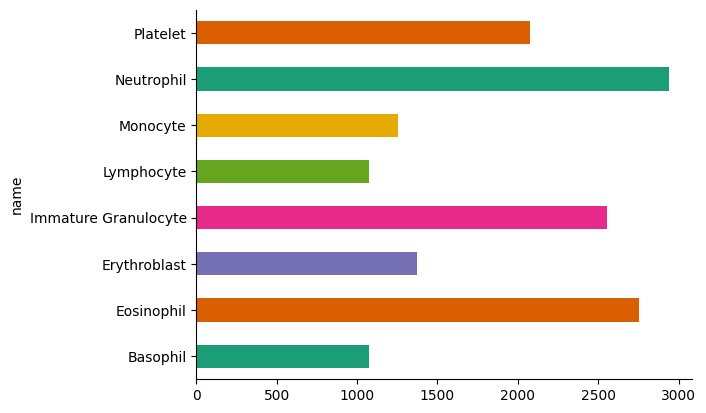

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
labels.groupby('name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Data visualization

The labels in the dataset are not distributed randomly but rather in blocks; however, this is not important. The key point here is that the classes are slightly imbalanced.

Let's look at an example of each type of cell now.


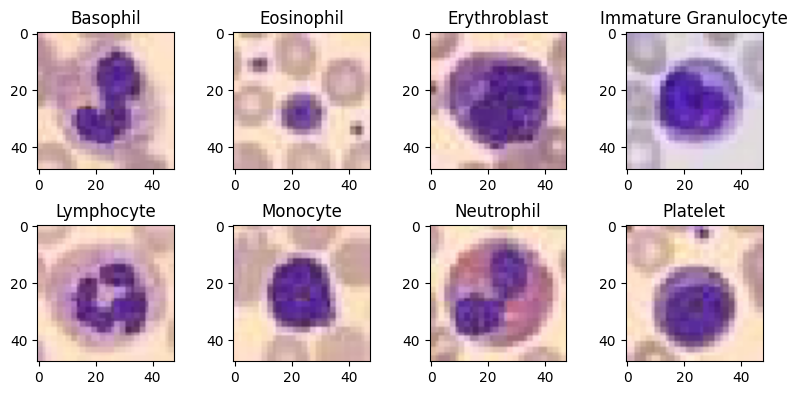

In [ ]:
# Plot each type of cell
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

for i, name in enumerate(names['name']):
    label_index = labels.loc[labels['name'] == name].index[0]
    ax = axes[i // 4, i % 4]  # Calculate the row and column for the subplot
    ax.imshow(X[label_index, :, :, :])
    ax.set_title(name)

plt.tight_layout()
plt.show()

### Diameter of the cells in the dataset

Let's compute the diameter of the cells in the images.

In [ ]:
import cv2

def compute_diameters(image):
    # Convert normalized image to the range [0, 255]
    image = (image * 255).astype(np.uint8)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Using Otsu's binarization
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    max_diameters_per_image = []
    min_diameters_per_image = []
    avg_diameters_per_image = []

    for contour in contours:
        rect = cv2.minAreaRect(contour) # computes the minimum-area bounding rectangle
        box = cv2.boxPoints(rect) # retrieves the four corners of the bounding rectangle
        box = np.int0(box)

        # The distances between each pair of these four points are computed:
        dists = []
        for i in range(4):
            for j in range(i+1, 4):
                dists.append(np.linalg.norm(box[i] - box[j]))

        max_diameter = max(dists) # the max distance is the diagonal of the rectangle
        min_diameter = min([dists[i] for i in [0, 2, 3, 5]]) # the min distance is the shortest side
        avg_diameter = (max_diameter + min_diameter) / 2.0

        avg_diameters_per_image.append(avg_diameter)
        max_diameters_per_image.append(max_diameter)
        min_diameters_per_image.append(min_diameter)

    return max_diameters_per_image, min_diameters_per_image, avg_diameters_per_image

all_max_diameters = []
all_min_diameters = []
all_avg_diameters = []

for image in X_train:
    max_diam, min_diam, avg_diam = compute_diameters(image)
    all_max_diameters.extend(max_diam)
    all_min_diameters.extend(min_diam)
    all_avg_diameters.extend(avg_diam)


# Convert to numpy arrays for further processing or analysis
all_max_diameters = np.array(all_max_diameters)
all_min_diameters = np.array(all_min_diameters)
all_avg_diameters = np.array(all_avg_diameters)


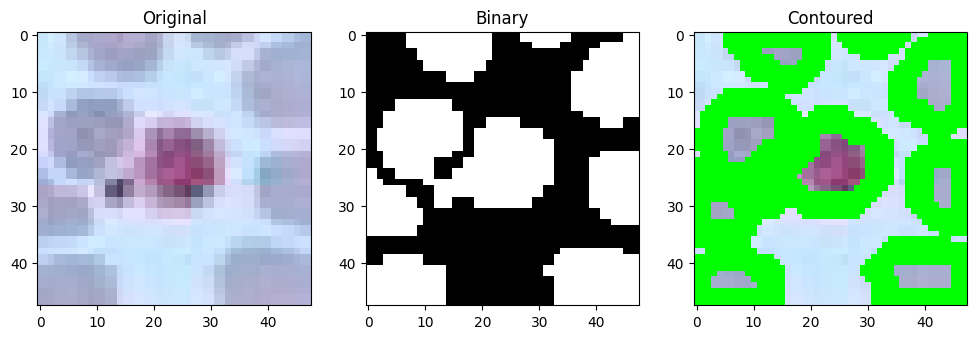

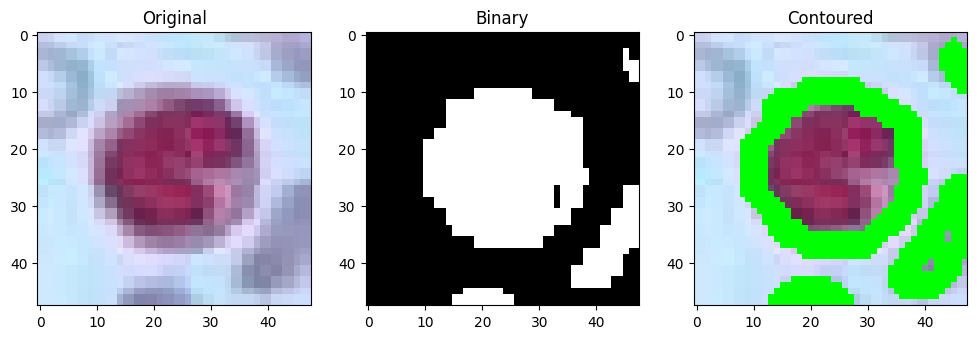

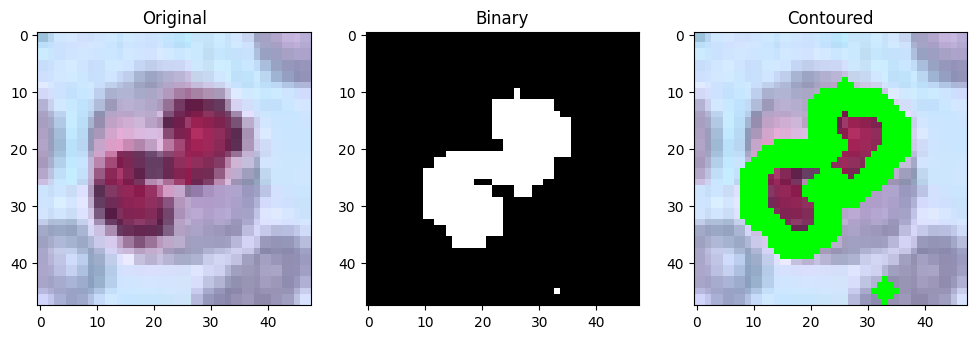

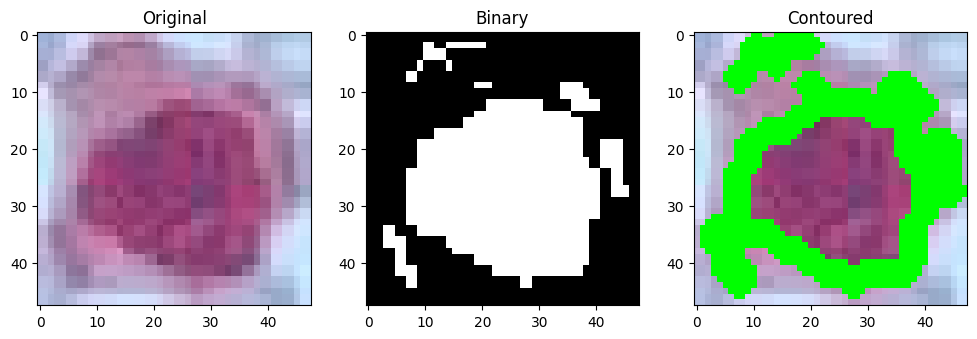

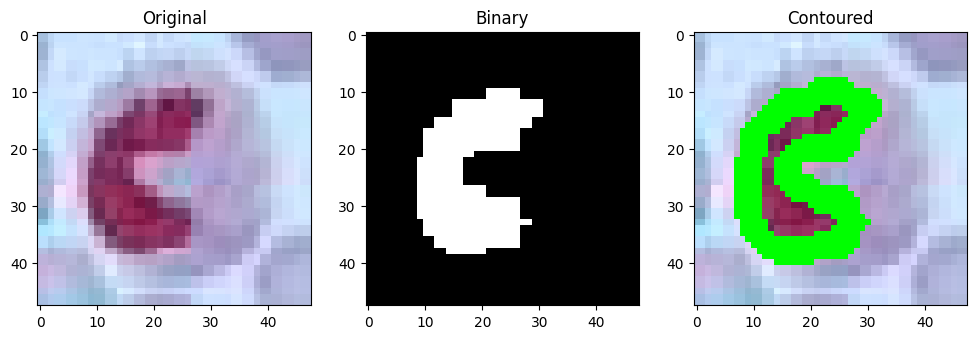

In [ ]:
for i, image in enumerate(X_train[:5]):
    # Convert normalized image back to the range [0, 255]
    image_255 = (image * 255).astype(np.uint8)

    gray_image = cv2.cvtColor(image_255, cv2.COLOR_BGR2GRAY)

    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contoured_image = cv2.drawContours(image_255.copy(), contours, -1, (0, 255, 0), 3)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(image_255, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(1, 3, 2), plt.imshow(binary_image, cmap='gray'), plt.title('Binary')
    plt.subplot(1, 3, 3), plt.imshow(cv2.cvtColor(contoured_image, cv2.COLOR_BGR2RGB)), plt.title('Contoured')
    plt.show()


In [ ]:
all_max_diameters, all_min_diameters, all_avg_diameters.shape # we have more outputs than num of elements in X_train as this function detects all the shapes in the pictures,
                                                              # even non relevant ones

(array([15.26433752, 18.35755975, 14.2126704 , ..., 11.18033989,
         1.41421356, 65.06919394]),
 array([ 8.        ,  9.        ,  9.        , ...,  4.24264069,
         1.        , 45.        ]),
 (41588,))

The previous function finds the diameter of each object in each picture, but we only want the relevant one: the one in the center. So we add some modifications to the function.

In [ ]:
def compute_diameters(image):
    # Convert normalized image to the range [0, 255]
    image = (image * 255).astype(np.uint8)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Using Otsu's binarization
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:  # Check if any contour is detected
        return None, None, None  # Return None if no contours are found

    center = np.array([image.shape[1] / 2, image.shape[0] / 2])  # Center of the image

    # Find the contour closest to the center of the image
    distances_to_center = [np.linalg.norm(np.mean(cnt, axis=0) - center) for cnt in contours]
    centermost_contour = contours[np.argmin(distances_to_center)]

    rect = cv2.minAreaRect(centermost_contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Compute diameters as previously
    dists = []
    for i in range(4):
        for j in range(i+1, 4):
            dists.append(np.linalg.norm(box[i] - box[j]))

    max_diameter = max(dists)
    min_diameter = min([dists[i] for i in [0, 2, 3, 5]])
    avg_diameter = (max_diameter + min_diameter) / 2.0

    return max_diameter, min_diameter, avg_diameter

all_max_diameters = []
all_min_diameters = []
all_avg_diameters = []

for image in X_train:
    max_diam, min_diam, avg_diam = compute_diameters(image)
    if max_diam is not None:  # Ensure we have a diameter (i.e., a contour was found)
        all_max_diameters.append(max_diam)
        all_min_diameters.append(min_diam)
        all_avg_diameters.append(avg_diam)

# Convert to numpy arrays for further processing or analysis
all_max_diameters = np.array(all_max_diameters)
all_min_diameters = np.array(all_min_diameters)
all_avg_diameters = np.array(all_avg_diameters)


In [ ]:
all_max_diameters.shape, all_min_diameters.shape, all_avg_diameters.shape # now it works

((12592,), (12592,), (12592,))

We can now visualize how the modified function works (the green contour is the one we select)

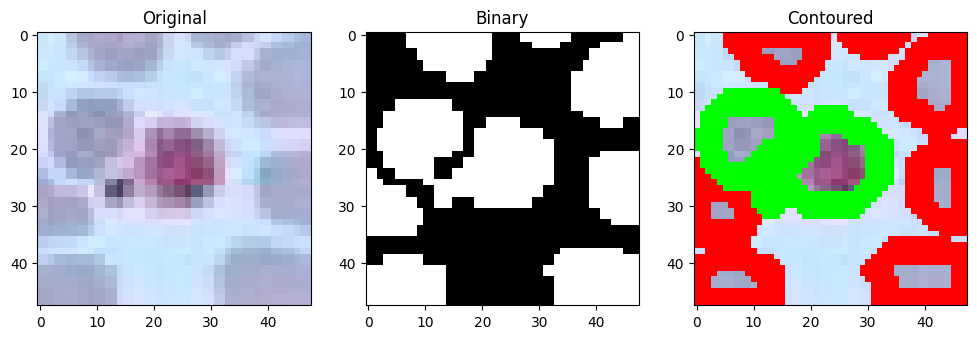

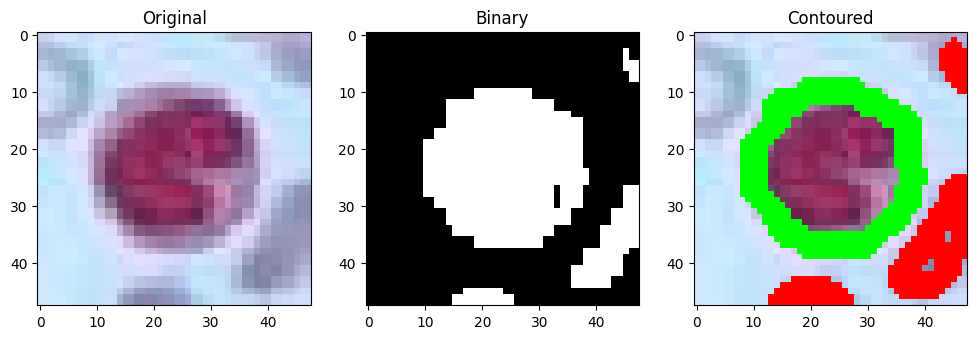

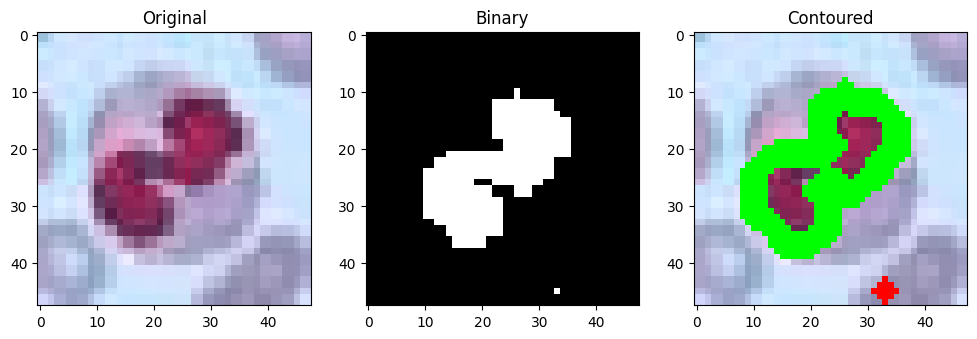

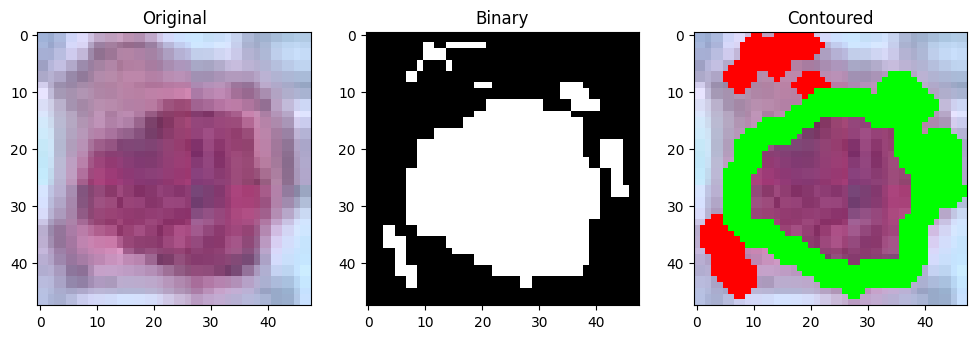

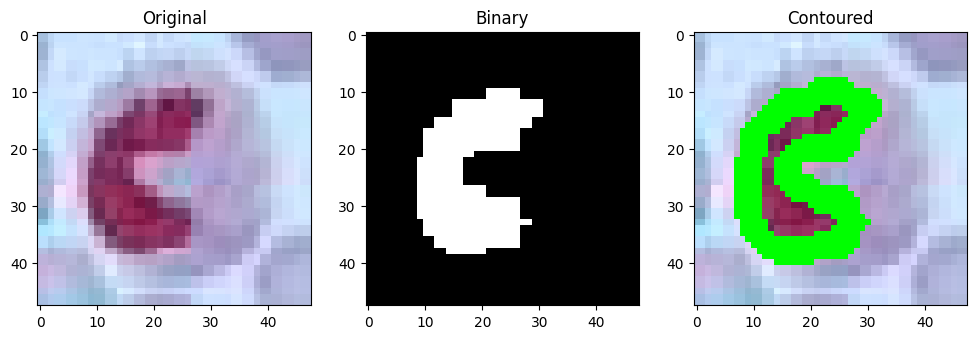

In [ ]:
def get_centermost_contour(contours, image_shape):
    center = np.array([image_shape[1] / 2, image_shape[0] / 2])  # Center of the image
    distances_to_center = [np.linalg.norm(np.mean(cnt, axis=0) - center) for cnt in contours]
    centermost_contour_index = np.argmin(distances_to_center)
    return centermost_contour_index

for i, image in enumerate(X_train[:5]):
    # Convert normalized image back to the range [0, 255]
    image_255 = (image * 255).astype(np.uint8)

    gray_image = cv2.cvtColor(image_255, cv2.COLOR_BGR2GRAY)

    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centermost_contour_index = get_centermost_contour(contours, image_255.shape)

    contoured_image = cv2.drawContours(image_255.copy(), contours, -1, (0, 0, 255), 3)  # Draw all contours in red
    contoured_image = cv2.drawContours(contoured_image, contours, centermost_contour_index, (0, 255, 0), 3)  # Highlight centermost contour in green

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(image_255, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(1, 3, 2), plt.imshow(binary_image, cmap='gray'), plt.title('Binary')
    plt.subplot(1, 3, 3), plt.imshow(cv2.cvtColor(contoured_image, cv2.COLOR_BGR2RGB)), plt.title('Contoured')
    plt.show()


Now, we can plot the densities of the average diameters for each class.

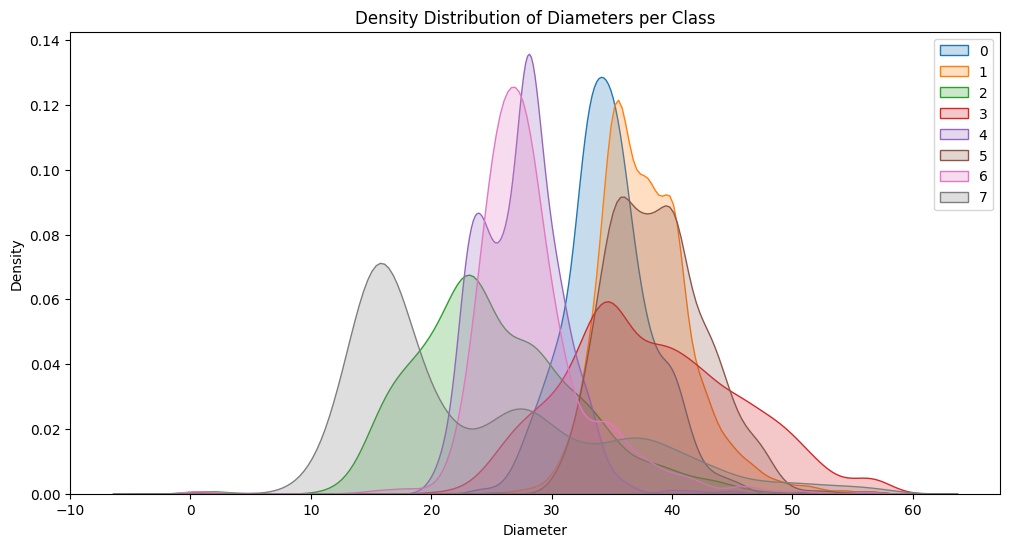

In [ ]:
y_train1 = []
for e in y_train:
  y_train1.append(np.argmax(e))
y_train1 = np.array(y_train1)
y_train1

import seaborn as sns

# Create DataFrame
df = pd.DataFrame({
    'Diameter': all_avg_diameters,
    'Class': y_train1
})

# Create KDE plot
plt.figure(figsize=(12, 6))

# Loop over each unique class and plot its KDE
for class_val in np.unique(y_train1):
    sns.kdeplot(df[df['Class'] == class_val]['Diameter'], label=class_val, shade=True)

plt.title('Density Distribution of Diameters per Class')
plt.legend()
plt.show()


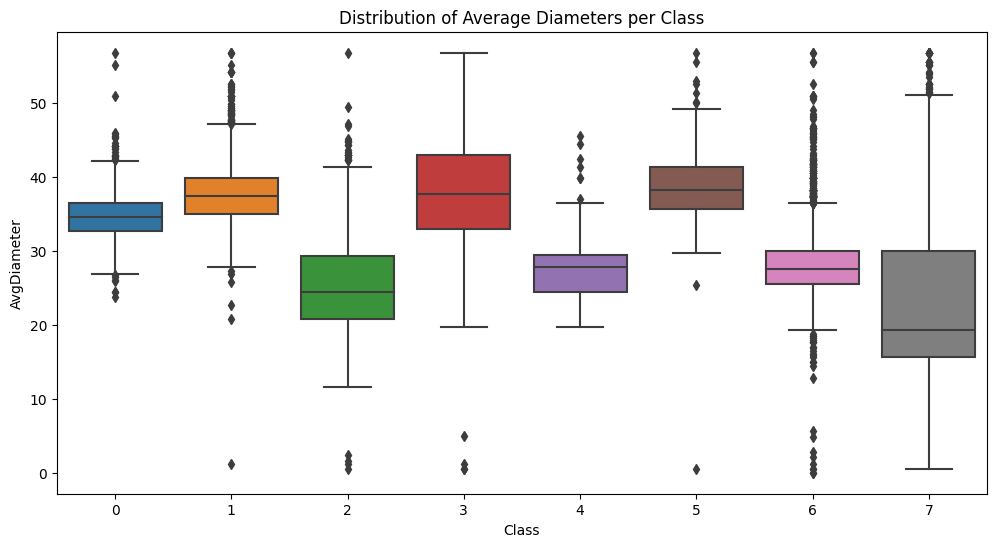

In [ ]:
# Create DataFrame
df = pd.DataFrame({
    'AvgDiameter': all_avg_diameters,
    'Class': y_train1
})

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='AvgDiameter', data=df)
plt.title('Distribution of Average Diameters per Class')
plt.show()

Another way to compute the diameters is to use bounding ellipses:

In [ ]:
def compute_diameters(image):
    # Convert normalized image to the range [0, 255]
    image = (image * 255).astype(np.uint8)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Using Otsu's binarization
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:  # Check if any contour is detected
        return None, None  # Return None if no contours are found

    center = np.array([image.shape[1] / 2, image.shape[0] / 2])  # Center of the image

    # Find the contour closest to the center of the image
    distances_to_center = [np.linalg.norm(np.mean(cnt, axis=0) - center) for cnt in contours]
    centermost_contour = contours[np.argmin(distances_to_center)]

    # Check if there are enough points for fitting an ellipse
    if centermost_contour.shape[0] < 5:
        return -1, -1 # if we don't have enough points to fit the ellipses then we set the diameters to -1

    ellipse = cv2.fitEllipse(centermost_contour)

    # The diameters of the ellipse are the length of the major and minor axis
    major_axis = max(ellipse[1])
    minor_axis = min(ellipse[1])

    return major_axis, minor_axis

all_major_diameters = []
all_minor_diameters = []

for image in X_train:
    major_diam, minor_diam = compute_diameters(image)
    if major_diam is not None:  # Ensure we have diameters (i.e., a contour was found and an ellipse was fitted)
        all_major_diameters.append(major_diam)
        all_minor_diameters.append(minor_diam)

# Convert to numpy arrays for further processing or analysis
all_major_diameters = np.array(all_major_diameters)
all_minor_diameters = np.array(all_minor_diameters)
all_average_diameters = (all_minor_diameters+all_major_diameters)/2

all_average_diameters.shape

(12592,)

We can now look at the distributions of the diameters conditional on the classes, computed with bounding boxes and bounding ellipses:

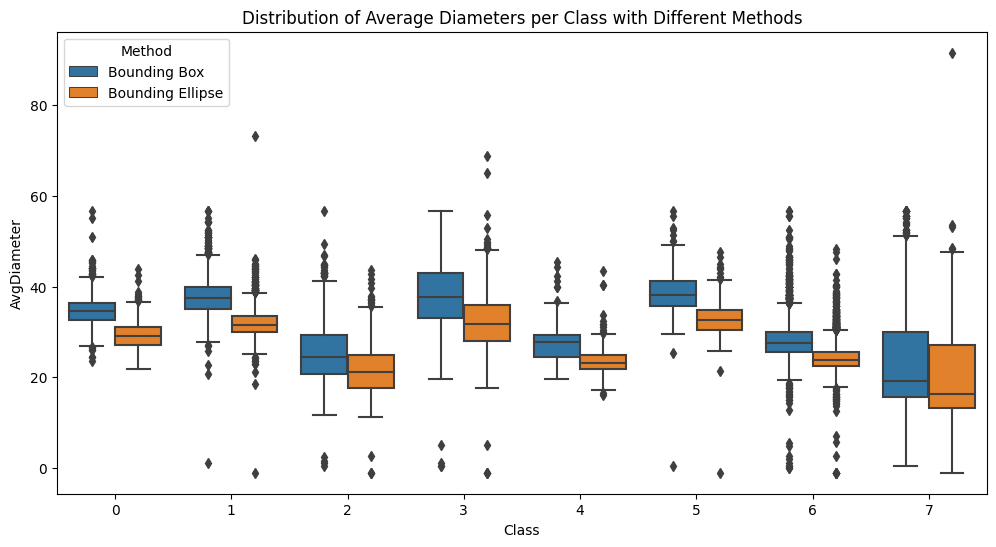

In [ ]:
y_train1 = []
for e in y_train:
  y_train1.append(np.argmax(e))
y_train1 = np.array(y_train1)
y_train1

# Combine both average diameter lists and the corresponding class labels into one DataFrame
df_box = pd.DataFrame({
    'AvgDiameter': all_avg_diameters,
    'Class': y_train1,
    'Method': 'Bounding Box'
})

df_ellipse = pd.DataFrame({
    'AvgDiameter': all_average_diameters,
    'Class': y_train1,
    'Method': 'Bounding Ellipse'
})

# Concatenate both DataFrames
df_combined = pd.concat([df_box, df_ellipse])

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='AvgDiameter', hue='Method', data=df_combined)
plt.title('Distribution of Average Diameters per Class with Different Methods')
plt.legend(title='Method')
plt.show()



### Distribution of average intensities of red, green, and blue in the pictures

Channel 0 : 
 Min: 12, Max: 255, Avg: 202.64036904669877, Std_Avg: 55.01251404481942 

Channel 1 : 
 Min: 0, Max: 255, Avg: 168.28781264264364, Std_Avg: 61.64670364383767 

Channel 2 : 
 Min: 18, Max: 255, Avg: 177.6007578863526, Std_Avg: 30.022661661701875 



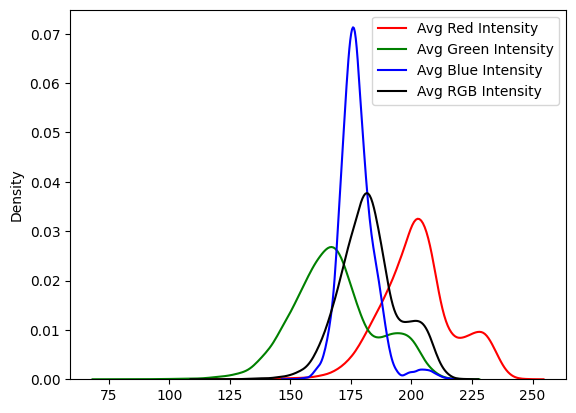

In [ ]:
#Distribution of image mean values by channel.
rgb_colors = ['r', 'g', 'b']
for i in range(X.shape[-1]):
  print(f'Channel {i} : \n Min: {X[:,:,:,i].min()}, Max: {X[:,:,:,i].max()},\
 Avg: {X[:,:,:,i].mean()}, Std_Avg: {X[:,:,:,i].std()} \n')
  mean_channel = []
  for j in range(X.shape[0]):
    mean_channel.append(np.mean(X[j][:, :, i]))
  sns.kdeplot(mean_channel, color = rgb_colors[i])


# Mean over all channels of the RGB space.
mean_values = []
for i in range(X.shape[0]):
  mean_values.append(np.mean(X[i]))
sns.kdeplot(mean_values, color = 'black')
plt.legend(labels = ['Avg Red Intensity', 'Avg Green Intensity', 'Avg Blue Intensity', 'Avg RGB Intensity'])
plt.show()

By plotting the distributions of the average intensities of the three channels (red, green, blue), we can notice a slight bimodality.

# Experiments

### Baseline model - MobileNetV2

Before testing our hypothesis, we need to equip ourselves with a baseline model that we can use as a benchmark. Here, we use MobileNetV2 because it's fast to train and has good performance.

In [ ]:
# Train a MobileNet on the dataset
mobile = tfk.applications.MobileNetV2(
    input_shape=(48, 48, 3),
    include_top=False,
    weights=None,
    pooling='avg',
)

# Create an input layer with shape (48, 48, 3)
inputs = tfk.Input(shape=(48, 48, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a dropout layer with 50% dropout rate
x = tfkl.Dropout(0.5)(x)
# Add a Dense layer with 8 units and softmax activation as the classifier
outputs = tfkl.Dense(8, activation='softmax')(x)

# Create a Model connecting input and output
model_baseline = tfk.Model(inputs=inputs, outputs=outputs, name='baseline_model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model_baseline.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model_baseline.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 mobilenetv2_1.00_48 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
Total params: 2268232 (8.65 MB)
Trainable params: 2234120 (8.52 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [ ]:
# Train the model
history_baseline = model_baseline.fit(
    x = X_train,
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
394/394 [==============================] - 54s 42ms/step - loss: 0.9668 - accuracy: 0.6556 - val_loss: 2.0663 - val_accuracy: 0.1690
Epoch 2/200
394/394 [==============================] - 16s 41ms/step - loss: 0.5231 - accuracy: 0.8158 - val_loss: 2.2723 - val_accuracy: 0.1690
Epoch 3/200
394/394 [==============================] - 14s 36ms/step - loss: 0.4194 - accuracy: 0.8526 - val_loss: 2.3925 - val_accuracy: 0.1690
Epoch 4/200
394/394 [==============================] - 14s 36ms/step - loss: 0.3722 - accuracy: 0.8744 - val_loss: 2.3896 - val_accuracy: 0.0830
Epoch 5/200
394/394 [==============================] - 14s 37ms/step - loss: 0.3520 - accuracy: 0.8877 - val_loss: 2.3304 - val_accuracy: 0.0830
Epoch 6/200
394/394 [==============================] - 14s 35ms/step - loss: 0.3086 - accuracy: 0.8986 - val_loss: 2.2701 - val_accuracy: 0.0830
Epoch 7/200
394/394 [==============================] - 14s 36ms/step - loss: 0.2791 - accuracy: 0.9064 - val_loss: 2.2971 - val_ac

In [ ]:
# Save the history
# with open('history_baseline.pickle', 'wb') as handle:
#     pickle.dump(history_baseline, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_baseline.pickle', 'rb') as handle:
    history_baseline = pickle.load(handle)

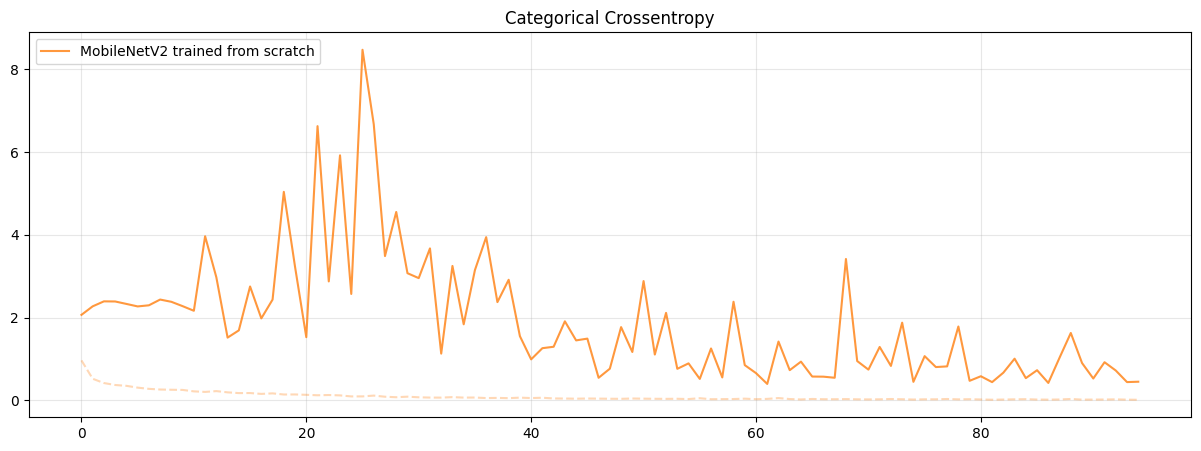

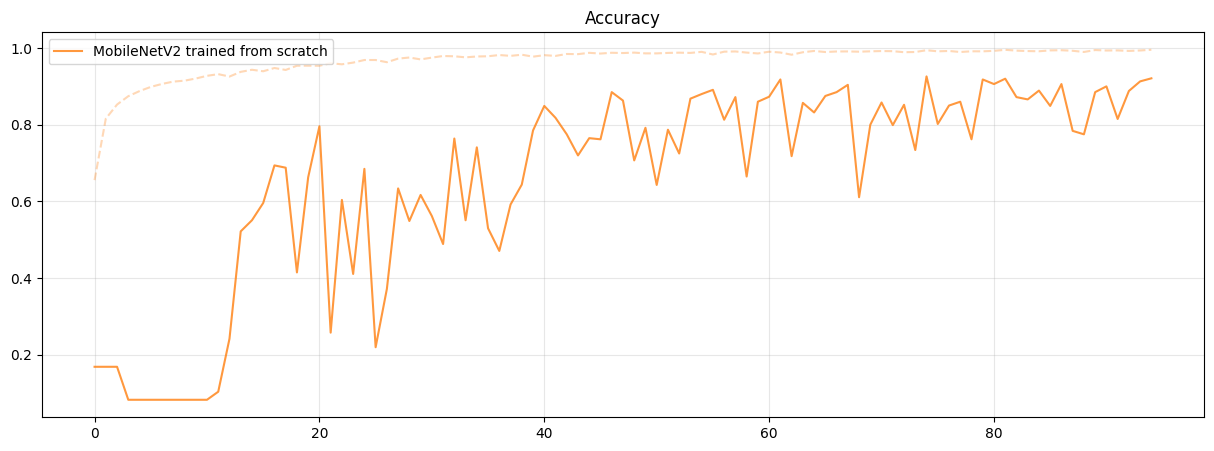

In [ ]:
# Plot the results of the run
plot_histories([history_baseline], ['MobileNetV2 trained from scratch'])

The validation loss is far from smooth, which means that we need more regularization.

In [ ]:
# Save the baseline model
# model_baseline.save('BaselineModelMobileNetV2')

Accuracy: 0.9173 

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       107
           1       0.98      0.98      0.98       273
           2       0.96      0.86      0.91       136
           3       0.78      0.92      0.84       254
           4       0.88      0.98      0.93       107
           5       0.93      0.69      0.79       125
           6       0.93      0.96      0.95       292
           7       1.00      1.00      1.00       206

    accuracy                           0.92      1500
   macro avg       0.93      0.89      0.90      1500
weighted avg       0.92      0.92      0.92      1500
 



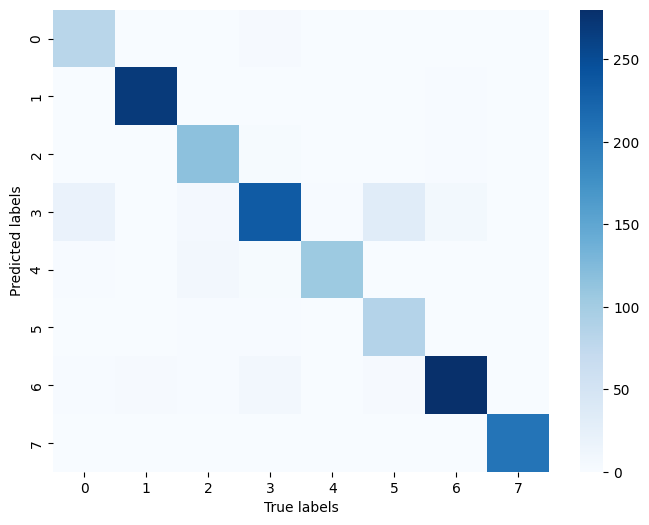

In [ ]:
# Evaluate the performance of the model
assess_performance('BaselineModelMobileNetV2', X_test, y_test)

Class 3 has the lowest accuracy, while class 5 has the lowest recall. Overall, the accuracy seems really good.

### Fine-tuning - MobileNetV2

Given the small dataset, we attempted to increase performance by leveraging pretrained models. We will use the same model we used for the baseline, MobileNetV2, to see if there are improvements ceteris paribus.

In [ ]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(48, 48, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

print(f"Layers number: {len(mobile.layers)}")

Layers number: 155


In [ ]:
# Freeze first N layers
N = 133
for i, layer in enumerate(mobile.layers[:N]):
  layer.trainable=False

# Create an input layer with shape (48, 48, 3)
inputs = tfk.Input(shape=(48, 48, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a dropout layer with 50% dropout rate
x = tfkl.Dropout(0.5)(x)
# Add a Dense layer with 8 units and softmax activation as the classifier
outputs = tfkl.Dense(8, activation='softmax')(x)

# Create a Model connecting input and output
model_finetuning1 = tfk.Model(inputs=inputs, outputs=outputs, name='finetuning1_model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model_finetuning1.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model_finetuning1.summary()

Model: "finetuning1_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 8)                 10248     
                                                                 
Total params: 2268232 (8.65 MB)
Trainable params: 1216328 (4.64 MB)
Non-trainable params: 1051904 (4.01 MB)
_________________________________________________________________


We are training roughly half the parameters of the pre trained model.

In [ ]:
# Train the model
history_finetuning1 = model_finetuning1.fit(
    x = X_train,
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
394/394 [==============================] - 19s 32ms/step - loss: 0.9079 - accuracy: 0.7103 - val_loss: 5.6318 - val_accuracy: 0.4940
Epoch 2/200
394/394 [==============================] - 11s 29ms/step - loss: 0.6159 - accuracy: 0.7960 - val_loss: 3.2002 - val_accuracy: 0.5940
Epoch 3/200
394/394 [==============================] - 8s 19ms/step - loss: 0.5416 - accuracy: 0.8217 - val_loss: 2.0966 - val_accuracy: 0.7110
Epoch 4/200
394/394 [==============================] - 7s 17ms/step - loss: 0.4465 - accuracy: 0.8467 - val_loss: 1.3259 - val_accuracy: 0.7500
Epoch 5/200
394/394 [==============================] - 5s 13ms/step - loss: 0.4143 - accuracy: 0.8572 - val_loss: 1.6408 - val_accuracy: 0.7290
Epoch 6/200
394/394 [==============================] - 6s 15ms/step - loss: 0.3607 - accuracy: 0.8735 - val_loss: 1.9689 - val_accuracy: 0.7010
Epoch 7/200
394/394 [==============================] - 6s 16ms/step - loss: 0.3406 - accuracy: 0.8793 - val_loss: 1.2916 - val_accurac

In [ ]:
# Save the history
# with open('history_finetuning1.pickle', 'wb') as handle:
#     pickle.dump(history_finetuning1, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_finetuning1.pickle', 'rb') as handle:
    history_finetuning1 = pickle.load(handle)

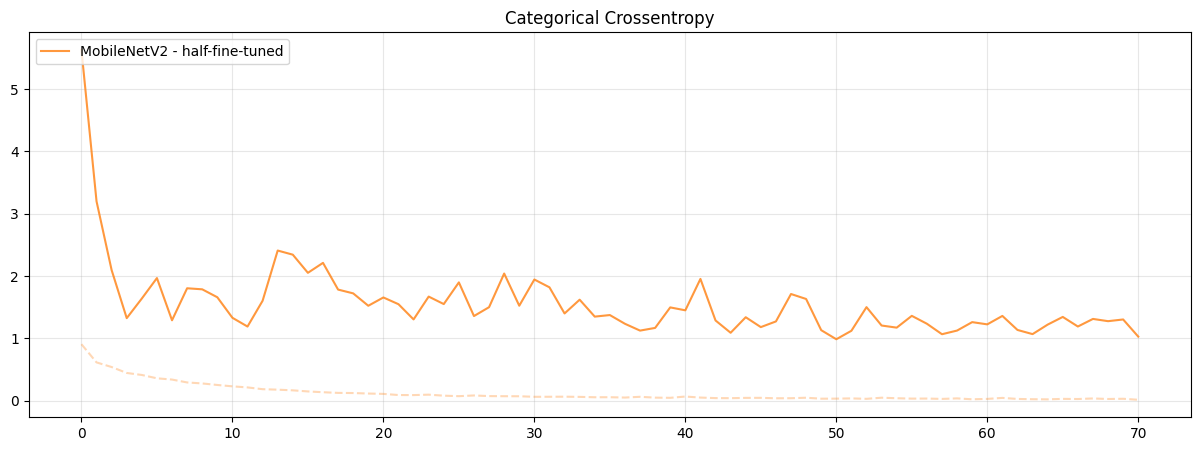

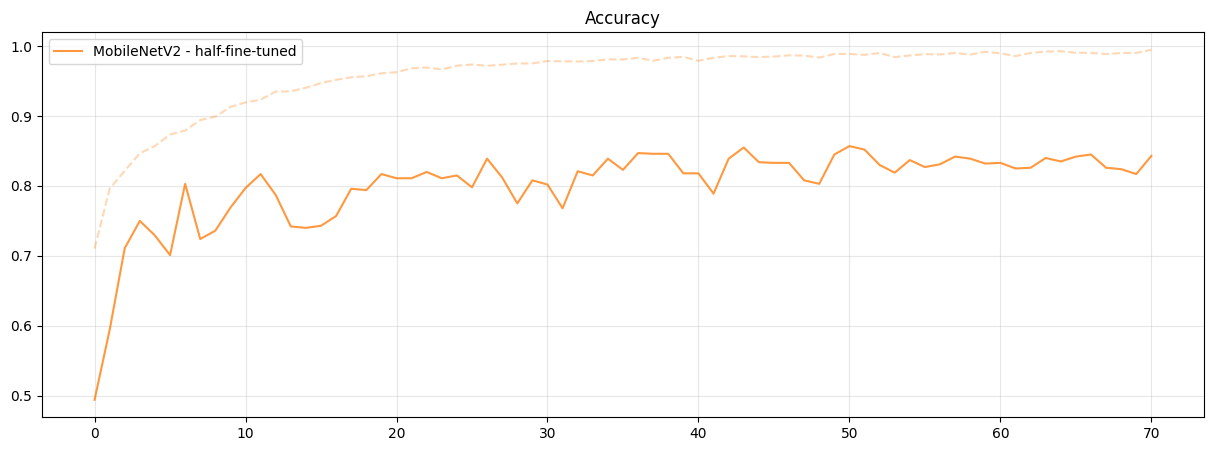

In [ ]:
# Plot the results of the run
plot_histories([history_finetuning1], ['MobileNetV2 - half-fine-tuned'])

This is quite a surprising result! The training is less erratic and more stable. However, the model struggles to get past 85% accuracy on the validation set. Our hypothesis is that our images are so different from the ones in ImageNet that training only half of the parameters is actually detrimental because we cannot leverage the existing weights in a meaningful way. The initial convolutional filters, for example, are not optimized for our images. Let's try to fine-tune all the parameters of the model so that hopefully the training will be more stable, but we will still see good accuracy on the validation set. We can also increase the patience to 30 to be sure that the plateau has been reached.

In [ ]:
# Train all the parameters on top of ImageNet weights
mobile = tfk.applications.MobileNetV2(
    input_shape=(48, 48, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

# Create an input layer with shape (48, 48, 3)
inputs = tfk.Input(shape=(48, 48, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a dropout layer with 50% dropout rate
x = tfkl.Dropout(0.5)(x)
# Add a Dense layer with 8 units and softmax activation as the classifier
outputs = tfkl.Dense(8, activation='softmax')(x)

# Create a Model connecting input and output
model_finetuning2 = tfk.Model(inputs=inputs, outputs=outputs, name='finetuning2_model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model_finetuning2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Train the model
history_finetuning2 = model_finetuning2.fit(
    x = X_train,
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)]
).history

Epoch 1/200
394/394 [==============================] - 47s 49ms/step - loss: 0.7245 - accuracy: 0.7679 - val_loss: 28.6344 - val_accuracy: 0.2110
Epoch 2/200
394/394 [==============================] - 14s 36ms/step - loss: 0.4831 - accuracy: 0.8479 - val_loss: 27.3685 - val_accuracy: 0.1800
Epoch 3/200
394/394 [==============================] - 15s 37ms/step - loss: 0.4093 - accuracy: 0.8665 - val_loss: 22.7157 - val_accuracy: 0.1840
Epoch 4/200
394/394 [==============================] - 15s 38ms/step - loss: 0.2876 - accuracy: 0.9052 - val_loss: 29.8568 - val_accuracy: 0.2920
Epoch 5/200
394/394 [==============================] - 15s 37ms/step - loss: 0.2227 - accuracy: 0.9297 - val_loss: 12.0492 - val_accuracy: 0.2250
Epoch 6/200
394/394 [==============================] - 15s 37ms/step - loss: 0.2668 - accuracy: 0.9263 - val_loss: 22.2033 - val_accuracy: 0.1690
Epoch 7/200
394/394 [==============================] - 14s 36ms/step - loss: 0.4533 - accuracy: 0.8534 - val_loss: 16.5978 -

In [ ]:
# Save the history
# with open('history_finetuning2.pickle', 'wb') as handle:
#     pickle.dump(history_finetuning2, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_finetuning2.pickle', 'rb') as handle:
    history_finetuning2 = pickle.load(handle)

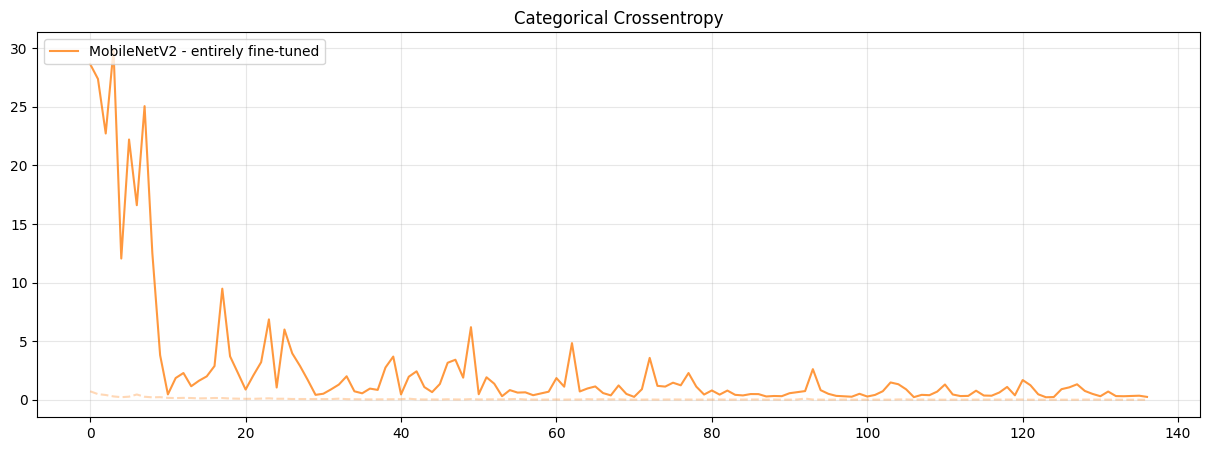

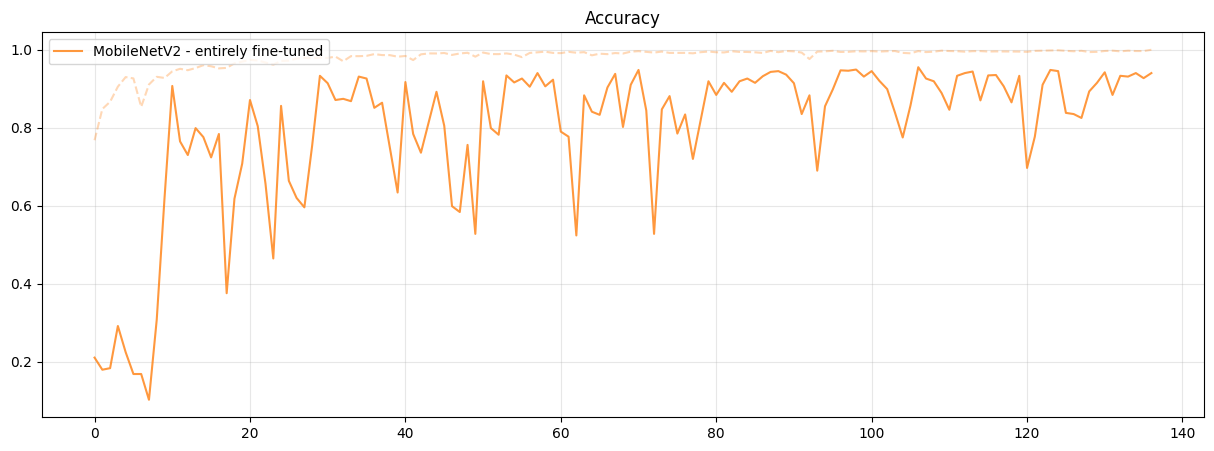

In [ ]:
# Plot the results of the run
plot_histories([history_finetuning2], ['MobileNetV2 - entirely fine-tuned'])

In [ ]:
# Save the model
# model_finetuning2.save('FinetunedMobileNetV2')

Accuracy: 0.944 

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       107
           1       1.00      0.97      0.99       273
           2       0.96      0.96      0.96       136
           3       0.85      0.91      0.88       254
           4       0.97      0.96      0.97       107
           5       0.81      0.87      0.84       125
           6       1.00      0.93      0.96       292
           7       1.00      1.00      1.00       206

    accuracy                           0.94      1500
   macro avg       0.94      0.94      0.94      1500
weighted avg       0.95      0.94      0.94      1500
 



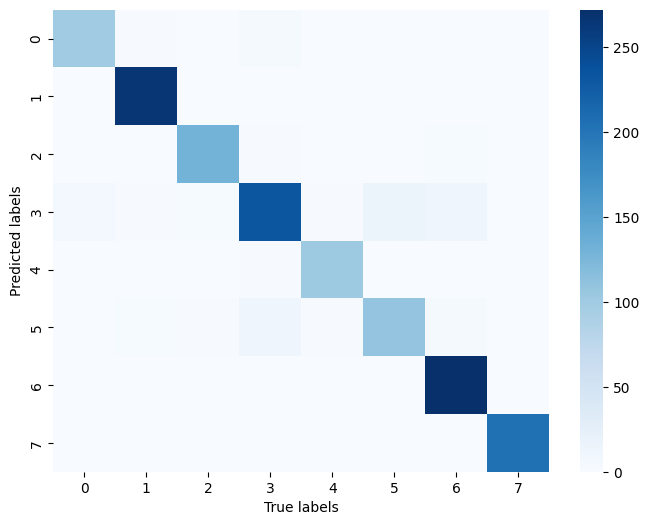

In [ ]:
# Evaluate the performance of the model
assess_performance('FinetunedMobileNetV2', X_test, y_test)

Wow! This is an extremely good jump in accuracy: +2.7%.

The lowest f1 scores are again from classes 3 and 5. Class 3 score is especially concerning because it is the third most represented class, so a low score here can have a high impact on accuracy. However, in the end, it all depends on how the test classes are balanced.

Again, the validation loss is really bumpy. Is it a sign of overfitting?

### Fine-tuning - EfficientNet

This is the second-smallest model we can find in the applications module of Keras. It is much more powerful than Mobile Net (better accuracy, double the parameters), and it should give us an idea of whether scale can bring better results. We noticed that the validation loss is very unstable, and this might be due to the fact that we are using a very tiny dataset, so the model might overfit. What we expect from this model is potentially a more irregular validation loss and higher accuracy. Let's see.

In [ ]:
# Train all the parameters on top of ImageNet weights
efficientnet = tfk.applications.EfficientNetV2B0(
    input_shape=(48, 48, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

# Create an input layer with shape (48, 48, 3)
inputs = tfk.Input(shape=(48, 48, 3))
# Connect the smallest EfficientNetV2 to the input
x = efficientnet(inputs)
# Add a dropout layer with 50% dropout rate
x = tfkl.Dropout(0.5)(x)
# Add a Dense layer with 8 units and softmax activation as the classifier
outputs = tfkl.Dense(8, activation='softmax')(x)

# Create a Model connecting input and output
model_finetuning3 = tfk.Model(inputs=inputs, outputs=outputs, name='finetuning3_model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model_finetuning3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Train the model
history_finetuning3 = model_finetuning3.fit(
    x = X_train,
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)]
).history

24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/200
394/394 [==============================] - 94s 86ms/step - loss: 0.7106 - accuracy: 0.7528 - val_loss: 2.8725 - val_accuracy: 0.2090
Epoch 2/200
394/394 [==============================] - 40s 101ms/step - loss: 0.3650 - accuracy: 0.8740 - val_loss: 2.4968 - val_accuracy: 0.1790
Epoch 3/200
394/394 [==============================] - 27s 69ms/step - loss: 0.2799 - accuracy: 0.9051 - val_loss: 2.5071 - val_accuracy: 0.1450
Epoch 4/200
394/394 [==============================] - 27s 69ms/step - loss: 0.2354 - accuracy: 0.9172 - val_loss: 6.7983 - val_accuracy: 0.1830
Epoch 5/200
394/394 [==============================] - 27s 68ms/step - loss: 0.2091 - accuracy: 0.9277 - val_loss: 4.0667 - val_accuracy: 0.1010
Epoch 6/200
394/394 [==============================] - 31s 79ms/step - loss: 0.1803 - accuracy: 0.9381 - val_loss: 7.7934 - val_accuracy: 0.0850
Epoch 7/200
394/394 [==============================] - 27s 69ms/

In [ ]:
# Save the history
# with open('history_finetuning3.pickle', 'wb') as handle:
#     pickle.dump(history_finetuning3, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_finetuning3.pickle', 'rb') as handle:
    history_finetuning3 = pickle.load(handle)

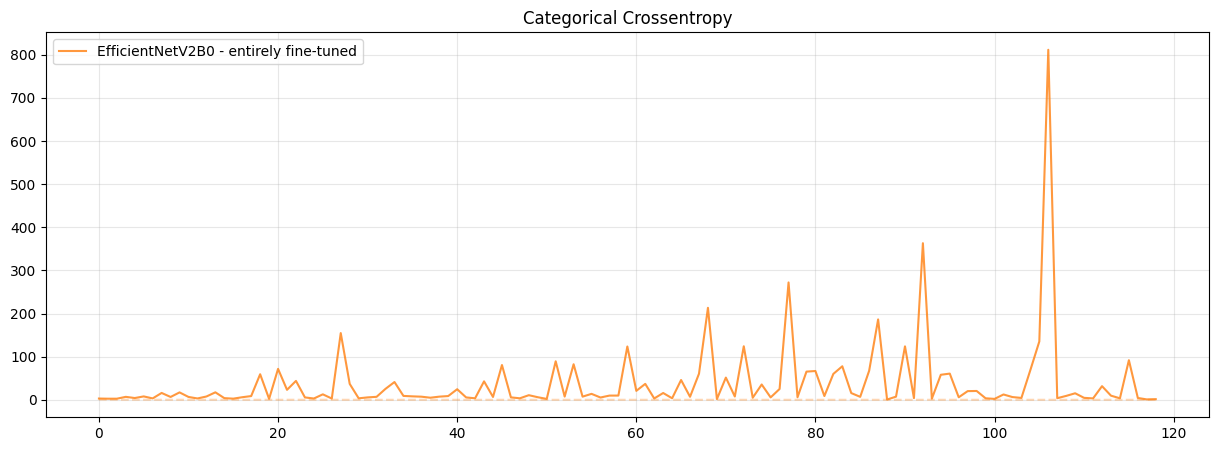

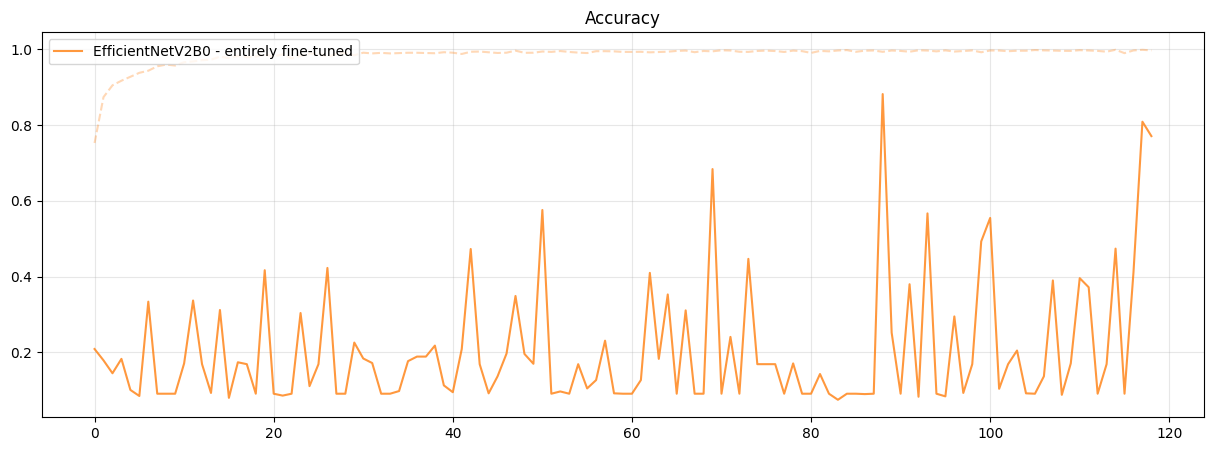

In [ ]:
# Plot the results of the run
plot_histories([history_finetuning3], ['EfficientNetV2B0 - entirely fine-tuned'])

Wow! The validation loss is all over the place! Even the second-smallest model is too complex for our dataset. Now that we know that scale worsens performance, we will try new approaches that involve simpler models.


### Measuring data augmentation effect on simple CNN






Let's start by assessing the impact of the main transformations on the given dataset.

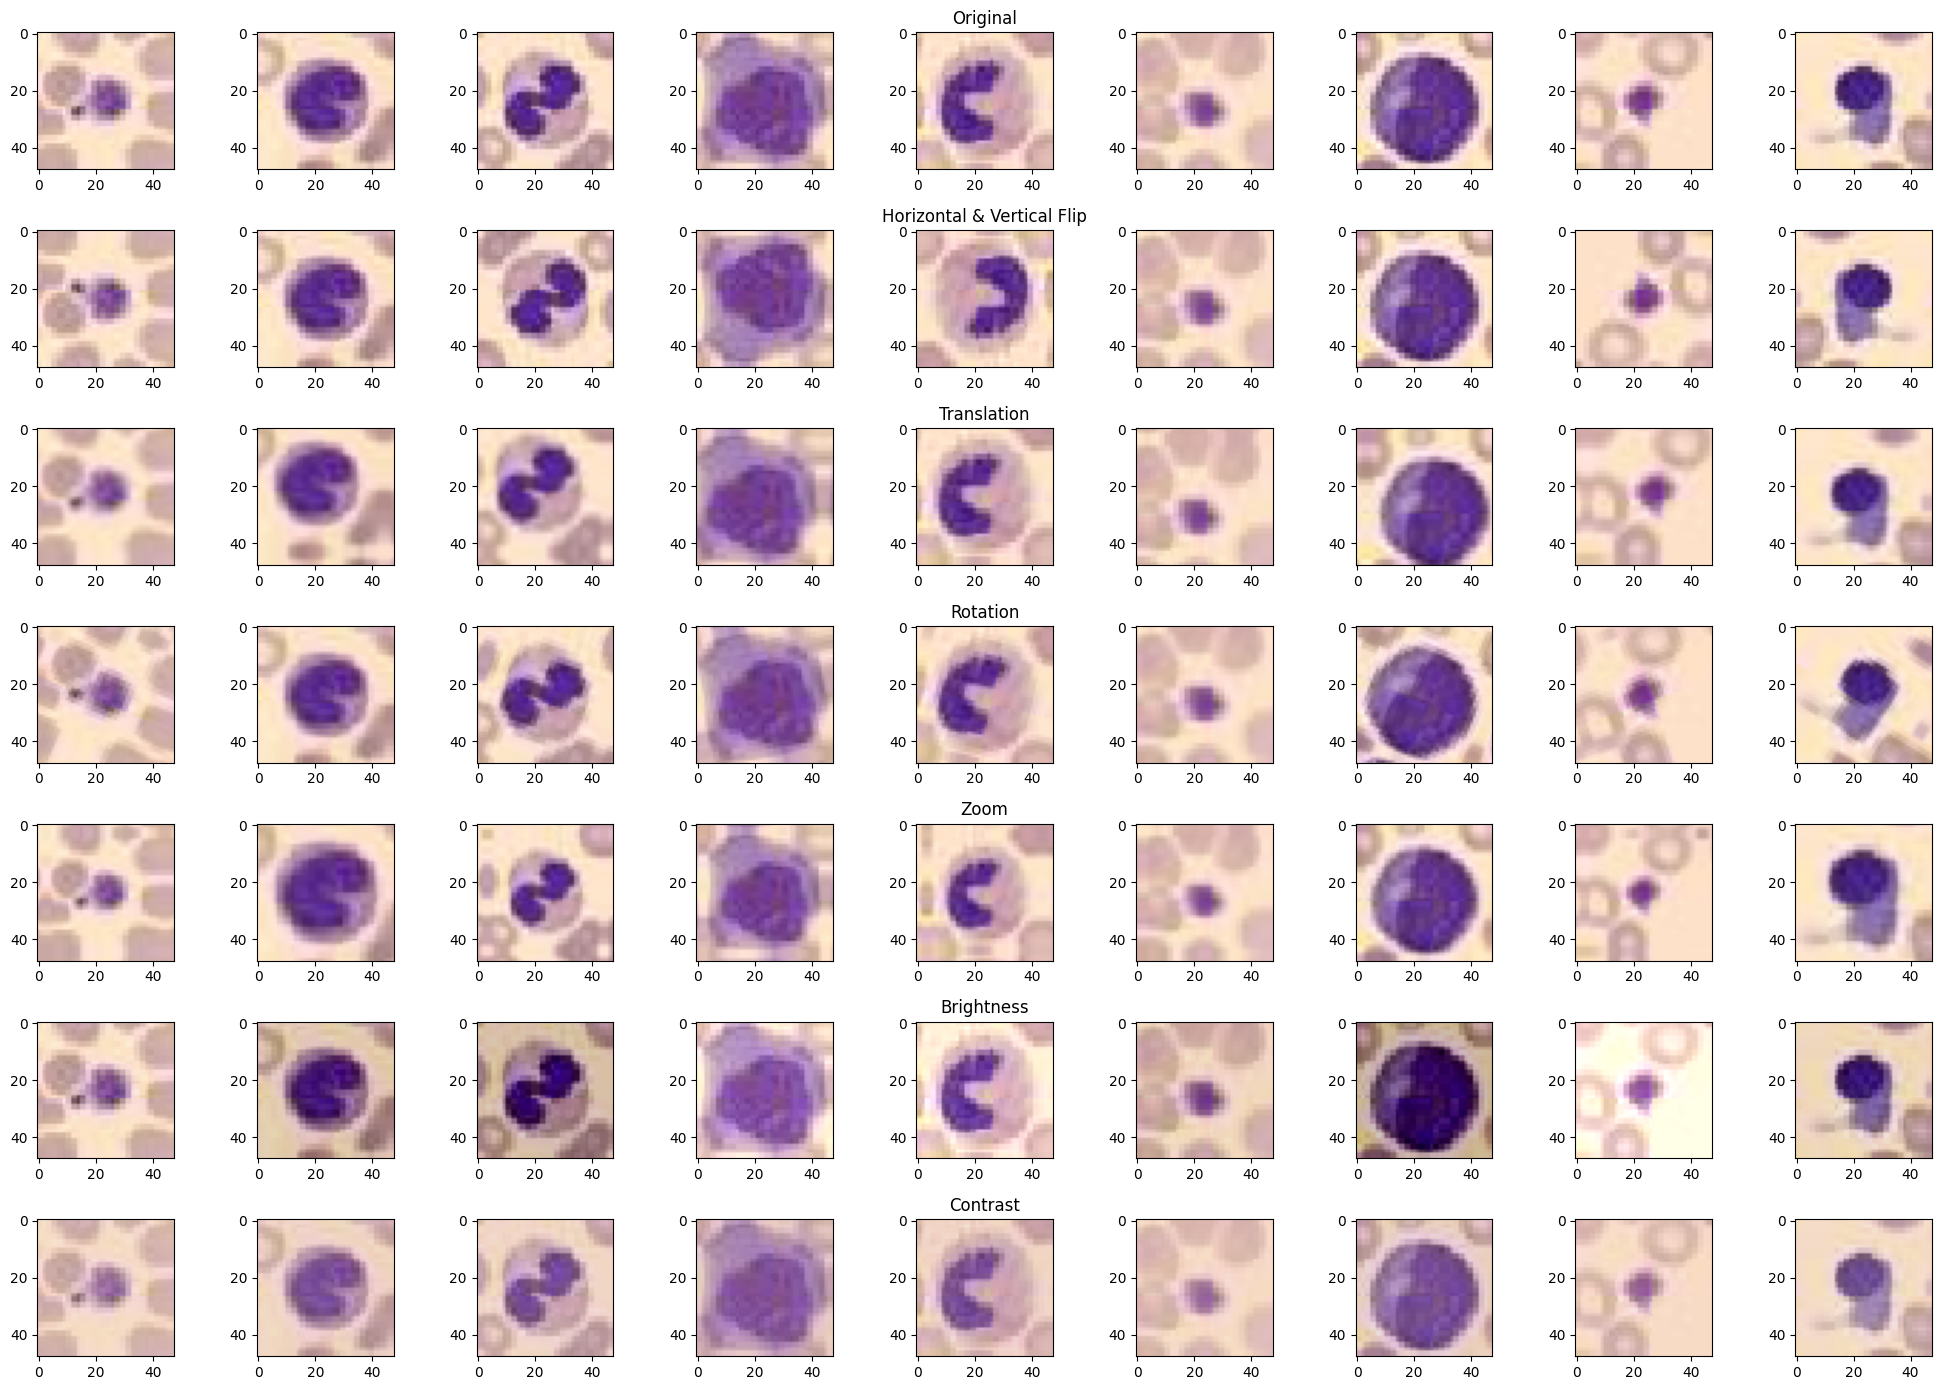

In [ ]:
def plot_transf_effect(transformations, X_train=X_train, num_img=9):
    fig, axes = plt.subplots(len(transformations) + 1, num_img, figsize=(20, 2 * (len(transformations) + 1)))

    X_train_plot = X_train[:num_img]

    # Plot original images
    for i in range(num_img):
        ax = axes[0, i]
        ax.imshow(X_train_plot[i])
        if i == num_img//2:
            ax.set_title('Original')

    # Plot transformed images
    for idx, (transformation, label) in enumerate(transformations):
        X_train_transf = transformation(X_train_plot)
        for i in range(num_img):
            ax = axes[idx + 1, i % num_img]
            ax.imshow(X_train_transf[i])
            if i == num_img//2:
                ax.set_title(label)

    plt.tight_layout()
    plt.show()

# Transformations
flip = tfk.Sequential([tfkl.RandomFlip("horizontal_and_vertical")]), 'Horizontal & Vertical Flip'
translation = tfk.Sequential([tfkl.RandomTranslation(0.1, 0.1)]), 'Translation'
rotation = tfk.Sequential([tfkl.RandomRotation(0.1)]), 'Rotation'
zoom = tfk.Sequential([tfkl.RandomZoom(0.2)]), 'Zoom'
brightness = tfk.Sequential([tfkl.RandomBrightness(0.2, value_range=(0,1))]), 'Brightness'
contrast = tf.keras.Sequential([tfkl.RandomContrast(0.75)]), 'Contrast'

transformations = [flip, translation, rotation, zoom, brightness, contrast]

# Plot
plot_transf_effect(transformations)

These data augmentation steps can be useful to prevent overfitting during training and, in general, to build a more robust model. All the transformations seem valid, except the zoom one. We saw from our data exploration that each cell type has a specific diameter distribution, and zooming in or out could alter the representation of the cell in our neural network. Therefore, we will leave it out.

We will test the effect of the data augmentation steps on the neural network training. As a benchmark, let's consider a simple CNN with a combination of Convolutional layers and Max Pooling operations but no data augmentation.

In [ ]:
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
]

In [ ]:
def build_vanilla_CNN(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = conv_bn_block(x=input_layer, filters=32, kernel_size=3, downsample=False, stack=1, name='0')
    x = conv_bn_block(x=x, filters=64, kernel_size=3, downsample=True, stack=1 , name='1')
    x = conv_bn_block(x=x, filters=128, kernel_size=3, downsample=True, stack=1, name='2')
    x = conv_bn_block(x=x, filters=256, kernel_size=3, downsample=True, stack=1, name='3')
    x = conv_bn_block(x=x, filters=512, kernel_size=3, downsample=True, stack=1, name='4')

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    output_layer = tfkl.Dense(output_shape, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
vanilla_cnn = build_vanilla_CNN()
vanilla_cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 Conv_01 (Conv2D)            (None, 48, 48, 32)        896       
                                                                 
 Activation_01 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 24, 24, 32)        0         
                                                                 
 Conv_11 (Conv2D)            (None, 24, 24, 64)        18496     
                                                                 
 Activation_11 (Activation)  (None, 24, 24, 64)        0         
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 12, 12, 64)        0       

In [ ]:
# Train the model
vanilla_cnn_hist = vanilla_cnn.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 300,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/300
197/197 [==============================] - 15s 16ms/step - loss: 1.2576 - accuracy: 0.5138 - val_loss: 0.7485 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 2/300
197/197 [==============================] - 2s 12ms/step - loss: 0.6106 - accuracy: 0.7656 - val_loss: 0.4869 - val_accuracy: 0.8170 - lr: 0.0010
Epoch 3/300
197/197 [==============================] - 2s 12ms/step - loss: 0.4877 - accuracy: 0.8165 - val_loss: 0.5155 - val_accuracy: 0.8180 - lr: 0.0010
Epoch 4/300
197/197 [==============================] - 2s 11ms/step - loss: 0.4289 - accuracy: 0.8403 - val_loss: 0.4279 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 5/300
197/197 [==============================] - 2s 12ms/step - loss: 0.3870 - accuracy: 0.8574 - val_loss: 0.3296 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 6/300
197/197 [==============================] - 2s 13ms/step - loss: 0.3345 - accuracy: 0.8766 - val_loss: 0.3404 - val_accuracy: 0.8590 - lr: 0.0010
Epoch 7/300
197/197 [==============================] - 2s

In [ ]:
vanilla_cnn.save('Vanilla_CNN')

# Save the history
# with open('history_vanilla_cnn.pickle', 'wb') as handle:
#     pickle.dump(vanilla_cnn_hist, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_vanilla_cnn.pickle', 'rb') as handle:
    vanilla_cnn_hist = pickle.load(handle)

Let's look at how data augmentation affects CNN's performance. We're adding the transformations that were deemed significant (i.e., RandomBrightness, RandomFlip, RandomTranslation, RandomRotation, RandomContrast) one at a time. If they improve performance, we retain them; otherwise, we don't.

In [ ]:
#Data Augmentation with RandomBrightness Transformation
tf.random.set_seed(seed)
preprocessing_1 = tf.keras.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(0,1)),
    ], name='preprocessing')

In [ ]:
def build_model_with_augmentation(preprocessing, input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = conv_bn_block(preprocessing, filters=32, kernel_size=3, downsample=False, stack=1, name='0')
    x = conv_bn_block(x, filters=64, kernel_size=3, downsample=True, stack=1 , name='1')
    x = conv_bn_block(x, filters=128, kernel_size=3, downsample=True, stack=1, name='2')
    x = conv_bn_block(x, filters=256, kernel_size=3, downsample=True, stack=1, name='3')
    x = conv_bn_block(x, filters=512, kernel_size=3, downsample=True, stack=1, name='4')

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(output_shape, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
cnn_aug_1 = build_model_with_augmentation(preprocessing_1)
#cnn_aug.summary()

In [ ]:
# Train the model
aug_cnn_hist_1 = cnn_aug_1.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 300,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/300
197/197 [==============================] - 5s 14ms/step - loss: 1.3400 - accuracy: 0.4730 - val_loss: 0.8161 - val_accuracy: 0.6790 - lr: 0.0010
Epoch 2/300
197/197 [==============================] - 3s 15ms/step - loss: 0.6772 - accuracy: 0.7370 - val_loss: 0.5669 - val_accuracy: 0.7570 - lr: 0.0010
Epoch 3/300
197/197 [==============================] - 3s 13ms/step - loss: 0.5579 - accuracy: 0.7893 - val_loss: 0.6506 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 4/300
197/197 [==============================] - 2s 11ms/step - loss: 0.4903 - accuracy: 0.8176 - val_loss: 0.4787 - val_accuracy: 0.8320 - lr: 0.0010
Epoch 5/300
197/197 [==============================] - 2s 11ms/step - loss: 0.4288 - accuracy: 0.8387 - val_loss: 0.3635 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 6/300
197/197 [==============================] - 2s 11ms/step - loss: 0.3757 - accuracy: 0.8596 - val_loss: 0.3733 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 7/300
197/197 [==============================] - 3s 

In [ ]:
cnn_aug_1.save('CNN_Data_Aug_1')

# Save the history
# with open('history_cnn_aug_1.pickle', 'wb') as handle:
#     pickle.dump(aug_cnn_hist_1, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_cnn_aug_1.pickle', 'rb') as handle:
    aug_cnn_hist_1 = pickle.load(handle)

The RandomBrightness does not improve our performance (but rather, it decreases it). Therefore, we can discard it from the basket of transformations.


In [ ]:
#Data Augmentation with RandomFlip Transformation
tf.random.set_seed(seed)
preprocessing_2 = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal_and_vertical"),
    ], name='preprocessing')

cnn_aug_2 = build_model_with_augmentation(preprocessing_2)

In [ ]:
# Train the model
aug_cnn_hist_2 = cnn_aug_2.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 300,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/300
197/197 [==============================] - 9s 23ms/step - loss: 1.3626 - accuracy: 0.4673 - val_loss: 0.8898 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 2/300
197/197 [==============================] - 3s 15ms/step - loss: 0.7186 - accuracy: 0.7237 - val_loss: 0.5393 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 3/300
197/197 [==============================] - 3s 14ms/step - loss: 0.5376 - accuracy: 0.7976 - val_loss: 0.4734 - val_accuracy: 0.8180 - lr: 0.0010
Epoch 4/300
197/197 [==============================] - 2s 12ms/step - loss: 0.4658 - accuracy: 0.8267 - val_loss: 0.4075 - val_accuracy: 0.8570 - lr: 0.0010
Epoch 5/300
197/197 [==============================] - 2s 11ms/step - loss: 0.3954 - accuracy: 0.8547 - val_loss: 0.3402 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 6/300
197/197 [==============================] - 4s 21ms/step - loss: 0.3755 - accuracy: 0.8606 - val_loss: 0.3447 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 7/300
197/197 [==============================] - 3s 

In [ ]:
#cnn_aug_2.save('CNN_Data_Aug_2')

# Save the history
# with open('history_cnn_aug_2.pickle', 'wb') as handle:
#     pickle.dump(aug_cnn_hist_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_cnn_aug_2.pickle', 'rb') as handle:
    aug_cnn_hist_2 = pickle.load(handle)

The RandomFlip transformation clearly contributes to improving the perfomance: we will keep it!

In [ ]:
#Data Augmentation with RandomFlip and RandomTranslation Transformations
tf.random.set_seed(seed)
preprocessing_3 = tf.keras.Sequential([
        tfkl.RandomTranslation(0.1,0.1),
        tfkl.RandomFlip("horizontal_and_vertical"),
    ], name='preprocessing')

cnn_aug_3 = build_model_with_augmentation(preprocessing_3)

In [ ]:
# Train the model
aug_cnn_hist_3 = cnn_aug_3.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 300,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/300
197/197 [==============================] - 5s 13ms/step - loss: 1.4455 - accuracy: 0.4208 - val_loss: 1.1221 - val_accuracy: 0.5390 - lr: 0.0010
Epoch 2/300
197/197 [==============================] - 2s 12ms/step - loss: 0.9398 - accuracy: 0.6260 - val_loss: 0.6452 - val_accuracy: 0.7490 - lr: 0.0010
Epoch 3/300
197/197 [==============================] - 3s 14ms/step - loss: 0.6536 - accuracy: 0.7532 - val_loss: 0.5003 - val_accuracy: 0.8090 - lr: 0.0010
Epoch 4/300
197/197 [==============================] - 3s 13ms/step - loss: 0.5453 - accuracy: 0.7892 - val_loss: 0.5111 - val_accuracy: 0.8170 - lr: 0.0010
Epoch 5/300
197/197 [==============================] - 2s 12ms/step - loss: 0.4739 - accuracy: 0.8220 - val_loss: 0.4660 - val_accuracy: 0.8180 - lr: 0.0010
Epoch 6/300
197/197 [==============================] - 2s 12ms/step - loss: 0.4338 - accuracy: 0.8401 - val_loss: 0.3430 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 7/300
197/197 [==============================] - 2s 

In [ ]:
cnn_aug_3.save('CNN_Data_Aug_3')

# Save the history
# with open('history_cnn_aug_3.pickle', 'wb') as handle:
#     pickle.dump(aug_cnn_hist_3, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_cnn_aug_3.pickle', 'rb') as handle:
    aug_cnn_hist_3 = pickle.load(handle)

The results of applying the RandomTranslation layer are a bit ambiguous: on the one hand, the model's accuracy is slightly poorer, but it is overfitting less. Perhaps a longer run might yield a better result? Another strong factor in favour of this transformation is that the categorical cross-entropy loss is substantially lower, so we'll keep it for the moment.

In [ ]:
#Data Augmentation with RandomFlip, RandomTranslation and RandomRotation Transformations
tf.random.set_seed(seed)
preprocessing_4 = tf.keras.Sequential([
        tfkl.RandomTranslation(0.1,0.1),
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomRotation(0.1),
    ], name='preprocessing')

cnn_aug_4 = build_model_with_augmentation(preprocessing_4)

In [ ]:
# Train the model
aug_cnn_hist_4 = cnn_aug_4.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 300,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/300
197/197 [==============================] - 5s 14ms/step - loss: 1.3619 - accuracy: 0.4575 - val_loss: 1.0307 - val_accuracy: 0.6090 - lr: 0.0010
Epoch 2/300
197/197 [==============================] - 3s 13ms/step - loss: 0.7998 - accuracy: 0.6883 - val_loss: 0.6794 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 3/300
197/197 [==============================] - 3s 15ms/step - loss: 0.6195 - accuracy: 0.7603 - val_loss: 0.4975 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 4/300
197/197 [==============================] - 3s 13ms/step - loss: 0.5045 - accuracy: 0.8105 - val_loss: 0.4729 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 5/300
197/197 [==============================] - 2s 12ms/step - loss: 0.4582 - accuracy: 0.8270 - val_loss: 0.4040 - val_accuracy: 0.8430 - lr: 0.0010
Epoch 6/300
197/197 [==============================] - 3s 13ms/step - loss: 0.4207 - accuracy: 0.8432 - val_loss: 0.3759 - val_accuracy: 0.8590 - lr: 0.0010
Epoch 7/300
197/197 [==============================] - 3s 

In [ ]:
# cnn_aug_4.save('CNN_Data_Aug_4')

# # Save the history
# with open('history_cnn_aug_4.pickle', 'wb') as handle:
#     pickle.dump(aug_cnn_hist_4, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_cnn_aug_4.pickle', 'rb') as handle:
    aug_cnn_hist_4 = pickle.load(handle)

The RandomRotation brings the validation loss even lower, and the validation accuracy remains very good at 97.5%.

In [ ]:
#Data Augmentation with RandomFlip, RandomTranslation,
#RandomRotation adn RandomContrast Transformations
tf.random.set_seed(seed)
preprocessing_5 = tf.keras.Sequential([
        tf.keras.Sequential([tfkl.RandomContrast(0.75)]),
        tfkl.RandomTranslation(0.1,0.1),
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomRotation(0.1),
    ], name='preprocessing')

cnn_aug_5 = build_model_with_augmentation(preprocessing_5)

In [ ]:
# Train the model
aug_cnn_hist_5 = cnn_aug_5.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 300,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/300
197/197 [==============================] - 5s 15ms/step - loss: 1.6603 - accuracy: 0.3639 - val_loss: 1.1300 - val_accuracy: 0.5790 - lr: 0.0010
Epoch 2/300
197/197 [==============================] - 3s 15ms/step - loss: 1.1562 - accuracy: 0.5623 - val_loss: 0.9452 - val_accuracy: 0.6680 - lr: 0.0010
Epoch 3/300
197/197 [==============================] - 3s 16ms/step - loss: 1.0278 - accuracy: 0.6159 - val_loss: 0.8419 - val_accuracy: 0.6490 - lr: 0.0010
Epoch 4/300
197/197 [==============================] - 3s 13ms/step - loss: 0.7922 - accuracy: 0.6912 - val_loss: 0.8087 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 5/300
197/197 [==============================] - 3s 14ms/step - loss: 0.7617 - accuracy: 0.7019 - val_loss: 0.5495 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 6/300
197/197 [==============================] - 3s 14ms/step - loss: 0.6178 - accuracy: 0.7571 - val_loss: 0.4659 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 7/300
197/197 [==============================] - 3s 

In [ ]:
#cnn_aug_5.save('CNN_Data_Aug_5')

# Save the history
# with open('history_cnn_aug_5.pickle', 'wb') as handle:
#     pickle.dump(aug_cnn_hist_5, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_cnn_aug_5.pickle', 'rb') as handle:
    aug_cnn_hist_5 = pickle.load(handle)

The RandomContrast transformation is not the best. So, we chose not to use it.

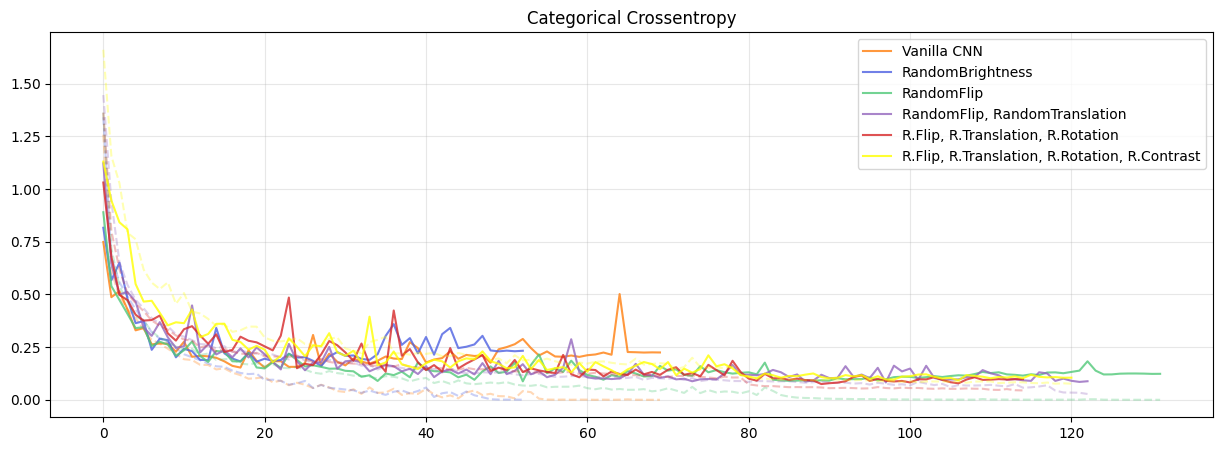

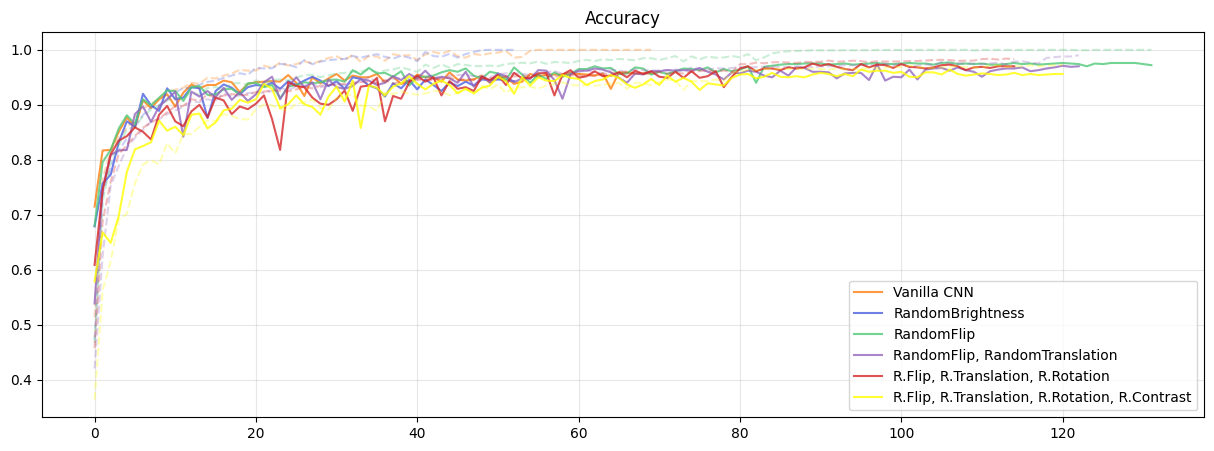

In [ ]:
plot_histories([vanilla_cnn_hist, aug_cnn_hist_1, aug_cnn_hist_2, aug_cnn_hist_3, aug_cnn_hist_4, aug_cnn_hist_5],
 ['Vanilla CNN', 'RandomBrightness', 'RandomFlip', 'RandomFlip, RandomTranslation',
  'R.Flip, R.Translation, R.Rotation', 'R.Flip, R.Translation, R.Rotation, R.Contrast'], 'best')

The model with only R.Flip as augmentation is performing the best in terms of accuracy, while the model with R.Flip, R.Translation and R.Rotation reaches the lowest loss and overfits less.

Accuracy: 0.9533 

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       107
           1       1.00      1.00      1.00       273
           2       0.98      0.95      0.96       136
           3       0.89      0.92      0.90       254
           4       0.94      0.96      0.95       107
           5       0.96      0.81      0.88       125
           6       0.98      0.97      0.97       292
           7       1.00      1.00      1.00       206

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.96      0.95      0.95      1500
 



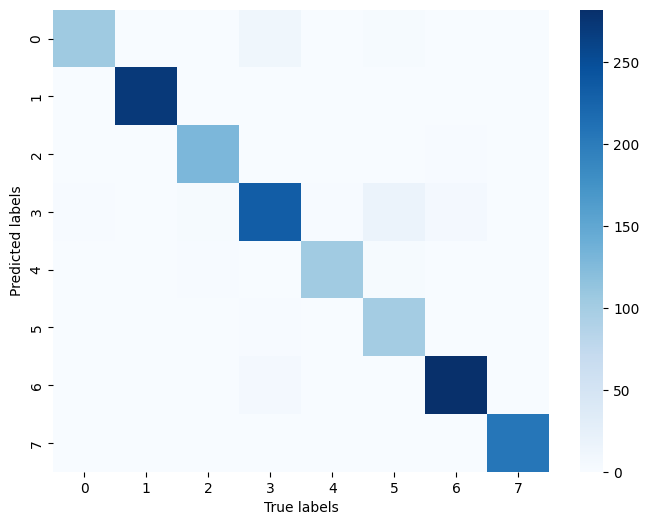

In [ ]:
assess_performance('CNN_Data_Aug_4', X_test, y_test)

### Combining data augmentation + fine-tuning - MobileNetV2

Even though we noticed a better performance with smaller models, it would be interesting to understand how data augmentation affects pre-trained models.

In [ ]:
# Train all the parameters on top of ImageNet weights
mobile = tfk.applications.MobileNetV2(
    input_shape=(48, 48, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

tf.random.set_seed(seed)

# Create an input layer with shape (48, 48, 3)
inputs = tfk.Input(shape=(48, 48, 3))
# Add data augmentation step
preprocessing = tf.keras.Sequential([
        tfkl.RandomTranslation(0.1,0.1),
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomRotation(0.1),
    ], name='preprocessing')
preprocessing = preprocessing(inputs)
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a dropout layer with 50% dropout rate
x = tfkl.Dropout(0.5)(x)
# Add a Dense layer with 8 units and softmax activation as the classifier
outputs = tfkl.Dense(8, activation='softmax')(x)

# Create a Model connecting input and output
model_finetuning4 = tfk.Model(inputs=inputs, outputs=outputs, name='finetuning4_model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model_finetuning4.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Train the model
history_finetuning4 = model_finetuning4.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)]
).history

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/200
197/197 [==============================] - 39s 55ms/step - loss: 0.6253 - accuracy: 0.7950 - val_loss: 9.2412 - val_accuracy: 0.4520
Epoch 2/200
197/197 [==============================] - 8s 41ms/step - loss: 0.2873 - accuracy: 0.9044 - val_loss: 13.6088 - val_accuracy: 0.3510
Epoch 3/200
197/197 [==============================] - 8s 42ms/step - loss: 0.2088 - accuracy: 0.9312 - val_loss: 12.8374 - val_accuracy: 0.3870
Epoch 4/200
197/197 [==============================] - 8s 40ms/step - loss: 0.1657 - accuracy: 0.9466 - val_loss: 14.2868 - val_accuracy: 0.3860
Epoch 5/200
197/197 [==============================] - 8s 41ms/step - loss: 0.1374 - accuracy: 0.9546 - val_loss: 18.6779 - val_accuracy: 0.3180
Epoch 6/200
197/197 [==============================] - 8s 39ms/step - loss: 0.1173 - accuracy: 0.9609 - val_loss: 15.0476 - val_accuracy: 0.3250
Epoch 7/200
197/197 [==============================] - 8s 41ms/step

In [ ]:
# Save the history
# with open('history_finetuning4.pickle', 'wb') as handle:
#     pickle.dump(history_finetuning4, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_finetuning4.pickle', 'rb') as handle:
    history_finetuning4 = pickle.load(handle)

As expected, our pretrained model is performing better after adding some data augmentation, but still underperforms simpler models. For this reason, we will redirect our attention to smaller models.

### Smaller models - ResNet

After understanding how superior smaller models can be to pretrained models, we now try to understand which architecture can perform better. In order to train our models faster, we use raw data without data augmentation. After crowning the winner, we will introduce the powerful boost.

Here we try ResNet, slightly adjusting the original architecture according to our needs. We will take our vanilla CNN and introduce skip connections - finally celebrating the name of our group!

In [ ]:
def build_resnet(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = conv_bn_block(x=input_layer, filters=32, kernel_size=3, downsample=False, stack=1, batch_norm=True, name='0')
    x = conv_residual_block(x=x, filters=64, kernel_size=3, downsample=True, stack=1, batch_norm=True, name='1')
    x = conv_residual_block(x=x, filters=128, kernel_size=3, downsample=True, stack=1, batch_norm=True, name='2')
    x = conv_residual_block(x=x, filters=256, kernel_size=3, downsample=True, stack=1, batch_norm=True, name='3')
    x = conv_residual_block(x=x, filters=512, kernel_size=3, downsample=True, stack=1, batch_norm=True, name='4')

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    output_layer = tfkl.Dense(output_shape, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='ResNet')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
# Create the model
small_resnet = build_resnet()

In [ ]:
# Train the model
history_resnet = small_resnet.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
        tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
        ]
).history

Epoch 1/200
197/197 [==============================] - 31s 31ms/step - loss: 0.5405 - accuracy: 0.8258 - val_loss: 12.2608 - val_accuracy: 0.1370 - lr: 0.0010
Epoch 2/200
197/197 [==============================] - 4s 22ms/step - loss: 0.2684 - accuracy: 0.9022 - val_loss: 5.7059 - val_accuracy: 0.1700 - lr: 0.0010
Epoch 3/200
197/197 [==============================] - 3s 17ms/step - loss: 0.2007 - accuracy: 0.9287 - val_loss: 0.8391 - val_accuracy: 0.7170 - lr: 0.0010
Epoch 4/200
197/197 [==============================] - 3s 17ms/step - loss: 0.1591 - accuracy: 0.9448 - val_loss: 0.7413 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 5/200
197/197 [==============================] - 4s 18ms/step - loss: 0.1393 - accuracy: 0.9481 - val_loss: 0.4058 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 6/200
197/197 [==============================] - 4s 20ms/step - loss: 0.1084 - accuracy: 0.9619 - val_loss: 1.1572 - val_accuracy: 0.7330 - lr: 0.0010
Epoch 7/200
197/197 [==============================] - 3

In [ ]:
# Save the history
# with open('history_resnet.pickle', 'wb') as handle:
#     pickle.dump(history_resnet, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_resnet.pickle', 'rb') as handle:
    history_resnet = pickle.load(handle)

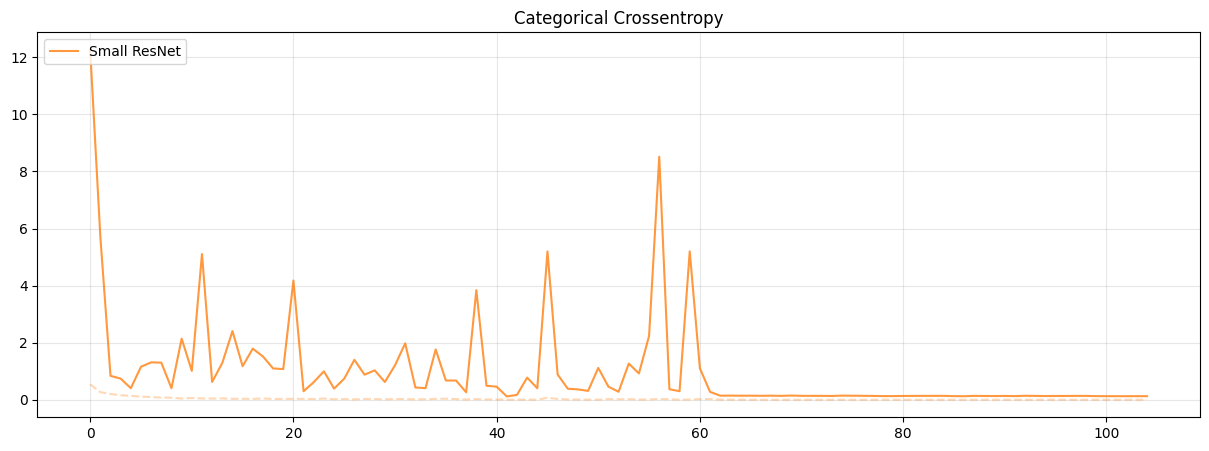

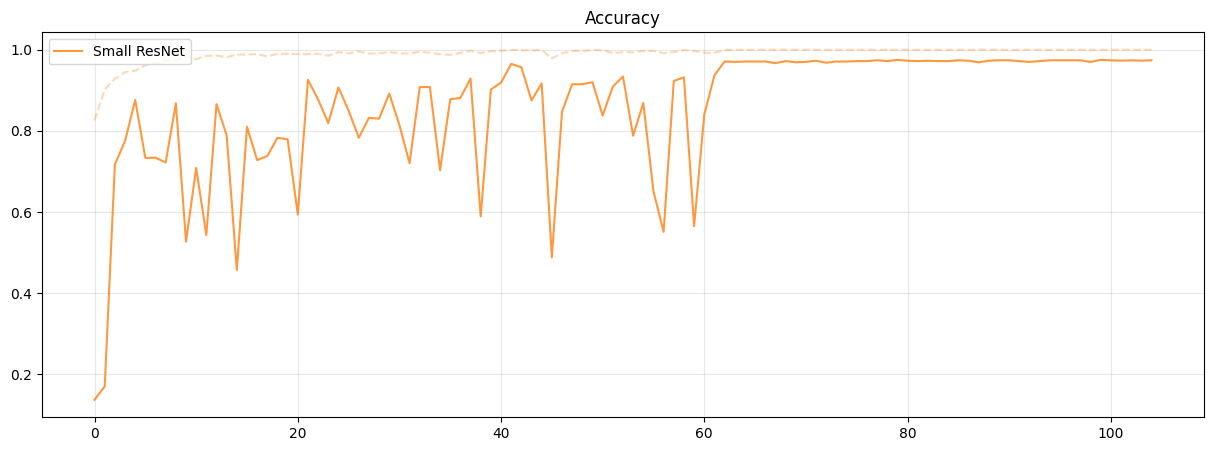

In [ ]:
# Plot the results of the run
plot_histories([history_resnet], ['Small ResNet'])

In [ ]:
# Save the model
# small_resnet.save('SmallResNet')

There is not much to say here other that we are really impressed with the performance.
We are not yet using test data because we want to compare this model to the others first.

### Smaller models - DenseNet

This is a tricky one: we reproduced the original architecture, but with some slight modifications. The number of parameters is a bit lower than in the previous ResNet.

In [ ]:
def build_densenet(input_shape=input_shape, output_shape=output_shape, k = 32):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #here we deviate from the paper by setting the first kernel size = 3 instead of 7, and pool size = 2 instead of 3
    x0 = conv_bn_block(x=input_layer, filters=k, kernel_size=3, downsample=False, stack=1, batch_norm=True, name='0')
    x0 = tfkl.MaxPooling2D(pool_size = 2, name='MaxPool_0')(x0)

    x1 = dense_block(x=x0, filters=k, kernel_size=3, stack=6, batch_norm=True, name='1')

    x2 = conv_bn_block(x=x1, filters=k, kernel_size=1, downsample=False, stack=4, batch_norm=True, name='2')
    x2 = tfkl.MaxPooling2D(strides = 2, name='MaxPool_1')(x2)

    x3 = dense_block(x=x2, filters=k, kernel_size=3, stack=9, batch_norm=True, name='3')

    x4 = conv_bn_block(x=x3, filters=k, kernel_size=1, downsample=False, stack=1, batch_norm=True, name='4')
    x4 = tfkl.MaxPooling2D(strides = 2, name='MaxPool_2')(x4)

    x5 = dense_block(x=x4, filters=k, kernel_size=3, stack=12, batch_norm=True, name='5')

    # x6 = conv_bn_block(x=x5, filters=k, kernel_size=1, downsample=False, stack=16, batch_norm=True, name='6')
    # x6 = tfkl.MaxPooling2D(strides = 2, name='MaxPool_3')(x6)

    # x7 = dense_block(x=x6, filters=k, kernel_size=3, stack=16, batch_norm=True, name='7')

    x8 = tfkl.GlobalAveragePooling2D(name='gap')(x5)
    output_layer = tfkl.Dense(output_shape, activation='softmax',name='Output')(x8)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='DenseNet')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
# Create the model
small_densenet = build_densenet(k = 32)
print(f"Parameters of the small ResNet: {small_resnet.count_params()}, parameters of the small DenseNet: {small_densenet.count_params()}")

Parameters of the small ResNet: 1751688, parameters of the small DenseNet: 1384808


In [ ]:
# Train the model
history_densenet = small_densenet.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
        tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
        ]
).history

Epoch 1/200
197/197 [==============================] - 79s 75ms/step - loss: 0.4999 - accuracy: 0.8147 - val_loss: 10.5656 - val_accuracy: 0.1370 - lr: 0.0010
Epoch 2/200
197/197 [==============================] - 12s 61ms/step - loss: 0.3133 - accuracy: 0.8848 - val_loss: 2.1926 - val_accuracy: 0.4340 - lr: 0.0010
Epoch 3/200
197/197 [==============================] - 11s 55ms/step - loss: 0.2577 - accuracy: 0.9077 - val_loss: 2.4463 - val_accuracy: 0.4910 - lr: 0.0010
Epoch 4/200
197/197 [==============================] - 11s 55ms/step - loss: 0.2180 - accuracy: 0.9215 - val_loss: 0.7463 - val_accuracy: 0.7410 - lr: 0.0010
Epoch 5/200
197/197 [==============================] - 11s 54ms/step - loss: 0.1959 - accuracy: 0.9322 - val_loss: 0.3124 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 6/200
197/197 [==============================] - 10s 53ms/step - loss: 0.1689 - accuracy: 0.9417 - val_loss: 1.3646 - val_accuracy: 0.6570 - lr: 0.0010
Epoch 7/200
197/197 [==============================

In [ ]:
# Save the history
# with open('history_densenet.pickle', 'wb') as handle:
#     pickle.dump(history_densenet, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_densenet.pickle', 'rb') as handle:
    history_densenet = pickle.load(handle)

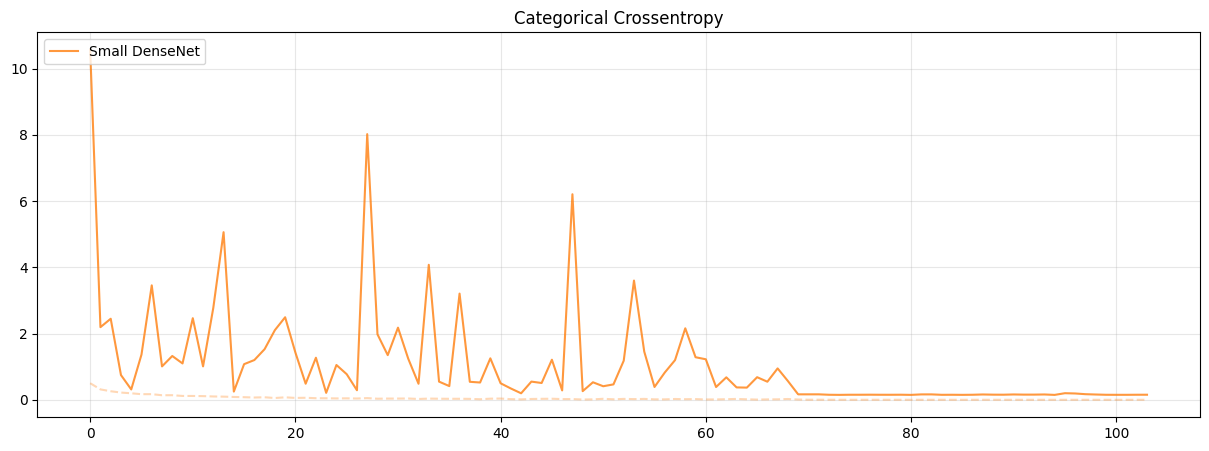

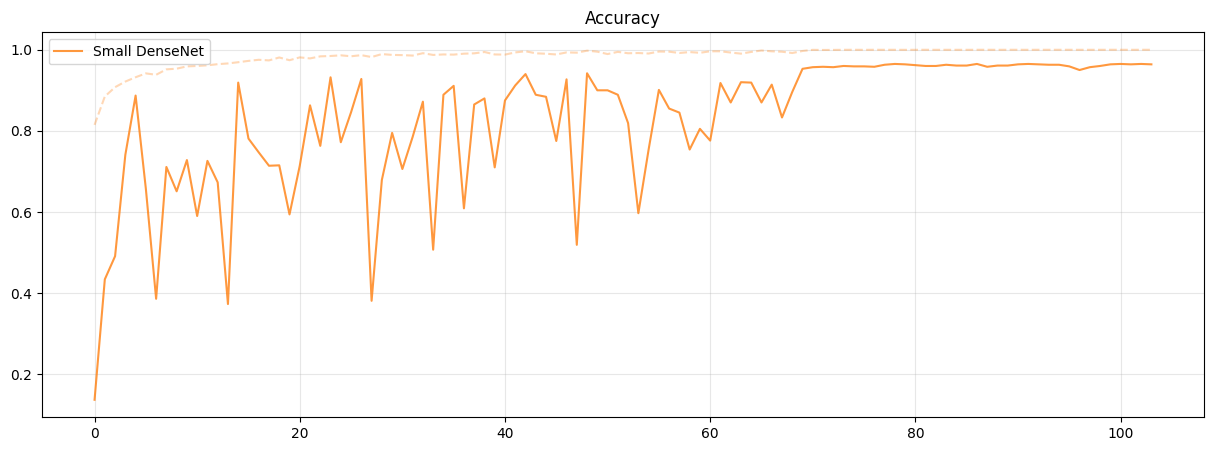

In [ ]:
# Plot the results of the run
plot_histories([history_densenet], ['Small DenseNet'])

In [ ]:
# Save the model
# small_densenet.save('SmallDenseNet')

Also here, the validation loss is very bumpy before reaching stable convergence. The performance is worse than the ResNet one, so we can discard this model.

### Smaller models - Vision Transformer

For the ViT implementation, we can follow the guide from Keras: https://keras.io/examples/vision/image_classification_with_vision_transformer/.

Since we already know how it works, we can shamelessly copy and paste from there. However, we also introduce some modifications, such as replacing the final dense head with a softmax and changing the hyperparameters to match the total count to around 1M.

In [ ]:
# Hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 200
image_size = 48
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [512, 256]  # Size of the dense layers of the final classifier

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tfkl.Dense(units, activation=tf.nn.gelu)(x)
        x = tfkl.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(tfkl.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
class PatchEncoder(tfkl.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = tfkl.Dense(units=projection_dim)
        self.position_embedding = tfkl.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = tfkl.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = tfkl.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = tfkl.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tfkl.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = tfkl.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = tfkl.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tfkl.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tfkl.Flatten()(representation)
    representation = tfkl.Dropout(0.5)(representation)
    # Classify outputs directly with softmax activation
    output_layer = tfkl.Dense(output_shape, activation='softmax',name='Output')(representation)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=output_layer, name='ViT')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

    return model

In [ ]:
vit = create_vit_classifier()
print(vit.count_params()) #the number of parameters is kept as roughly the same throughout the notebook: we can be happy.

1345416


In [ ]:
# Train the model
history_vit = vit.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
        tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
        ]
).history

In [ ]:
# Save the history
# with open('history_vit.pickle', 'wb') as handle:
#     pickle.dump(history_vit, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_vit.pickle', 'rb') as handle:
    history_vit = pickle.load(handle)

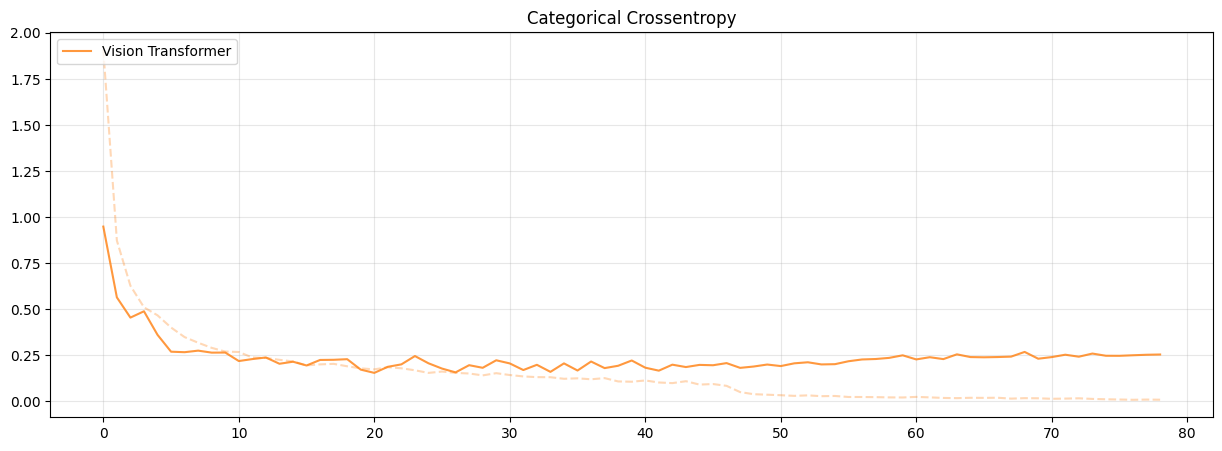

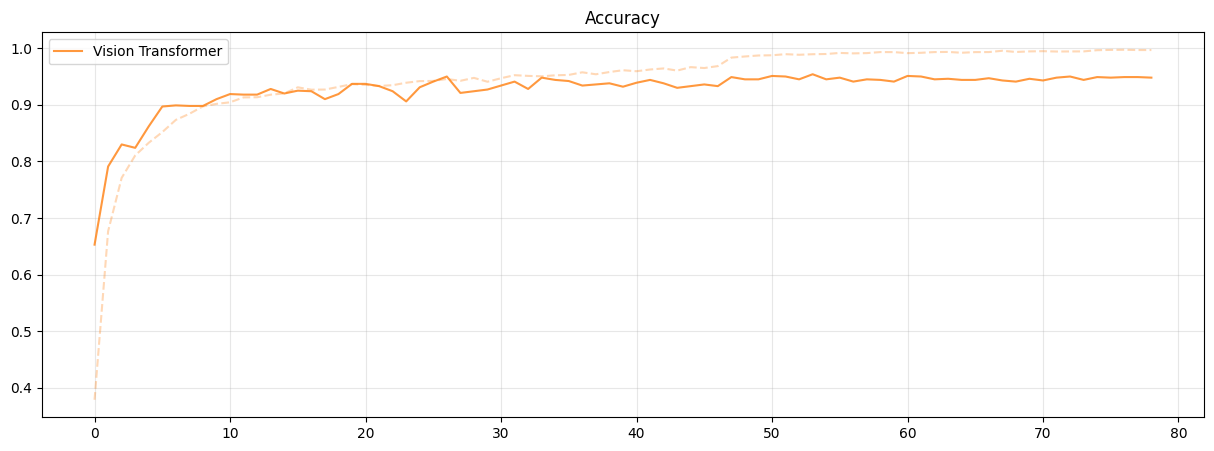

In [ ]:
# Plot the results of the run
plot_histories([history_vit], ['Vision Transformer'])

In [ ]:
# Save the model
# vit.save('VisionTransformer')

The ViT had the most stable training, but a slightly worse performance compared to the other small models. It is really impressive because it learns in a stable and rapid manner.

### Smaller models - InceptionResNetV2

Now, we present a reduced version of the InceptionResNetv2 model. In comparison to the original architecture, the model developed consists of only three Inception ResNet Block A rather than five and one Reduction Block A, while preserving the original model's filter sizes.

In [ ]:
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
]

In [ ]:
def build_inception_resnetv2(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Stem block
    x = conv_bn_block(input_layer, 32, 3, strides=2, padding='valid', batch_norm=True, name='Stem1')
    x = conv_bn_block(x, 32, 3, strides=1, padding='valid', batch_norm=True, name='Stem2')
    x = conv_bn_block(x, 64, 3, strides=1, padding='same', batch_norm=True, name='Stem3')

    # Inception-ResNet-A modules x3
    for i in range(3):
        x = inception_resnet_a(x, scale_residual=0.1, name='IncepResNetA_' + str(i + 1))

    # Reduction-A module
    x = reduction_a(x, name='ReductionA')

    # Global Average Pooling
    x = tfkl.GlobalAveragePooling2D(name='GlobalAvgPool')(x)

    # Fully connected layer
    x = tfkl.Dense(output_shape, activation='softmax', name='Output')(x)

    model = tfk.Model(inputs=input_layer, outputs=x, name='InceptionResNetv2')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

    return model


In [ ]:
inception_resnet = build_inception_resnetv2()
#inception_resnet.summary()

In [ ]:
# Train the model
history_incep_resnet = inception_resnet.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 300,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/300
197/197 [==============================] - 60s 205ms/step - loss: 0.5489 - accuracy: 0.8273 - val_loss: 6.1421 - val_accuracy: 0.0840 - lr: 0.0010
Epoch 2/300
197/197 [==============================] - 39s 199ms/step - loss: 0.3439 - accuracy: 0.8871 - val_loss: 8.3474 - val_accuracy: 0.1090 - lr: 0.0010
Epoch 3/300
197/197 [==============================] - 39s 200ms/step - loss: 0.2840 - accuracy: 0.9074 - val_loss: 0.6161 - val_accuracy: 0.7880 - lr: 0.0010
Epoch 4/300
197/197 [==============================] - 39s 199ms/step - loss: 0.2399 - accuracy: 0.9222 - val_loss: 0.3435 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 5/300
197/197 [==============================] - 40s 201ms/step - loss: 0.2238 - accuracy: 0.9256 - val_loss: 2.1658 - val_accuracy: 0.4460 - lr: 0.0010
Epoch 6/300
197/197 [==============================] - 39s 199ms/step - loss: 0.2000 - accuracy: 0.9332 - val_loss: 0.5768 - val_accuracy: 0.8050 - lr: 0.0010
Epoch 7/300
197/197 [=========================

In [ ]:
# Save the history
# with open('history_incep_resnet.pickle', 'wb') as handle:
#      pickle.dump(history_incep_resnet, handle, protocol=pickle.HIGHEST_PROTOCOL)

#Load the history
with open('history_incep_resnet.pickle', 'rb') as handle:
    history_incep_resnet = pickle.load(handle)

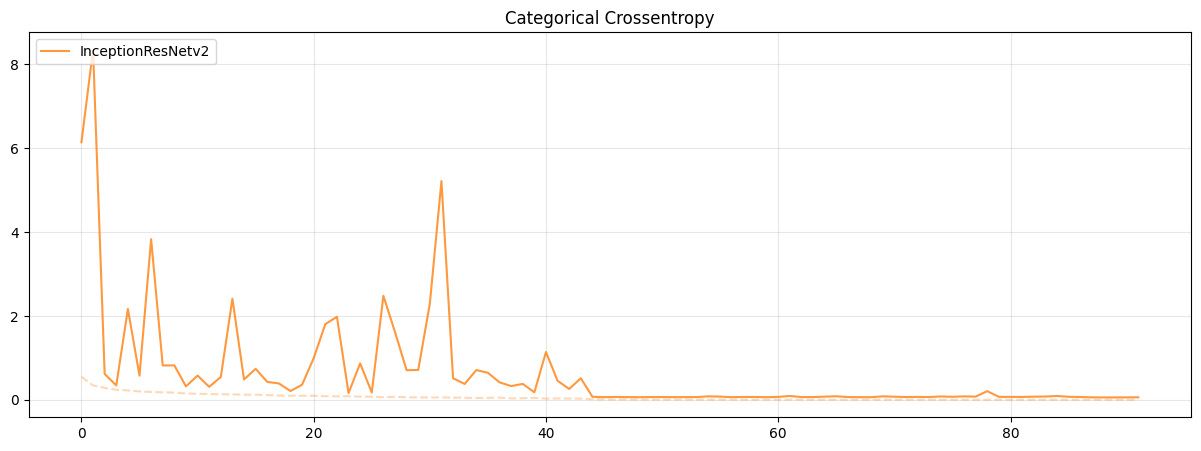

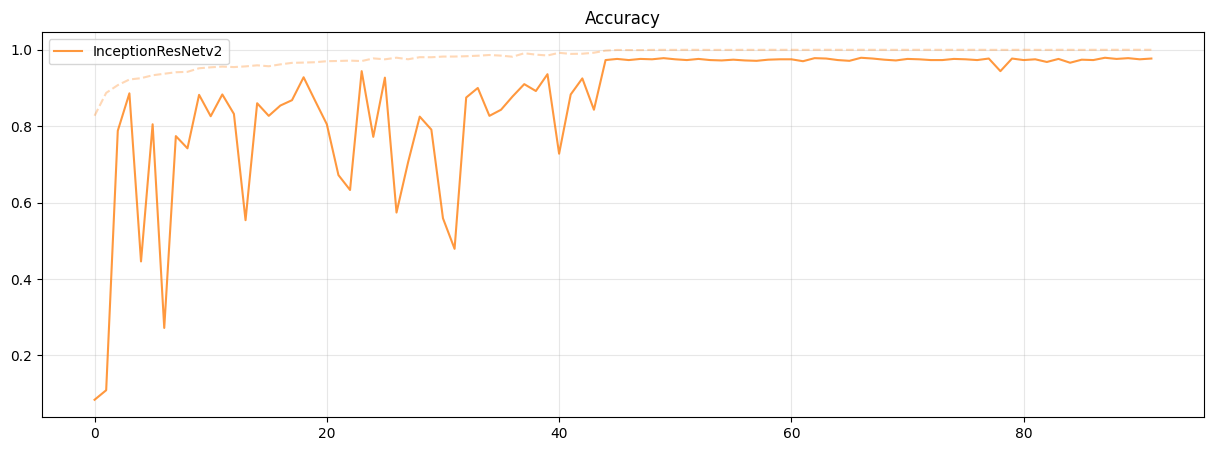

In [ ]:
plot_histories([history_incep_resnet], ['InceptionResNetv2'])

This model is the best-performing one for now. It is the fastest in reaching convergence, and it is the one with the highest validation accuracy at 97.9%.

### InceptionResNetV2 + data augmentation 1

Let's try now to squeeze our InceptionResNet as much as possible. Here we add the data augmentation (at first only the flip because the learning is less troublesome).

In [ ]:
def build_inception_resnetv2_aug(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Add data augmentation step
    preprocessing = tf.keras.Sequential([
            #tfkl.RandomTranslation(0.1,0.1),
            tfkl.RandomFlip("horizontal_and_vertical"),
            #tfkl.RandomRotation(0.1),
        ], name='preprocessing')
    preprocessing = preprocessing(input_layer)

    # Stem block
    x = conv_bn_block(preprocessing, 32, 3, strides=2, padding='valid', batch_norm=True, name='Stem1')
    x = conv_bn_block(x, 32, 3, strides=1, padding='valid', batch_norm=True, name='Stem2')
    x = conv_bn_block(x, 64, 3, strides=1, padding='same', batch_norm=True, name='Stem3')

    # Inception-ResNet-A modules x3
    for i in range(3):
        x = inception_resnet_a(x, scale_residual=0.1, name='IncepResNetA_' + str(i + 1))

    # Reduction-A module
    x = reduction_a(x, name='ReductionA')

    # Global Average Pooling
    x = tfkl.GlobalAveragePooling2D(name='GlobalAvgPool')(x)

    # Fully connected layer
    x = tfkl.Dense(output_shape, activation='softmax', name='Output')(x)

    model = tfk.Model(inputs=input_layer, outputs=x, name='InceptionResNetv2')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate = 3e-4), metrics=['accuracy'])

    return model

In [ ]:
# Create the model
inception_resnet_aug = build_inception_resnetv2_aug()

In [ ]:
# Train the model
history_inceptionresnet_aug = inception_resnet_aug.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 300,
    validation_data = (X_val, y_val),
    callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
]
).history

Epoch 1/300
197/197 [==============================] - 78s 223ms/step - loss: 0.6430 - accuracy: 0.8098 - val_loss: 3.5302 - val_accuracy: 0.2400 - lr: 3.0000e-04
Epoch 2/300
197/197 [==============================] - 37s 189ms/step - loss: 0.3925 - accuracy: 0.8850 - val_loss: 6.6389 - val_accuracy: 0.1040 - lr: 3.0000e-04
Epoch 3/300
197/197 [==============================] - 38s 195ms/step - loss: 0.3167 - accuracy: 0.9056 - val_loss: 0.9976 - val_accuracy: 0.6450 - lr: 3.0000e-04
Epoch 4/300
197/197 [==============================] - 38s 195ms/step - loss: 0.2765 - accuracy: 0.9122 - val_loss: 0.3302 - val_accuracy: 0.8990 - lr: 3.0000e-04
Epoch 5/300
197/197 [==============================] - 39s 197ms/step - loss: 0.2457 - accuracy: 0.9221 - val_loss: 0.3933 - val_accuracy: 0.8610 - lr: 3.0000e-04
Epoch 6/300
197/197 [==============================] - 38s 195ms/step - loss: 0.2148 - accuracy: 0.9328 - val_loss: 0.4364 - val_accuracy: 0.8430 - lr: 3.0000e-04
Epoch 7/300
197/197 [=

In [ ]:
# Save the history
#with open('history_inceptionresnet_aug_1.pickle', 'wb') as handle:
    #pickle.dump(history_inceptionresnet_aug, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_inceptionresnet_aug_1.pickle', 'rb') as handle:
    history_inceptionresnet_aug_1 = pickle.load(handle)

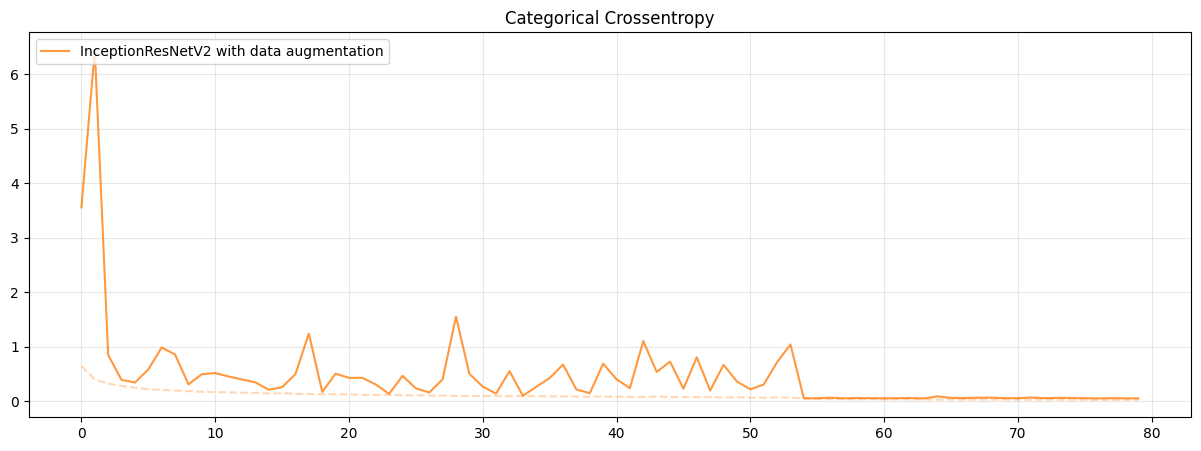

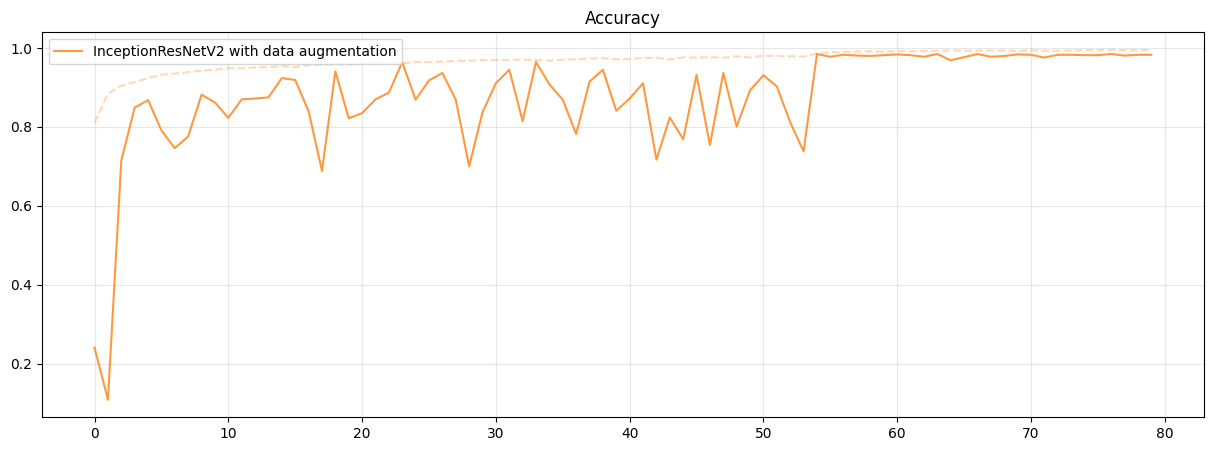

In [ ]:
# Plot the results of the run
plot_histories([history_inceptionresnet_aug_1], ['InceptionResNetV2 with data augmentation'])

In [ ]:
# Save the model
inception_resnet_aug.save('InceptionResNetAugmented')

Now we try adding the full augmentation.

In [ ]:
def build_inception_resnetv2_aug(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Add data augmentation step
    preprocessing = tf.keras.Sequential([
            tfkl.RandomTranslation(0.1,0.1),
            tfkl.RandomFlip("horizontal_and_vertical"),
            tfkl.RandomRotation(0.1),
        ], name='preprocessing')
    preprocessing = preprocessing(input_layer)

    # Stem block
    x = conv_bn_block(preprocessing, 32, 3, strides=2, padding='valid', batch_norm=True, name='Stem1')
    x = conv_bn_block(x, 32, 3, strides=1, padding='valid', batch_norm=True, name='Stem2')
    x = conv_bn_block(x, 64, 3, strides=1, padding='same', batch_norm=True, name='Stem3')

    # Inception-ResNet-A modules x3
    for i in range(3):
        x = inception_resnet_a(x, scale_residual=0.1, name='IncepResNetA_' + str(i + 1))

    # Reduction-A module
    x = reduction_a(x, name='ReductionA')

    # Global Average Pooling
    x = tfkl.GlobalAveragePooling2D(name='GlobalAvgPool')(x)

    # Fully connected layer
    x = tfkl.Dense(output_shape, activation='softmax', name='Output')(x)

    model = tfk.Model(inputs=input_layer, outputs=x, name='InceptionResNetv2')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate = 3e-4), metrics=['accuracy'])

    return model

In [ ]:
# Create the model
inception_resnet_aug_1 = build_inception_resnetv2_aug()

In [ ]:
# Train the model
history_inceptionresnet_aug_1 = inception_resnet_aug_1.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 300,
    validation_data = (X_val, y_val),
    callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
]
).history

Epoch 1/300
197/197 [==============================] - 56s 192ms/step - loss: 0.7160 - accuracy: 0.7889 - val_loss: 3.0725 - val_accuracy: 0.2220 - lr: 3.0000e-04
Epoch 2/300
197/197 [==============================] - 38s 191ms/step - loss: 0.4099 - accuracy: 0.8796 - val_loss: 2.8808 - val_accuracy: 0.2750 - lr: 3.0000e-04
Epoch 3/300
197/197 [==============================] - 37s 190ms/step - loss: 0.3319 - accuracy: 0.9003 - val_loss: 0.7409 - val_accuracy: 0.7020 - lr: 3.0000e-04
Epoch 4/300
197/197 [==============================] - 38s 194ms/step - loss: 0.2843 - accuracy: 0.9122 - val_loss: 2.7987 - val_accuracy: 0.4710 - lr: 3.0000e-04
Epoch 5/300
197/197 [==============================] - 38s 194ms/step - loss: 0.2554 - accuracy: 0.9184 - val_loss: 0.7189 - val_accuracy: 0.7790 - lr: 3.0000e-04
Epoch 6/300
197/197 [==============================] - 39s 196ms/step - loss: 0.2338 - accuracy: 0.9250 - val_loss: 0.2985 - val_accuracy: 0.8950 - lr: 3.0000e-04
Epoch 7/300
197/197 [=

In [ ]:
# Save the history
#with open('history_inceptionresnet_aug_2.pickle', 'wb') as handle:
    #pickle.dump(history_inceptionresnet_aug_1, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_inceptionresnet_aug_2.pickle', 'rb') as handle:
    history_inceptionresnet_aug_2 = pickle.load(handle)

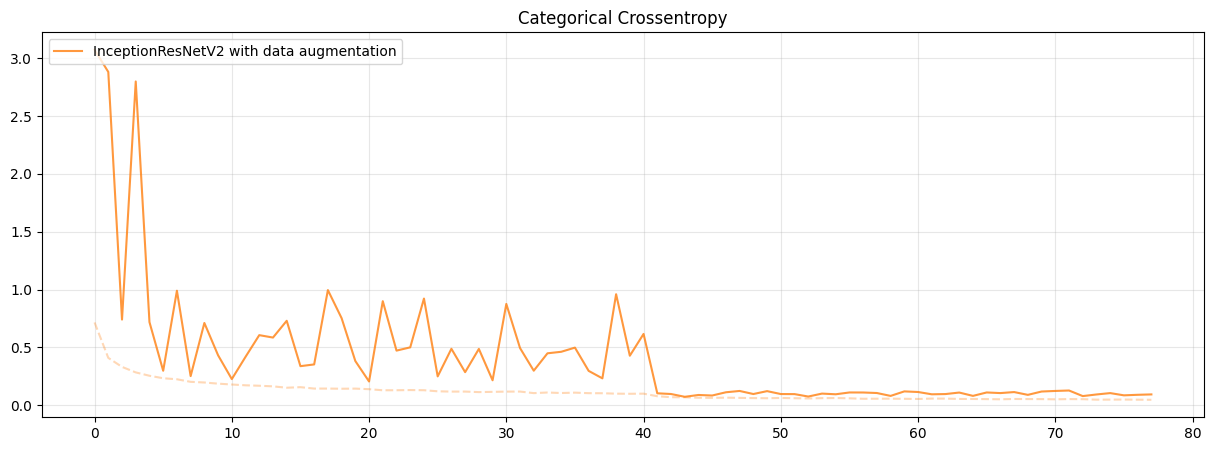

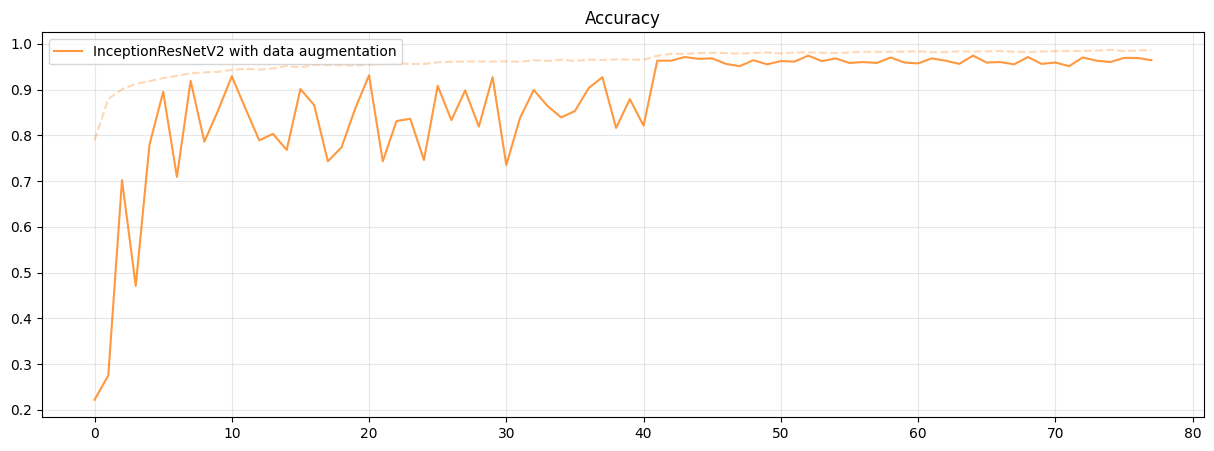

In [ ]:
# Plot the results of the run
plot_histories([history_inceptionresnet_aug_2], ['InceptionResNetV2 with data augmentation'])

The result is slightly worse. We will keep the first model, augmented with only the RandomFlip.

Accuracy: 0.972 

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       107
           1       1.00      1.00      1.00       273
           2       0.99      0.97      0.98       136
           3       0.91      0.97      0.94       254
           4       0.95      0.95      0.95       107
           5       0.95      0.91      0.93       125
           6       0.99      0.97      0.98       292
           7       1.00      1.00      1.00       206

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500
 



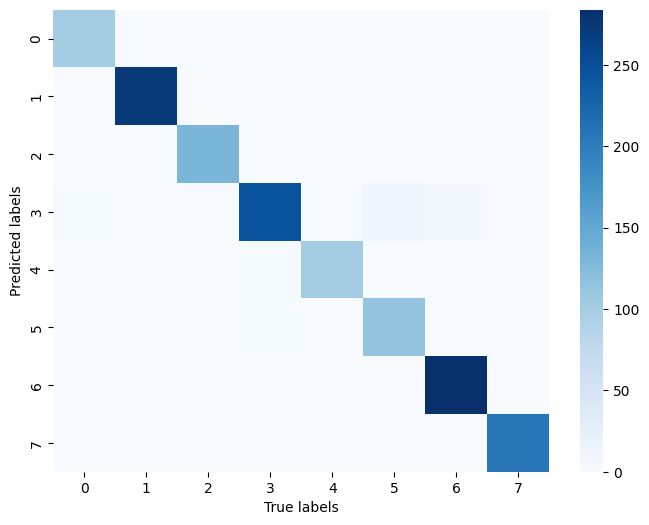

In [ ]:
assess_performance('InceptionResNetAugmented', X_test, y_test)

### InceptionResNetV2 + data augmentation 2 (class rebalancing)

With this experiment, we want to confirm or reject our hypothesis that rebalancing the classes does not affect performance. Let's proceed with generating a rebalanced dataset and feeding it into the model that is performing better.

In [ ]:
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

y_train1 = []
for e in y_train:
  y_train1.append(np.argmax(e))
y_train1 = np.array(y_train1)
y_train1

# Let's say y_train contains your class labels
# Count the number of instances per class
class_counts = Counter(y_train1)
print(class_counts)

# Find the maximum number of images in any class
max_count = max(class_counts.values())

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# This function will augment the dataset
def augment_class(class_id, n_needed, X_train, y_train):
    # Filter X_train for images of the class to be augmented
    X_class = X_train[y_train == class_id]

    # The generator will yield batches of augmented images indefinitely
    generator = datagen.flow(X_class, batch_size=32, shuffle=False)

    # Initialize empty arrays to collect augmented images and labels
    X_augmented = []
    y_augmented = []

    # Generate the necessary number of augmented images
    while n_needed > 0:
        X_new = next(generator)
        batch_size = X_new.shape[0]
        n_to_take = min(n_needed, batch_size)  # Take only what we need
        X_augmented.append(X_new[:n_to_take])
        y_augmented.extend([class_id] * n_to_take)
        n_needed -= n_to_take

    # Return augmented images and labels as arrays
    return np.vstack(X_augmented), np.array(y_augmented)

# Augment the dataset class by class
X_balanced = []
y_balanced = []

for class_id, count in class_counts.items():
    n_needed = max_count - count  # Number of images to generate for this class
    if n_needed > 0:
        X_augmented, y_augmented = augment_class(class_id, n_needed, X_train, y_train1)
        X_balanced.append(X_augmented)
        y_balanced.append(y_augmented)
    else:
        # If the class is already the largest, take all its samples without augmentation
        X_balanced.append(X_train[y_train1 == class_id])
        y_balanced.append(y_train1[y_train1 == class_id])

# Concatenate original and augmented data
X_balanced = np.vstack((X_train, *X_balanced))
y_balanced = np.concatenate((y_train1, *y_balanced))

print("Balanced dataset shape:", X_balanced.shape, y_balanced.shape)

Counter({6: 2452, 1: 2296, 3: 2133, 7: 1730, 2: 1143, 5: 1046, 0: 898, 4: 894})
Balanced dataset shape: (22068, 48, 48, 3) (22068,)


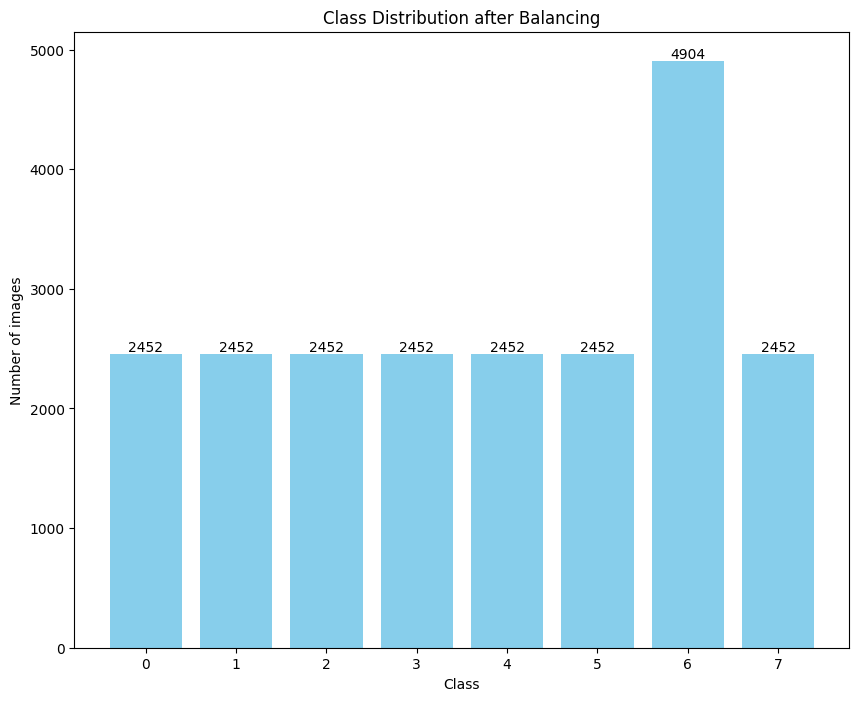

In [ ]:
# Count the number of instances per class in the balanced dataset
balanced_class_counts = Counter(y_balanced)

# Sort the classes and corresponding counts for consistent coloring and ordering
classes, counts = zip(*sorted(balanced_class_counts.items()))

plt.figure(figsize=(10, 8))

# Create bar plot
plt.bar(classes, counts, color='skyblue')

# Add title and labels
plt.title('Class Distribution after Balancing')
plt.xlabel('Class')
plt.ylabel('Number of images')

# Add the counts above the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Show the plot
plt.show()

All the classes are balanced except class 6, which has more pictures. This may be okay if it has more variability than the other classes. However, we can try to balance class 6 as well.

In [ ]:
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

TARGET_SAMPLES = 2500

# Assuming y_train is one-hot encoded, converting it to label encoded
y_train1 = []
for e in y_train:
    y_train1.append(np.argmax(e))
y_train1 = np.array(y_train1)

class_counts = Counter(y_train1)
print(class_counts)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_class(class_id, n_needed, X_train, y_train):
    X_class = X_train[y_train == class_id]
    generator = datagen.flow(X_class, batch_size=32, shuffle=False)
    X_augmented = []
    y_augmented = []

    while n_needed > 0:
        X_new = next(generator)
        batch_size = X_new.shape[0]
        n_to_take = min(n_needed, batch_size)
        X_augmented.append(X_new[:n_to_take])
        y_augmented.extend([class_id] * n_to_take)
        n_needed -= n_to_take

    return np.vstack(X_augmented), np.array(y_augmented)

def take_subset(class_id, n_take, X_train, y_train):
    mask = y_train == class_id
    X_class = X_train[mask]
    y_class = y_train[mask]

    selected_indices = np.random.choice(np.arange(X_class.shape[0]), size=n_take, replace=False)

    return X_class[selected_indices], y_class[selected_indices]

X_balanced1 = []
y_balanced1 = []

for class_id, count in class_counts.items():
    # Always add the original images
    X_balanced1.append(X_train[y_train1 == class_id])
    y_balanced1.append(y_train1[y_train1 == class_id])

    n_needed = TARGET_SAMPLES - count
    if n_needed > 0:  # Augment if needed
        X_augmented, y_augmented = augment_class(class_id, n_needed, X_train, y_train1)
        X_balanced1.append(X_augmented)
        y_balanced1.append(y_augmented)
    elif n_needed < 0:  # Subset if needed
        X_class_subset, y_class_subset = take_subset(class_id, TARGET_SAMPLES, X_train, y_train1)
        X_balanced1.append(X_class_subset)
        y_balanced1.append(y_class_subset)

# Concatenate to get the final balanced dataset
X_balanced1 = np.vstack(X_balanced1)
y_balanced1 = np.concatenate(y_balanced1)

print("Balanced dataset shape:", X_balanced1.shape, y_balanced1.shape)


Counter({6: 2452, 1: 2296, 3: 2133, 7: 1730, 2: 1143, 5: 1046, 0: 898, 4: 894})
Balanced dataset shape: (20000, 48, 48, 3) (20000,)


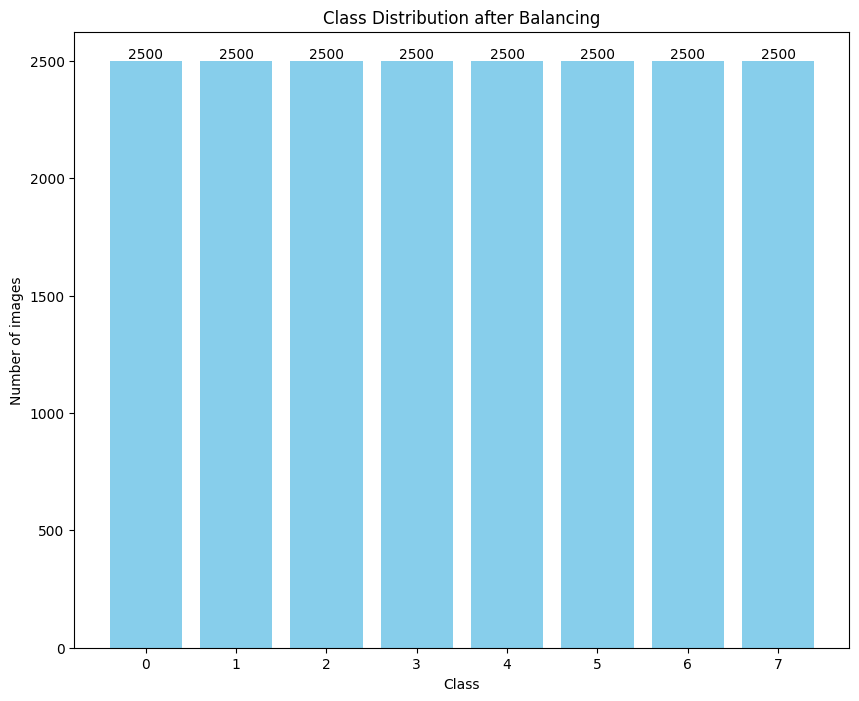

In [ ]:
# Count the number of instances per class in the balanced dataset
balanced_class_counts = Counter(y_balanced1)

# Sort the classes and corresponding counts for consistent coloring and ordering
classes, counts = zip(*sorted(balanced_class_counts.items()))

plt.figure(figsize=(10, 8))

# Create bar plot
plt.bar(classes, counts, color='skyblue')

# Add title and labels
plt.title('Class Distribution after Balancing')
plt.xlabel('Class')
plt.ylabel('Number of images')

# Add the counts above the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Show the plot
plt.show()

In [ ]:
# Convert labels to categorical format using one-hot encoding
y_train_bal = tfk.utils.to_categorical(y_balanced,len(np.unique(y_balanced)))
y_train_bal1 = tfk.utils.to_categorical(y_balanced1,len(np.unique(y_balanced1)))

In [ ]:
print(f'{X_balanced1.shape = }, {y_train_bal1.shape = }')

X_balanced1.shape = (20000, 48, 48, 3), y_train_bal1.shape = (20000, 8)


In [ ]:
# Create the model
inception_resnet_aug2 = build_inception_resnetv2_aug()

In [ ]:
# Train the model
history_inceptionresnet_aug2 = inception_resnet_aug2.fit(
    x = X_balanced1,
    y = y_train_bal1,
    batch_size = 64,
    epochs = 300,
    validation_data = (X_val, y_val),
    callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
]
).history

Epoch 1/300
313/313 [==============================] - 104s 214ms/step - loss: 0.6415 - accuracy: 0.8148 - val_loss: 3.9102 - val_accuracy: 0.1200 - lr: 3.0000e-04
Epoch 2/300
313/313 [==============================] - 65s 208ms/step - loss: 0.3641 - accuracy: 0.8913 - val_loss: 0.9631 - val_accuracy: 0.6400 - lr: 3.0000e-04
Epoch 3/300
313/313 [==============================] - 65s 209ms/step - loss: 0.2900 - accuracy: 0.9114 - val_loss: 0.2714 - val_accuracy: 0.9000 - lr: 3.0000e-04
Epoch 4/300
313/313 [==============================] - 64s 205ms/step - loss: 0.2512 - accuracy: 0.9212 - val_loss: 0.5791 - val_accuracy: 0.7880 - lr: 3.0000e-04
Epoch 5/300
313/313 [==============================] - 64s 206ms/step - loss: 0.2299 - accuracy: 0.9254 - val_loss: 0.3546 - val_accuracy: 0.8640 - lr: 3.0000e-04
Epoch 6/300
313/313 [==============================] - 64s 205ms/step - loss: 0.2016 - accuracy: 0.9376 - val_loss: 0.5537 - val_accuracy: 0.8150 - lr: 3.0000e-04
Epoch 7/300
313/313 [

In [ ]:
# Save the history
#with open('history_inceptionresnet_aug_1_rebal.pickle', 'wb') as handle:
#    pickle.dump(history_inceptionresnet_aug, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the history
with open('history_inceptionresnet_aug_1_rebal.pickle', 'rb') as handle:
    history_inceptionresnet_aug_1 = pickle.load(handle)

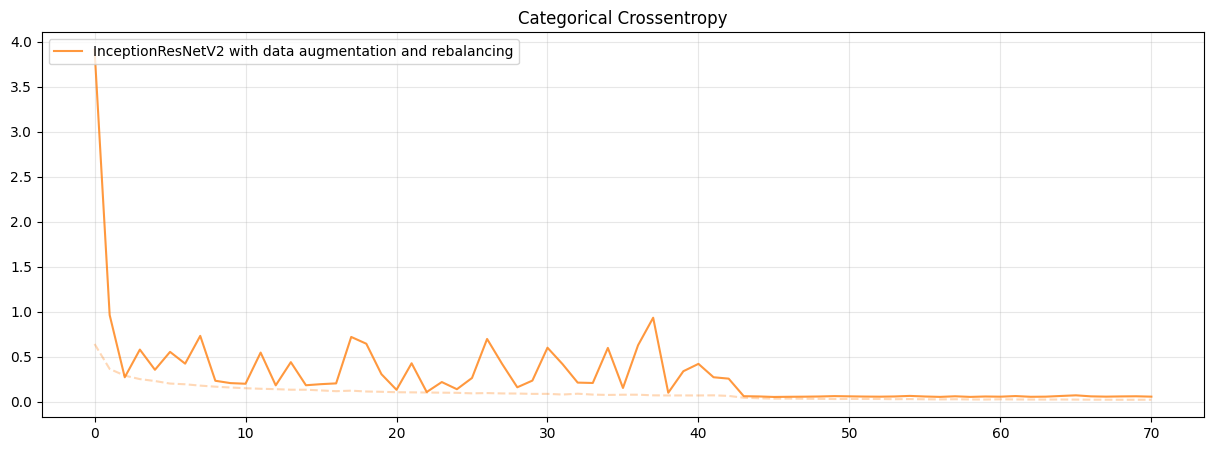

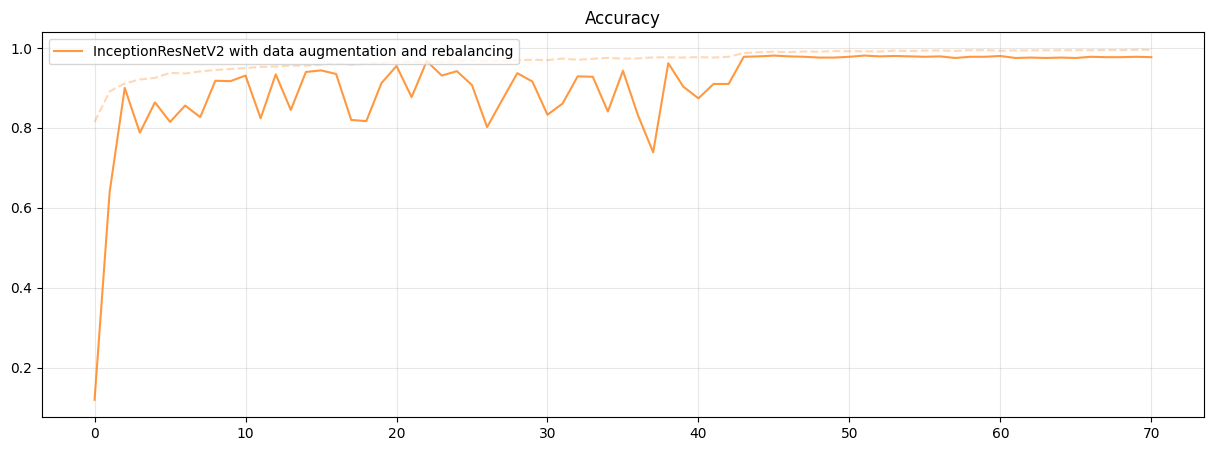

In [ ]:
# Plot the results of the run
plot_histories([history_inceptionresnet_aug2], ['InceptionResNetV2 with data augmentation and rebalancing'])

The results are consistent with our hypothesis: balancing the classes does not lead to an improvement in performance.

### Further analyses with InceptionResNetV2 - CAM

We can now use our model to isolate cells within bounding boxes! We can use the Class Activation Mapping to identify the regions where the model pays attention and build boxes around them. We adjusted the code from Professor Lomurno's notebook.

In [ ]:
def compute_CAM(img, pred_model, CAM_model):
    img = np.expand_dims(img, axis=0) #reshape

    predictions = model.predict(img) #prediction
    label_index = np.argmax(predictions)

    # Get the input weights to the softmax of the winning class
    class_weights = model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]

    # Compute the convolutional outputs and squeeze the dimensions
    conv_outputs = CAM_model(img)
    conv_outputs = np.squeeze(conv_outputs)

    # Upsample the convolutional outputs to match the image size
    upscaled_conv_outputs = tf.image.resize(conv_outputs, (48, 48))

    # Compute the final output using the class weights
    final_output = np.dot(upscaled_conv_outputs, class_weights_winner)

    return final_output, label_index, predictions

In [ ]:
# Prepare models
model = tfk.models.load_model('InceptionResNetAugmented')
CAM_model = tfk.Model(inputs=model.input, outputs=model.layers[-3].output, name = 'CAM') #Last two layers are GAP and Output

In [ ]:
# Generate the Class Activation Mapping
values = []
for img in X_val[:20]:
    values.append(compute_CAM(img, model, CAM_model))
values = np.array(values)

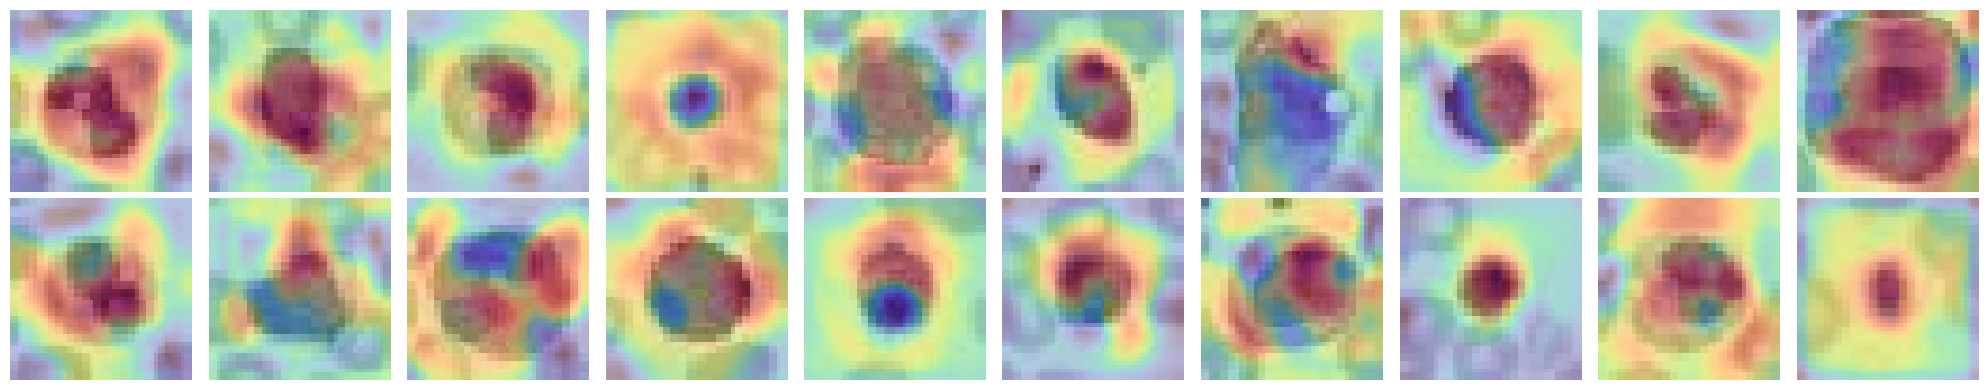

In [ ]:
# Inspect the data
num_img = 20
fig, axes = plt.subplots(2, num_img//2, figsize=(20,4))
for i in range(num_img):
    ax = axes[i%2,i%num_img//2]
    ax.imshow(values[i][0], cmap='turbo', alpha=1)
    ax.imshow(np.clip(X_val[i], 0, 255), alpha=0.6)
    ax.axis('off')
plt.tight_layout()
plt.show()

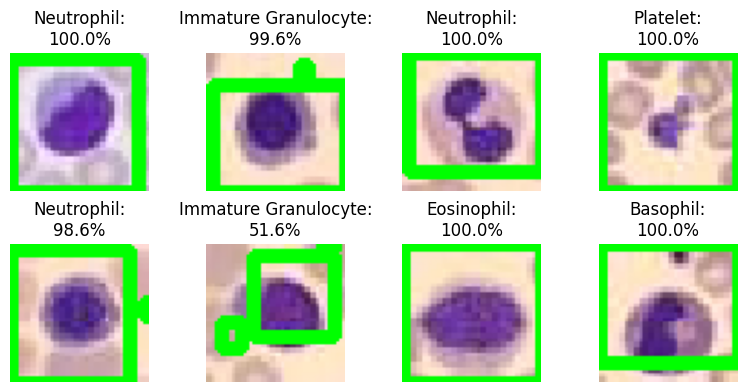

In [ ]:
num_img = 8
labels = dict(data['names'].tolist())
fig, axes = plt.subplots(2, num_img//2, figsize=(8,4))
for i in range(num_img):

    heatmap_max = np.max(values[i][0])

    boundary = heatmap_max * 0.3

    bbox_heatmap = values[i][0].copy()
    bbox_heatmap = np.where(bbox_heatmap <= boundary, 0, 255)

    bbox_img = X_test[i].copy()

    # find contours of heatmap
    cnts = cv2.findContours(bbox_heatmap.astype('uint8'),
                            cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    offset = 0
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(bbox_img, (x+offset, y+offset),
                    (x+offset + w, y + h), (0,100,0), 3)


    label = labels[values[i][1]]
    confidence = round(values[i][2][0][values[i][1]] * 100,1)

    ax = axes[i%2,i%num_img//2]
    ax.imshow(np.clip(bbox_img, 0, 1))
    ax.title.set_text('{}:\n{}%'.format(label, confidence))
    ax.axis('off')
plt.tight_layout()
plt.show()

This is an extremely interesting application of our model: building bounding boxes around cells could be useful, for example, for automating cell counting, and broadly speaking, it could help speed up cythological analyses!

### Further analyses with InceptionResNetV2 - image retrieval

We can also use our model to compute the similarity among features and retrieve the most similar images.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def image_retrieval(model, X, query_image, top_k=5):

    # Extract features from the penultimate layer of the model
    intermediate_layer_model = tfk.models.Model(inputs=model.input, outputs=model.get_layer(index=-2).output)

    query_image = np.expand_dims(query_image, axis=0)  # Add the batch dimension

    # Get the feature vector for the query image
    query_feature = intermediate_layer_model.predict(query_image)

    # Get feature vectors for all images in the dataset
    features = intermediate_layer_model.predict(X) # / 255.0)

    # Compute cosine similarities between query features and dataset features
    similarities = cosine_similarity(query_feature, features)

    # Get the top k indices with highest similarity scores
    top_k_indices = np.argsort(similarities[0])[::-1][1:top_k+1]

    return top_k_indices


In [ ]:
model = tfk.models.load_model('InceptionResNetAugmented') # model "InceptionResNetV2 + data augmentation 1" trained on X_train

We can now plot the retrieved images for a generic query image

47/47 [==============================] - 1s 27ms/step


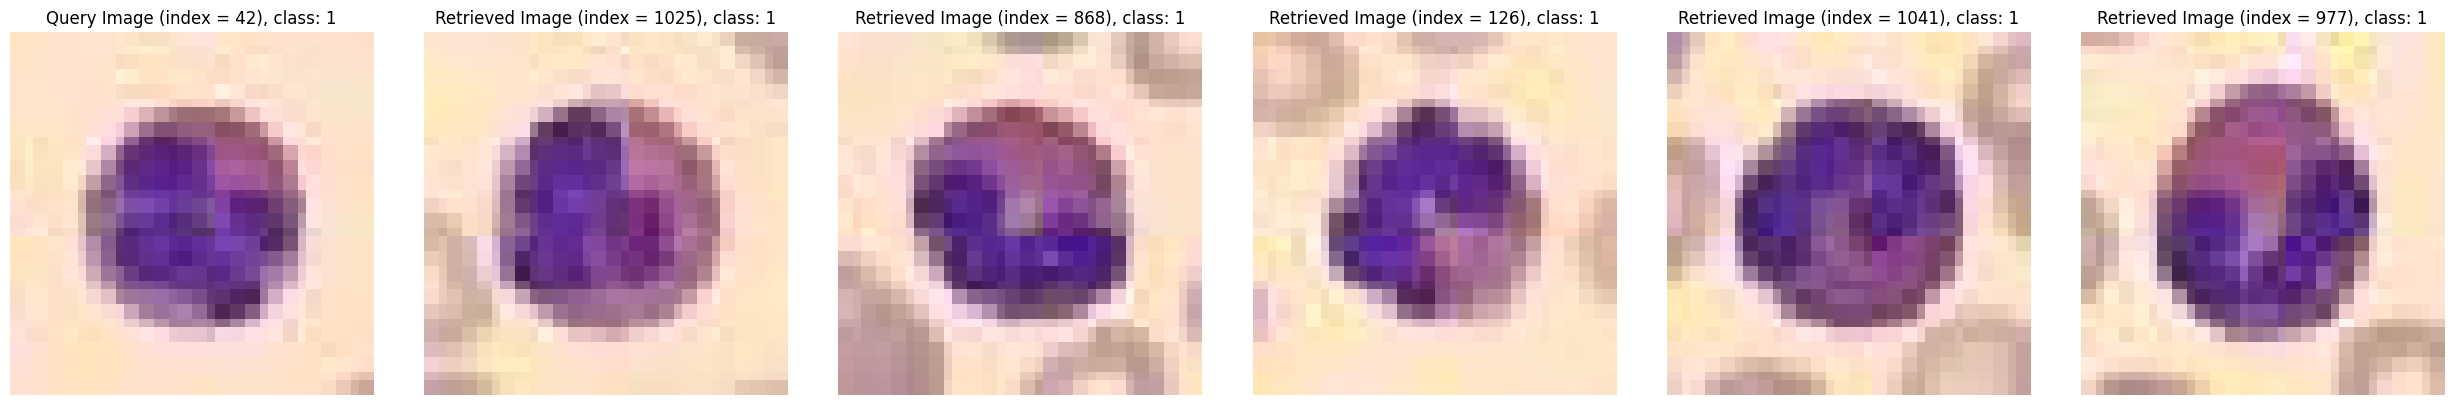

In [ ]:
query_index = 42
query_image = X_test[query_index]
num_im = 5
top_k_indices = image_retrieval(model, X_test, query_image, top_k=num_im)

# Set the number of subplots based on the top_k + 1 for the query image
fig, axes = plt.subplots(1, num_im+1, figsize=(25, 4))  # Adjust the figure size as needed

# Plot the query image
axes[0].imshow(query_image)
axes[0].set_title(f'Query Image (index = {query_index}), class: {np.argmax(y_test[query_index])}')
axes[0].axis('off')

# Plot the retrieved images
for i, index in enumerate(top_k_indices):
    axes[i+1].imshow(X_test[index])
    axes[i+1].set_title(f'Retrieved Image ({index = }), class: {np.argmax(y_test[index])}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()


We can also use this function to retrieve the closest images to the images that are missclassified by our model. First we find the indices of the missclassified pictures:

In [ ]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=-1).astype('int32')
predictions

47/47 [==============================] - 2s 31ms/step


array([3, 2, 2, ..., 6, 3, 6], dtype=int32)

In [ ]:
y_test1 = []
for e in y_test:
  y_test1.append(np.argmax(e))
y_test1 = np.array(y_test1)

missclassified = (predictions != y_test1)
missclassified_indices = np.where(missclassified == True)[0]
missclassified_indices

array([   0,   12,   44,   64,   86,   99,  122,  131,  161,  228,  234,
        271,  300,  375,  449,  519,  590,  596,  614,  626,  658,  712,
        743,  758,  814,  818,  861,  926,  973,  976, 1009, 1019, 1109,
       1141, 1153, 1202, 1275, 1302, 1380, 1402, 1446, 1468])

We can now retrieve the closest images to the missclassified ones:

47/47 [==============================] - 1s 26ms/step


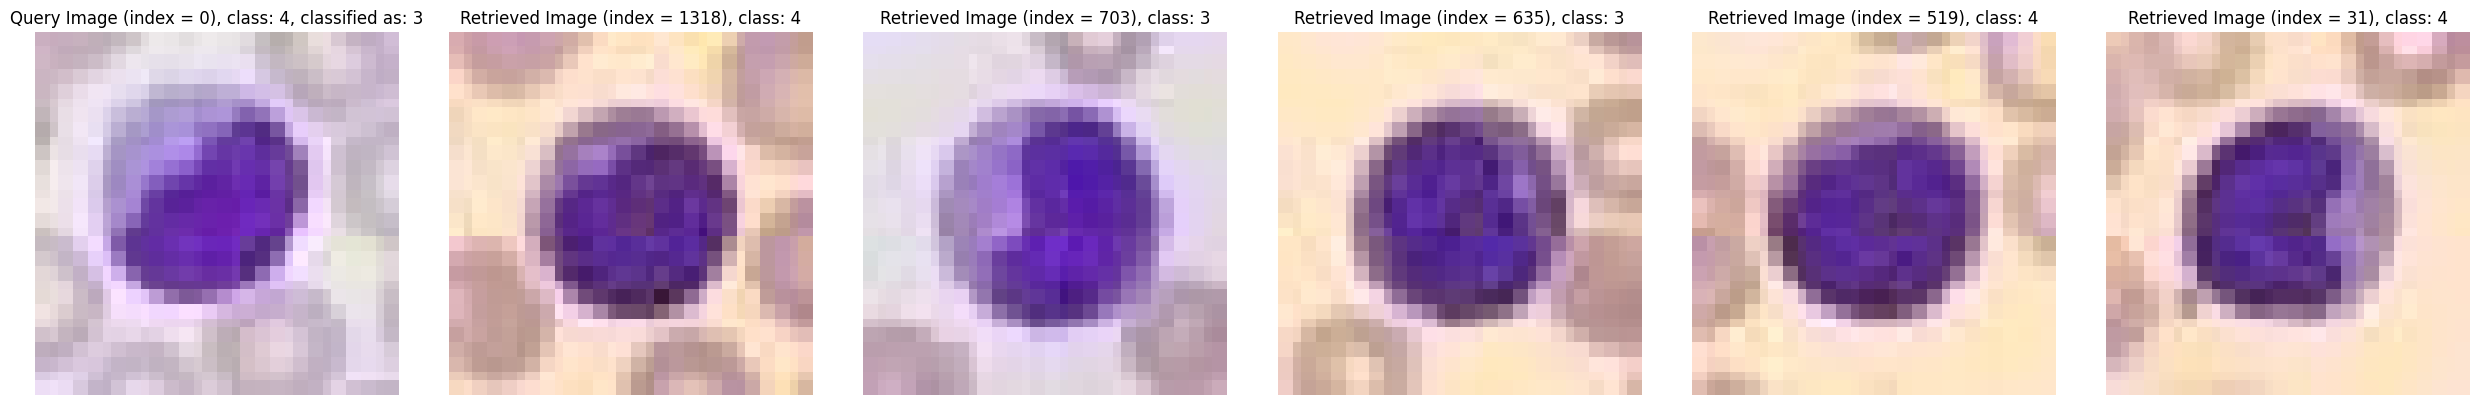

47/47 [==============================] - 1s 26ms/step


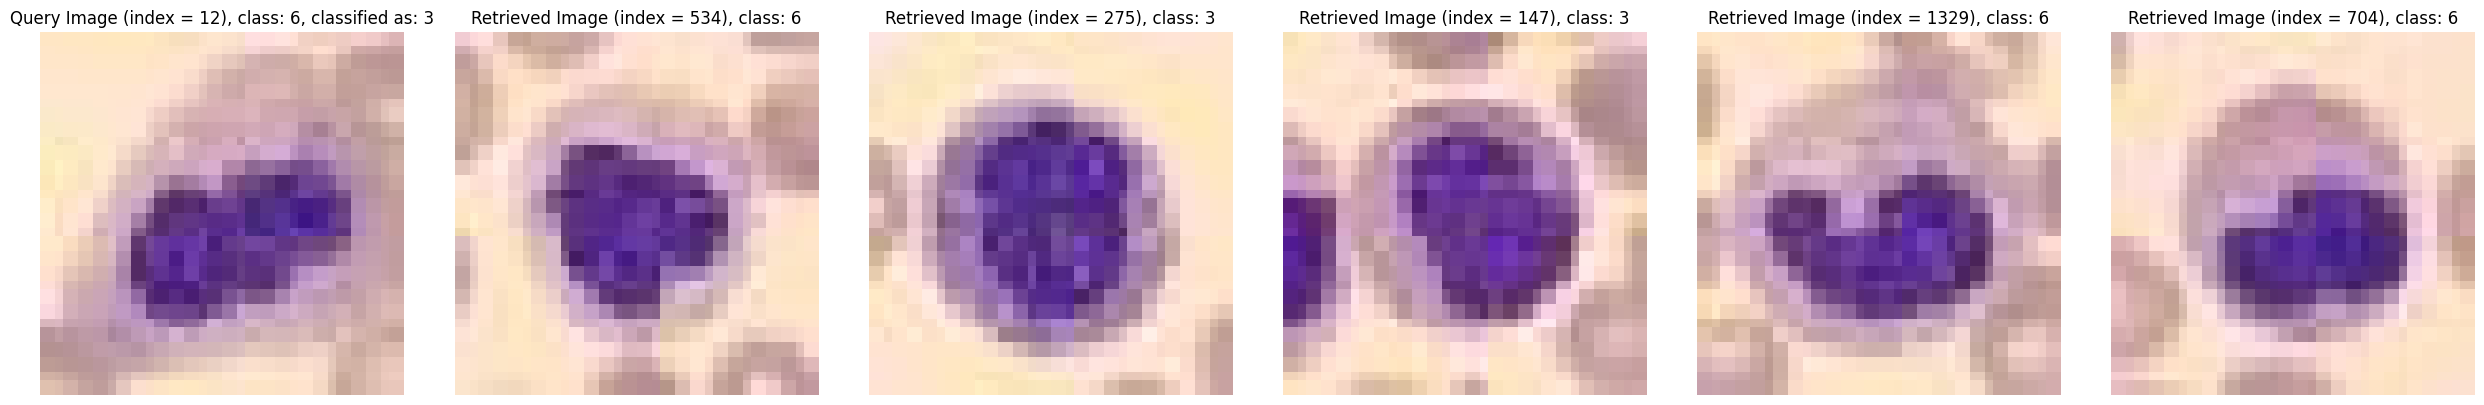

47/47 [==============================] - 1s 25ms/step


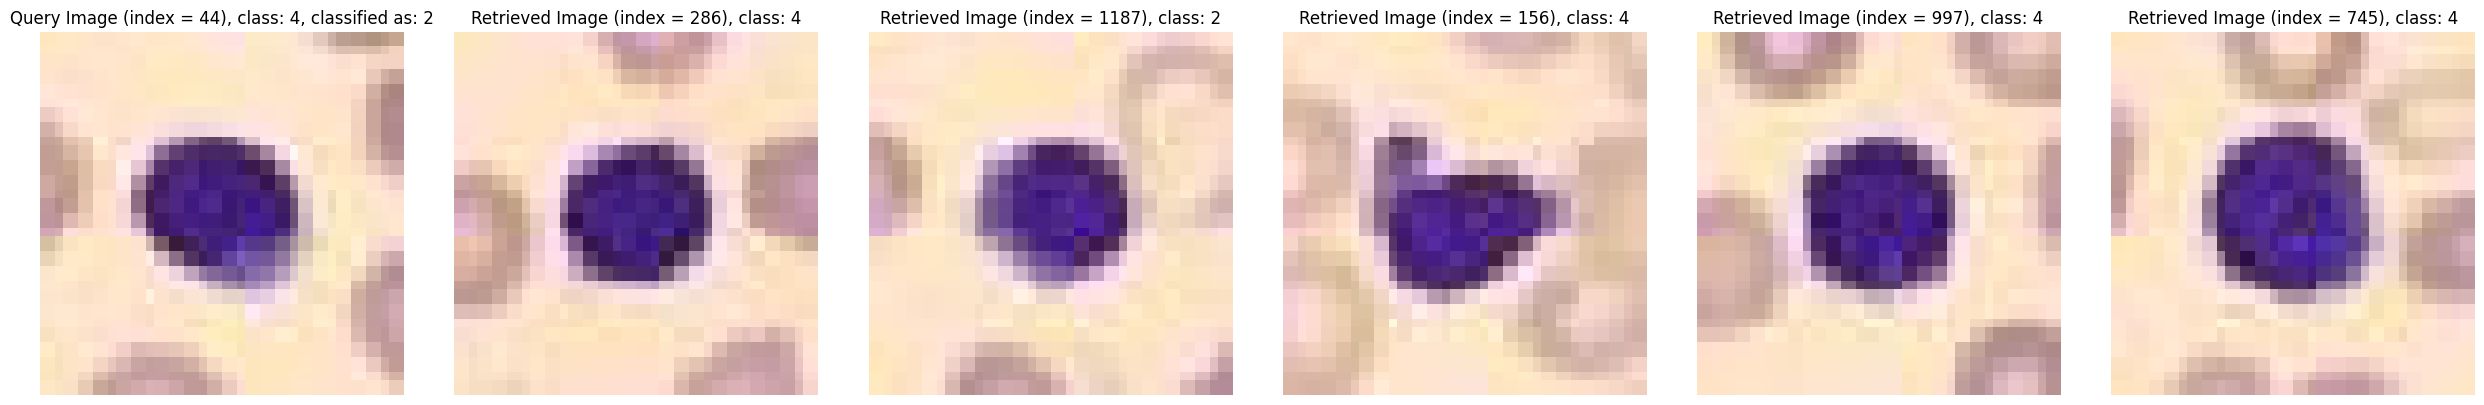

47/47 [==============================] - 1s 25ms/step


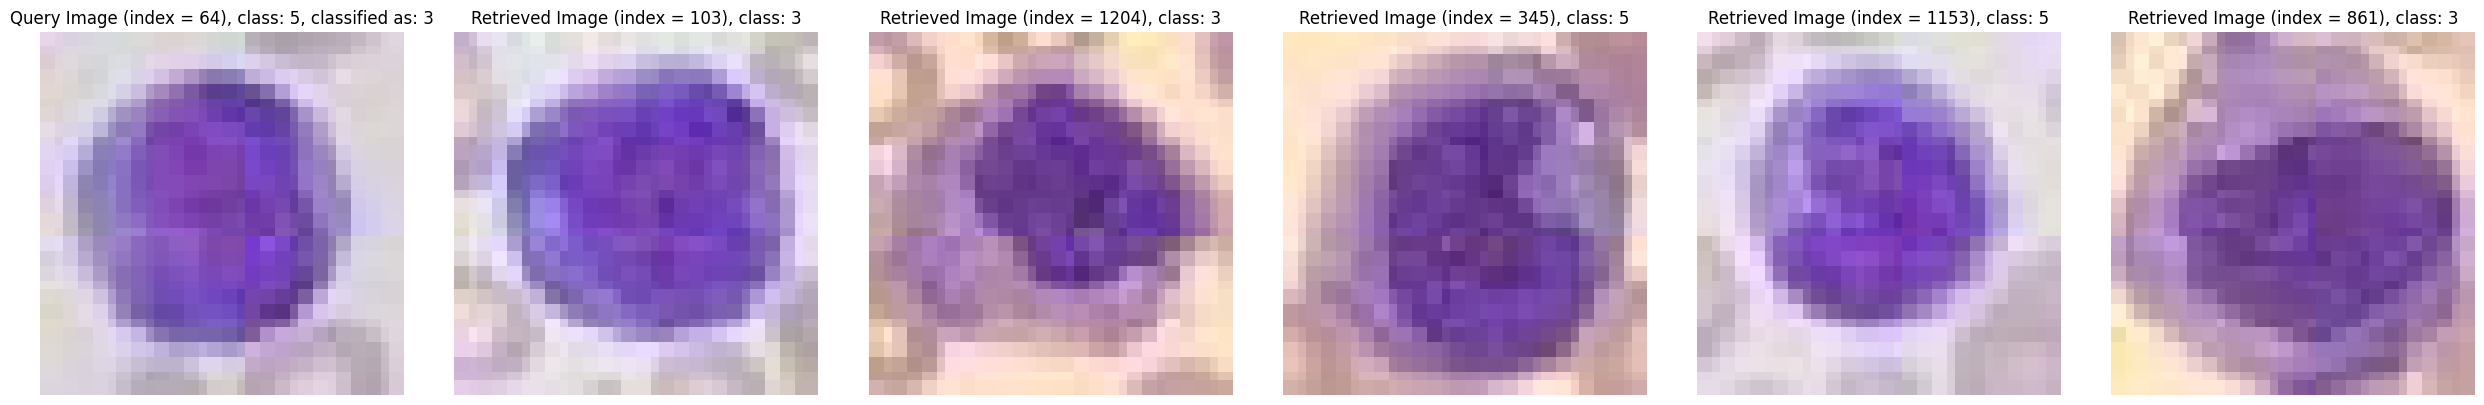

47/47 [==============================] - 1s 25ms/step


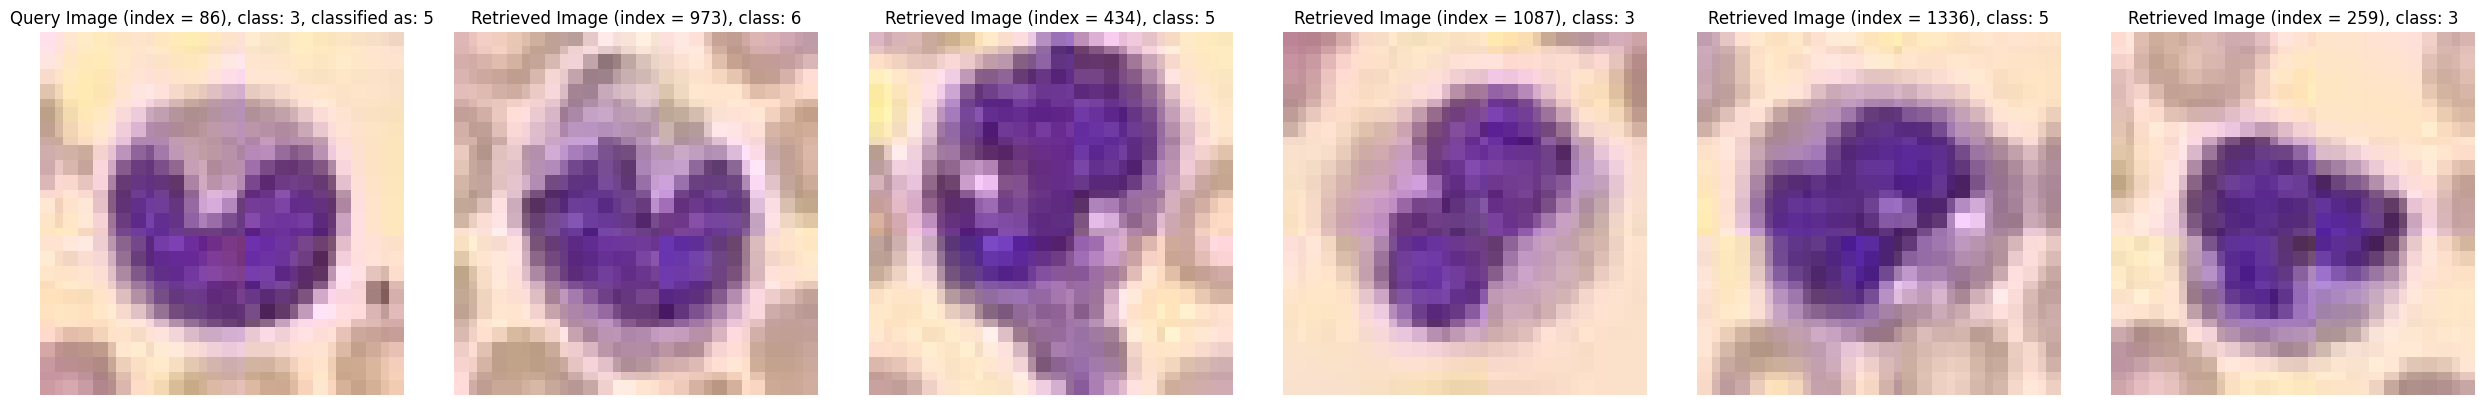

47/47 [==============================] - 1s 26ms/step


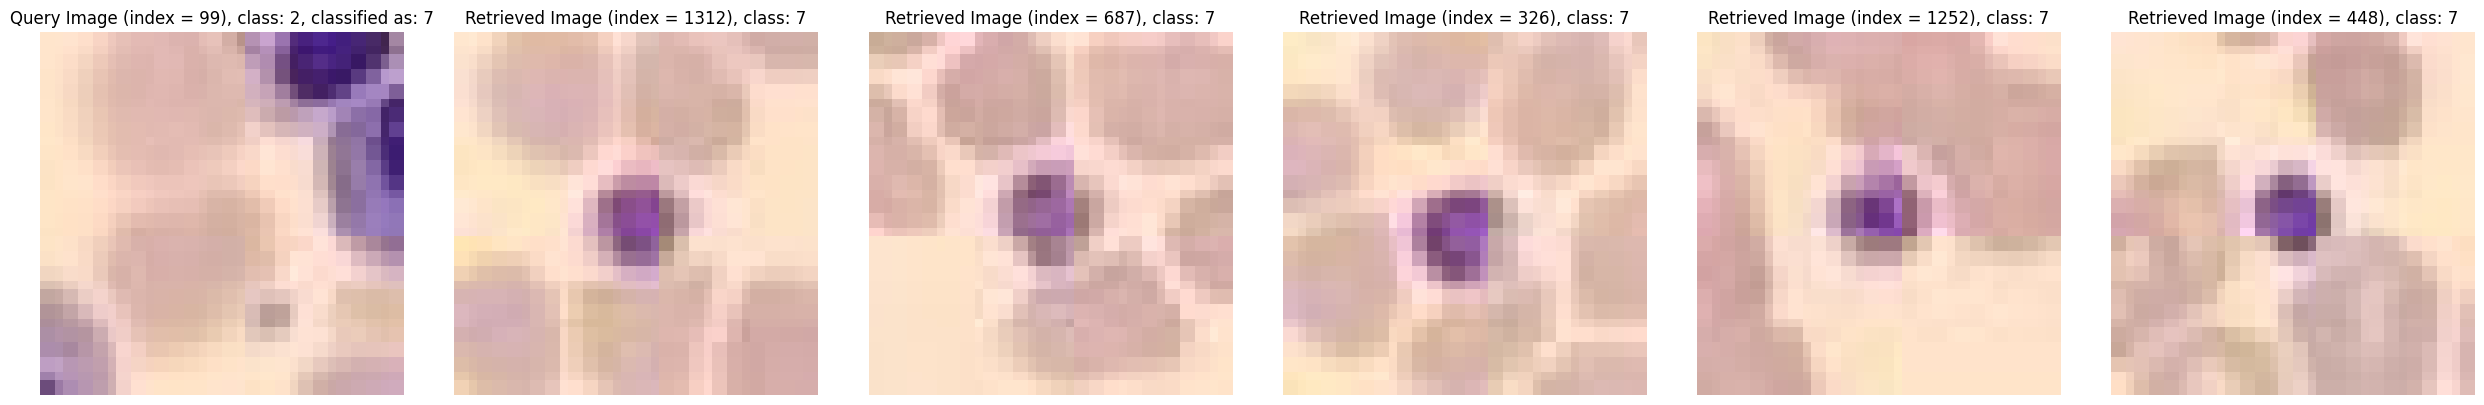

47/47 [==============================] - 1s 25ms/step


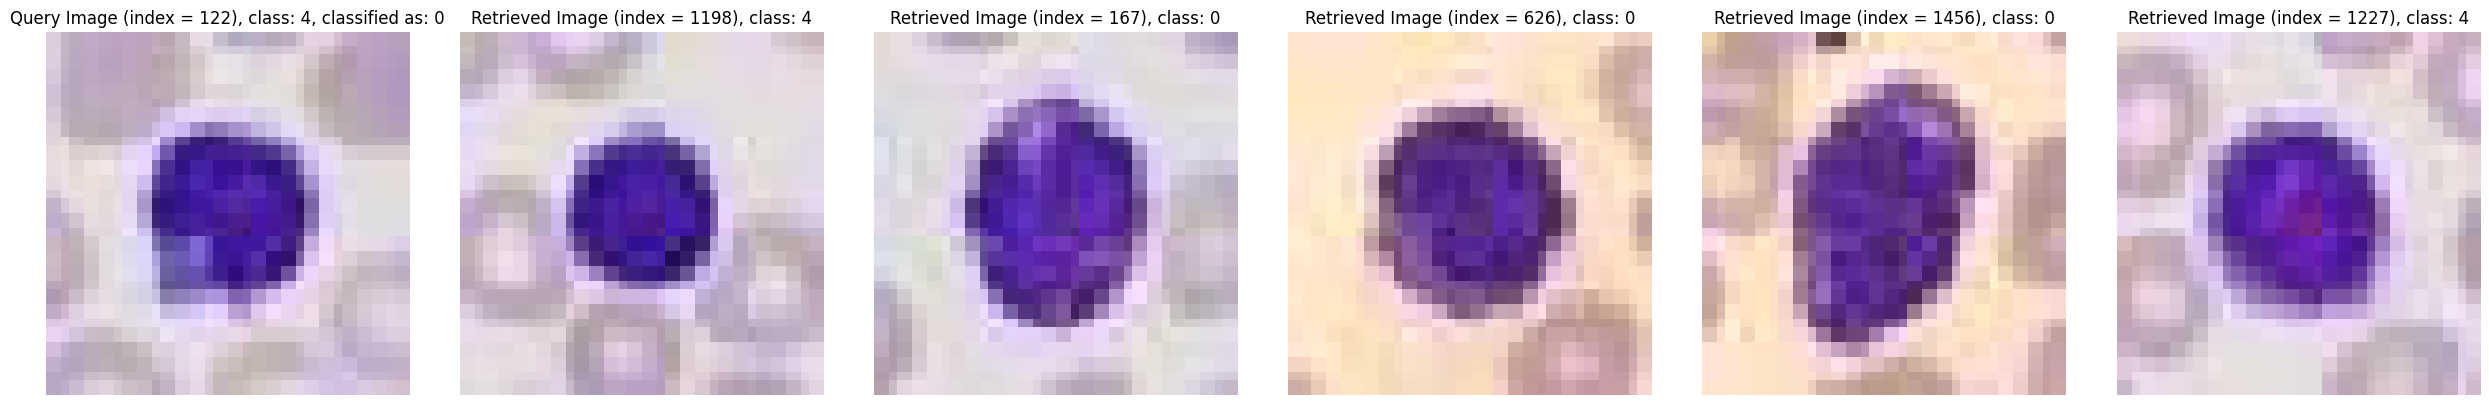

47/47 [==============================] - 1s 25ms/step


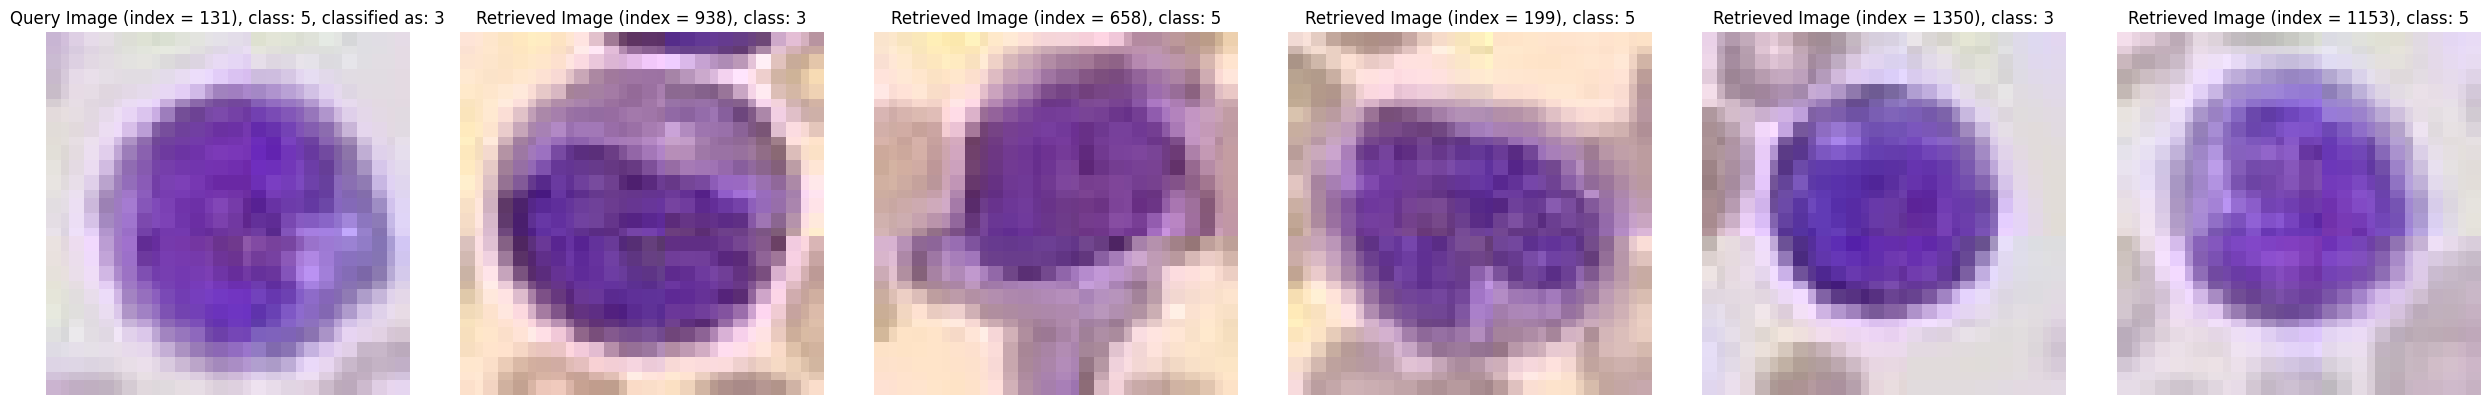

47/47 [==============================] - 1s 25ms/step


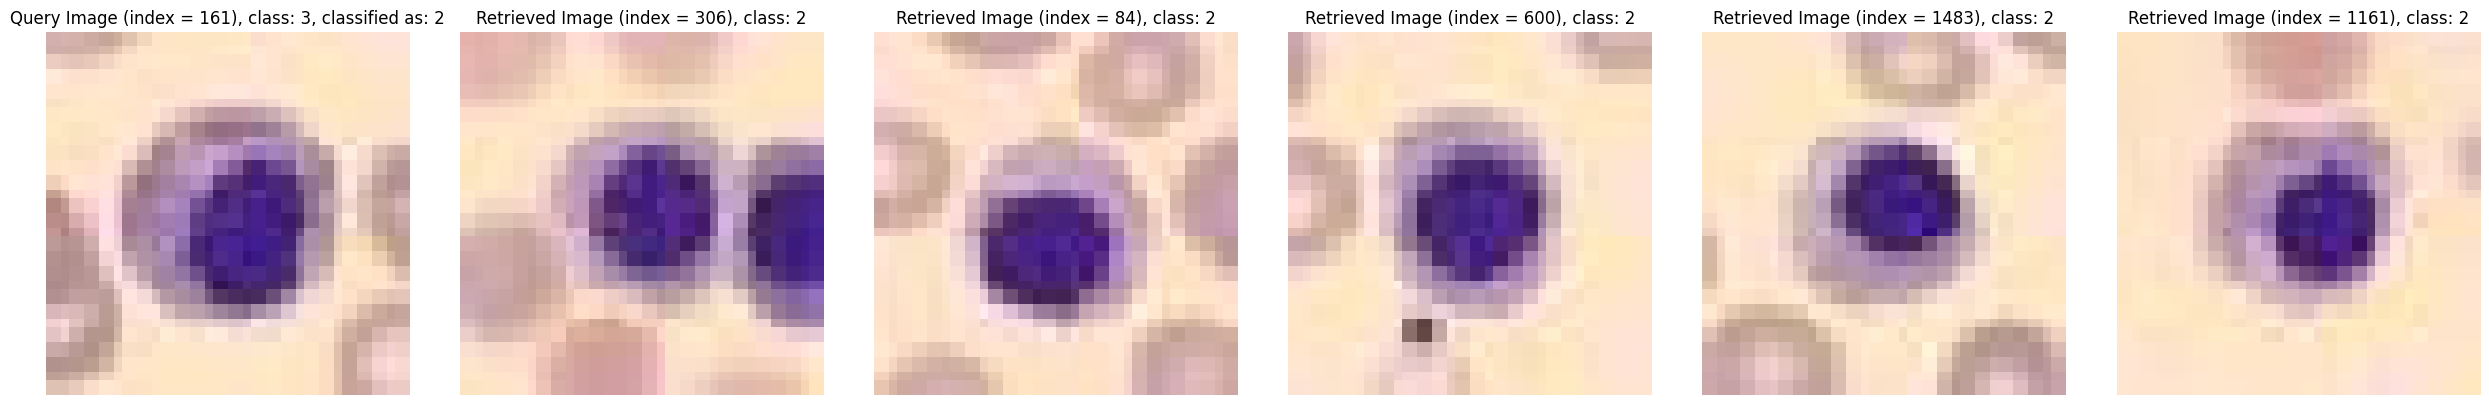

47/47 [==============================] - 1s 25ms/step


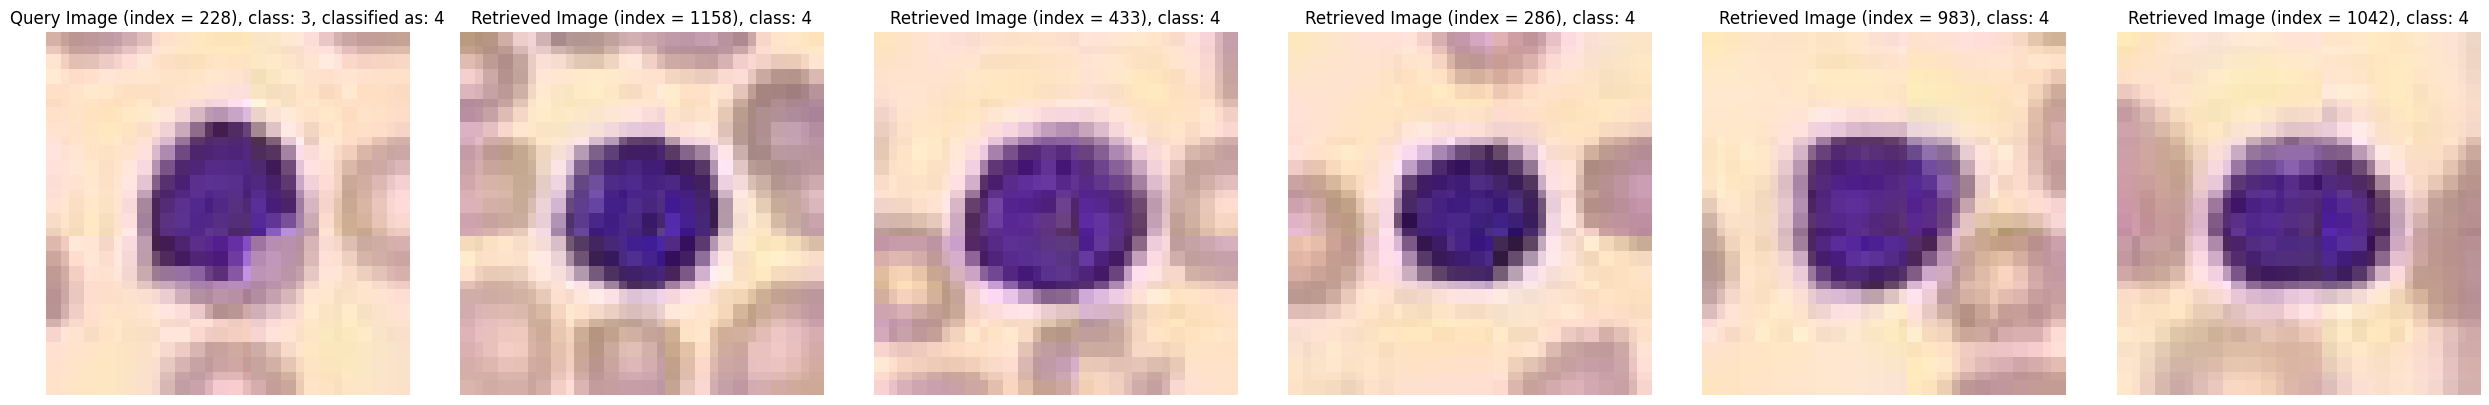

47/47 [==============================] - 1s 27ms/step


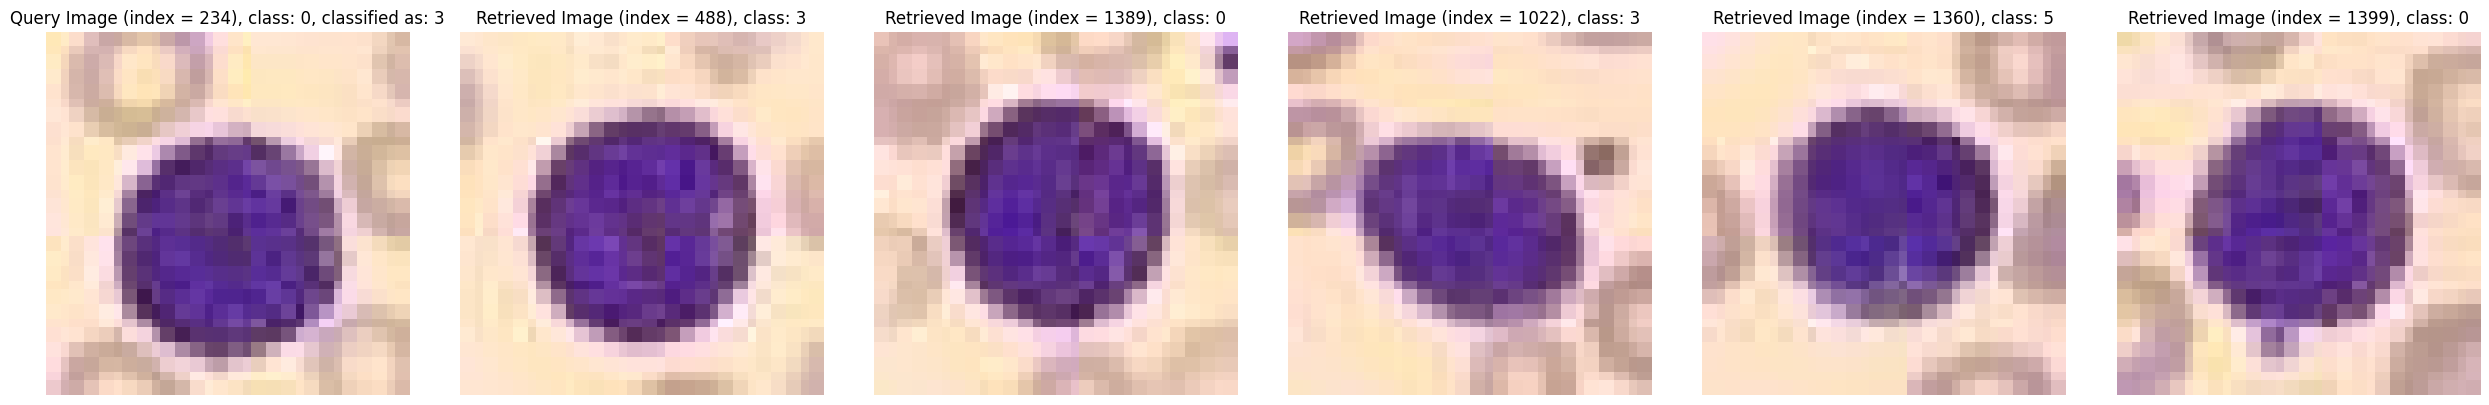

47/47 [==============================] - 1s 25ms/step


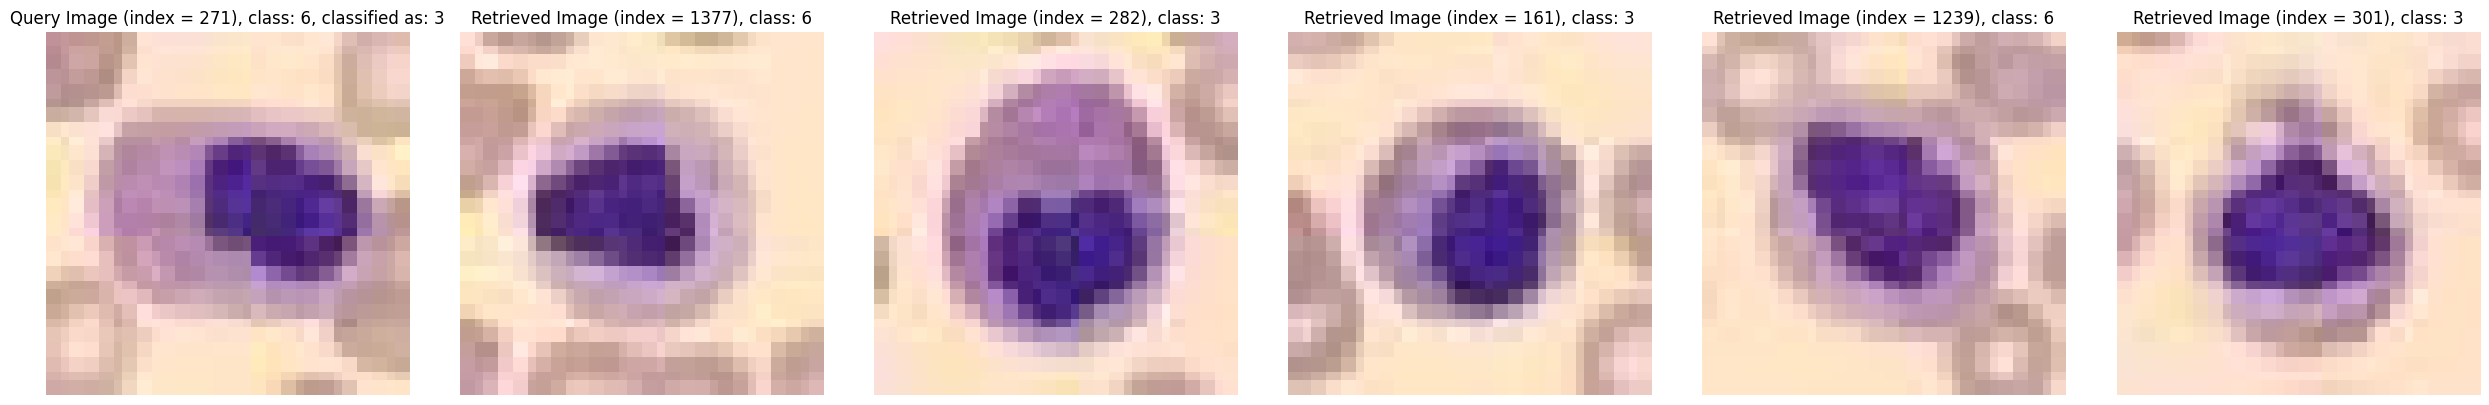

47/47 [==============================] - 1s 25ms/step


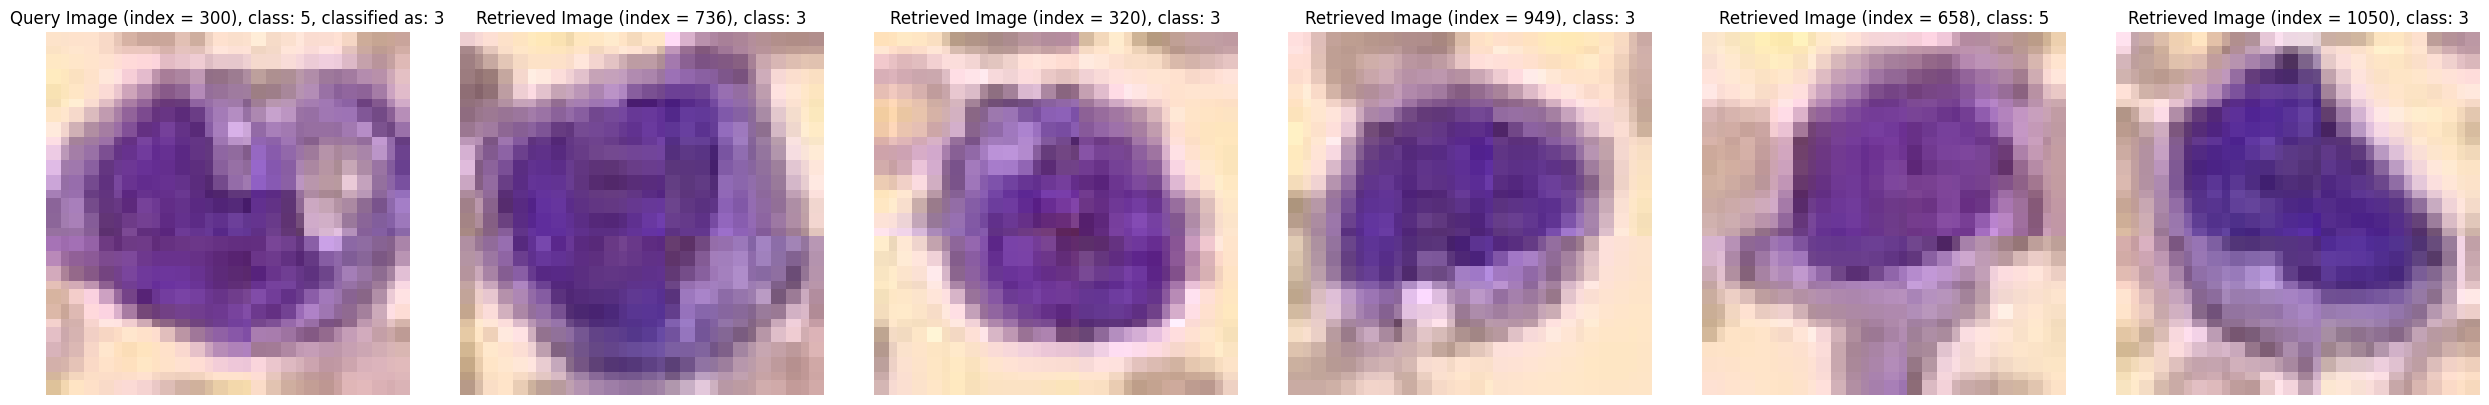

47/47 [==============================] - 1s 25ms/step


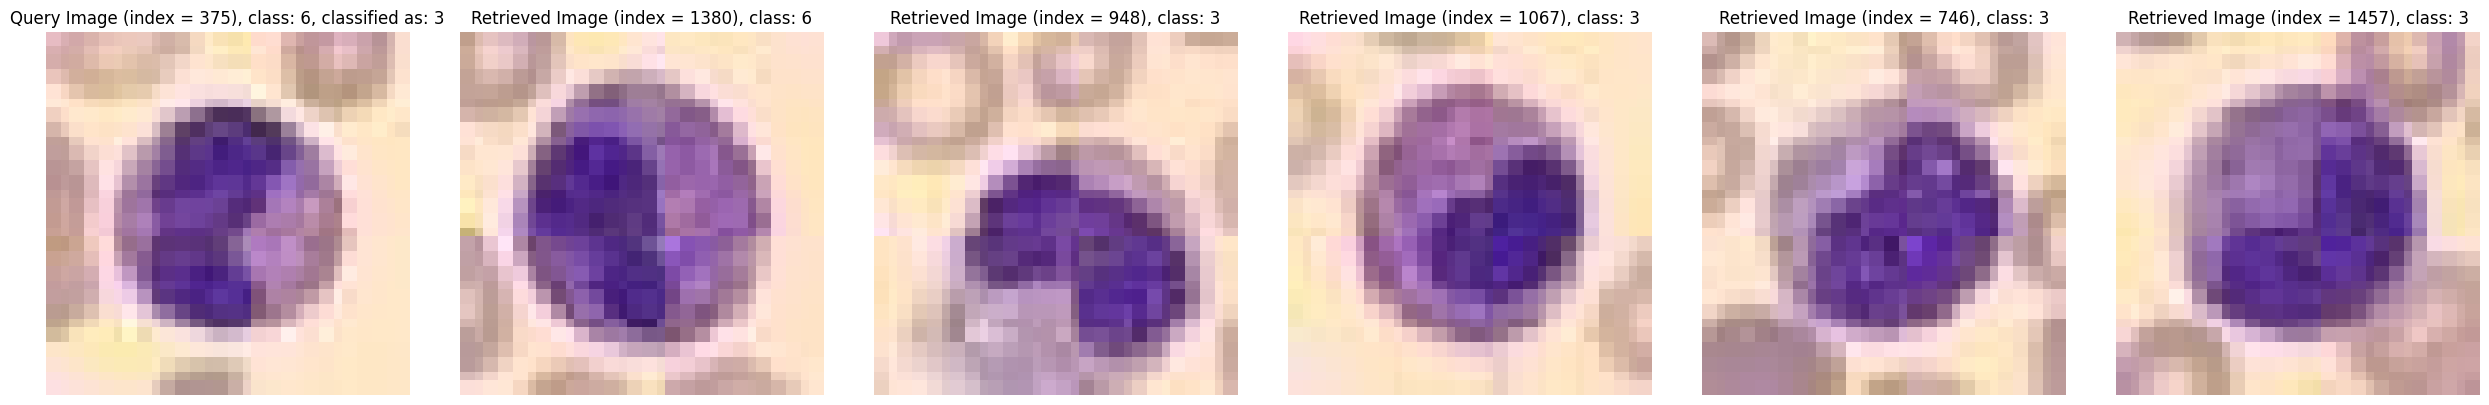

47/47 [==============================] - 1s 26ms/step


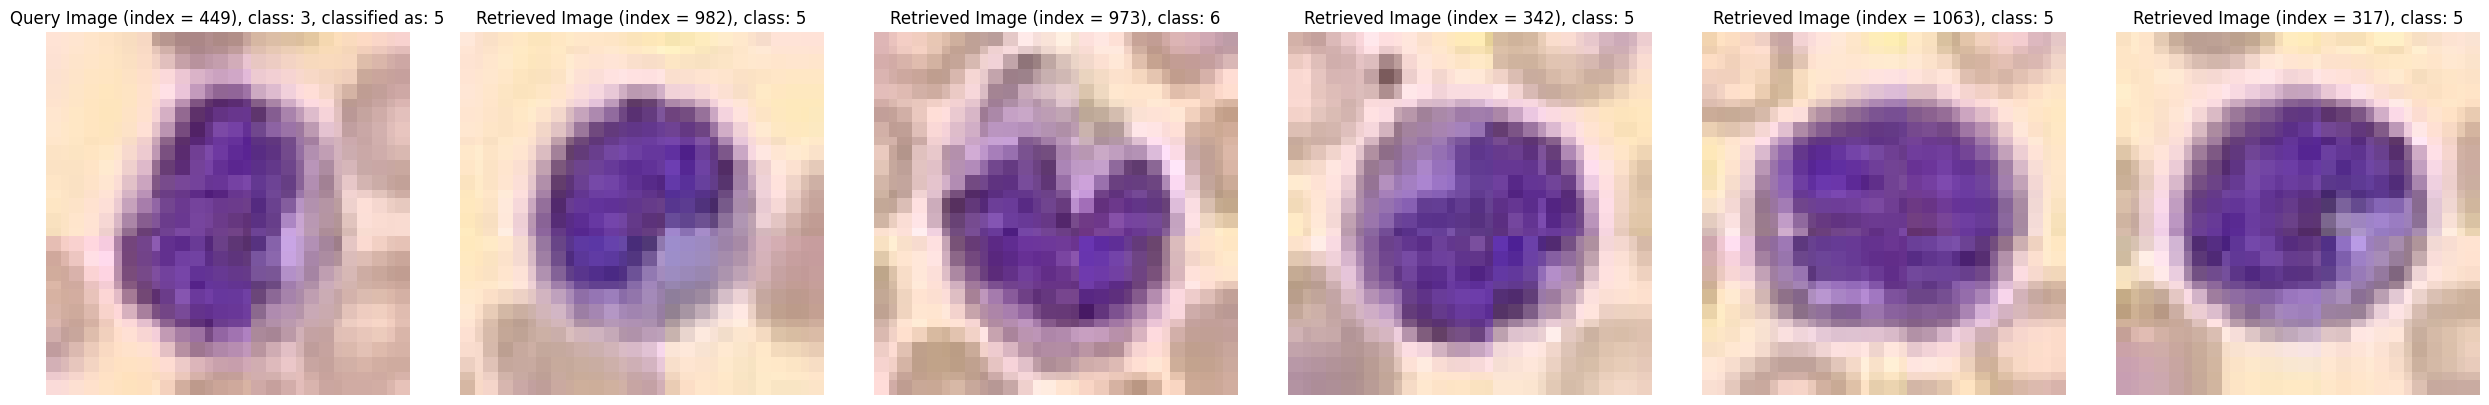

47/47 [==============================] - 1s 26ms/step


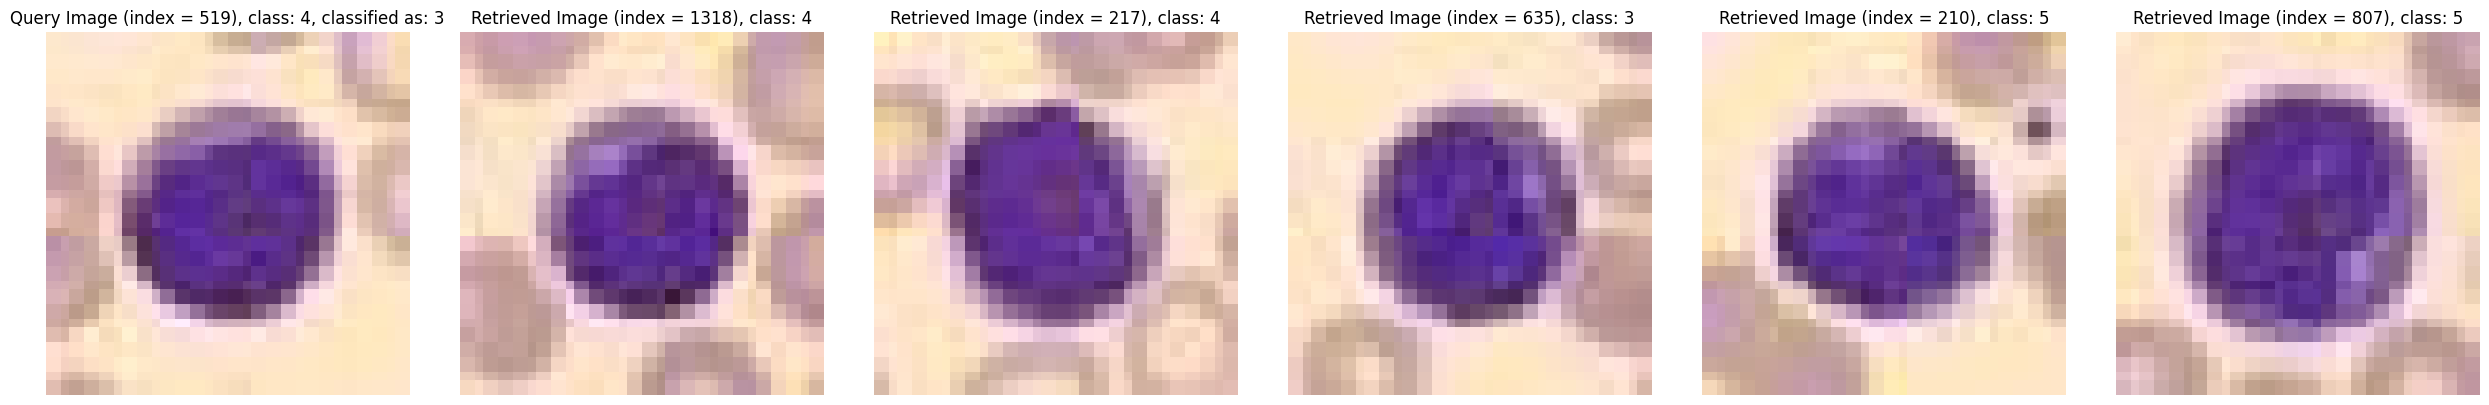

47/47 [==============================] - 1s 25ms/step


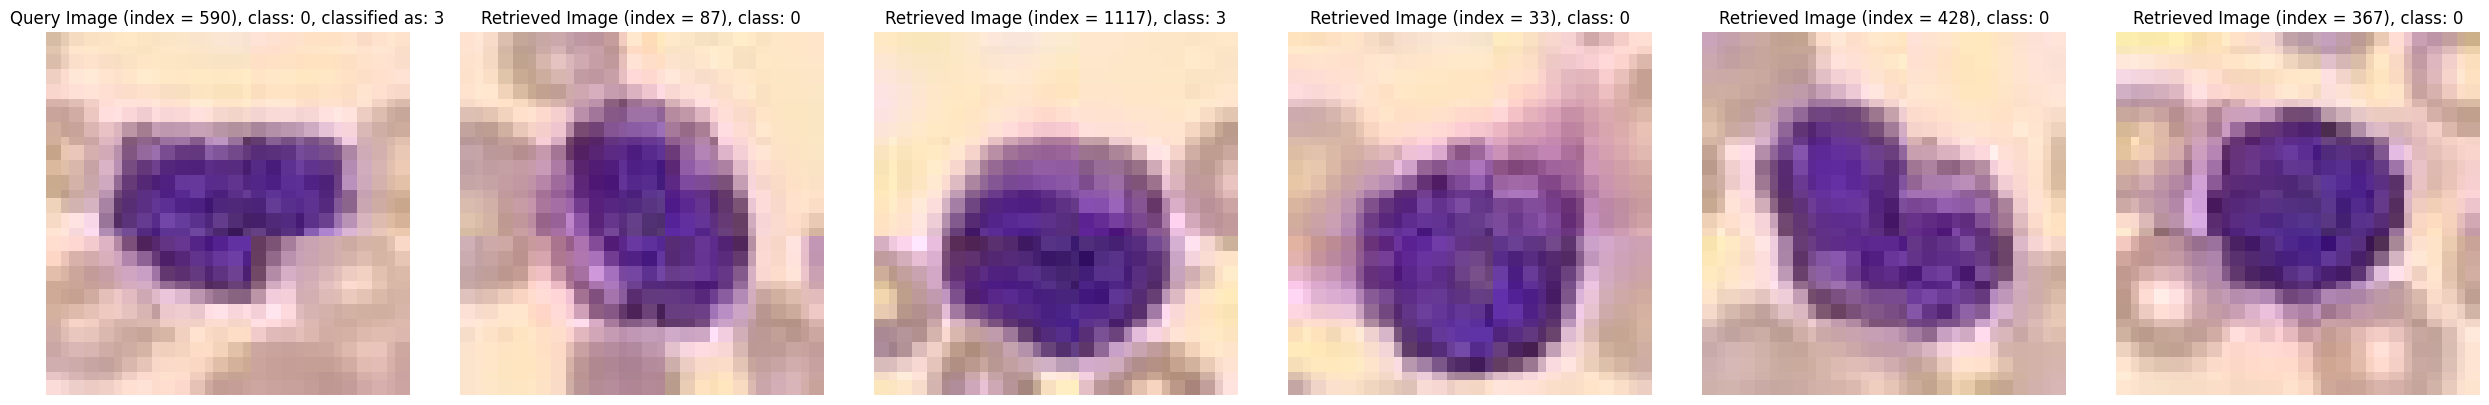

47/47 [==============================] - 1s 25ms/step


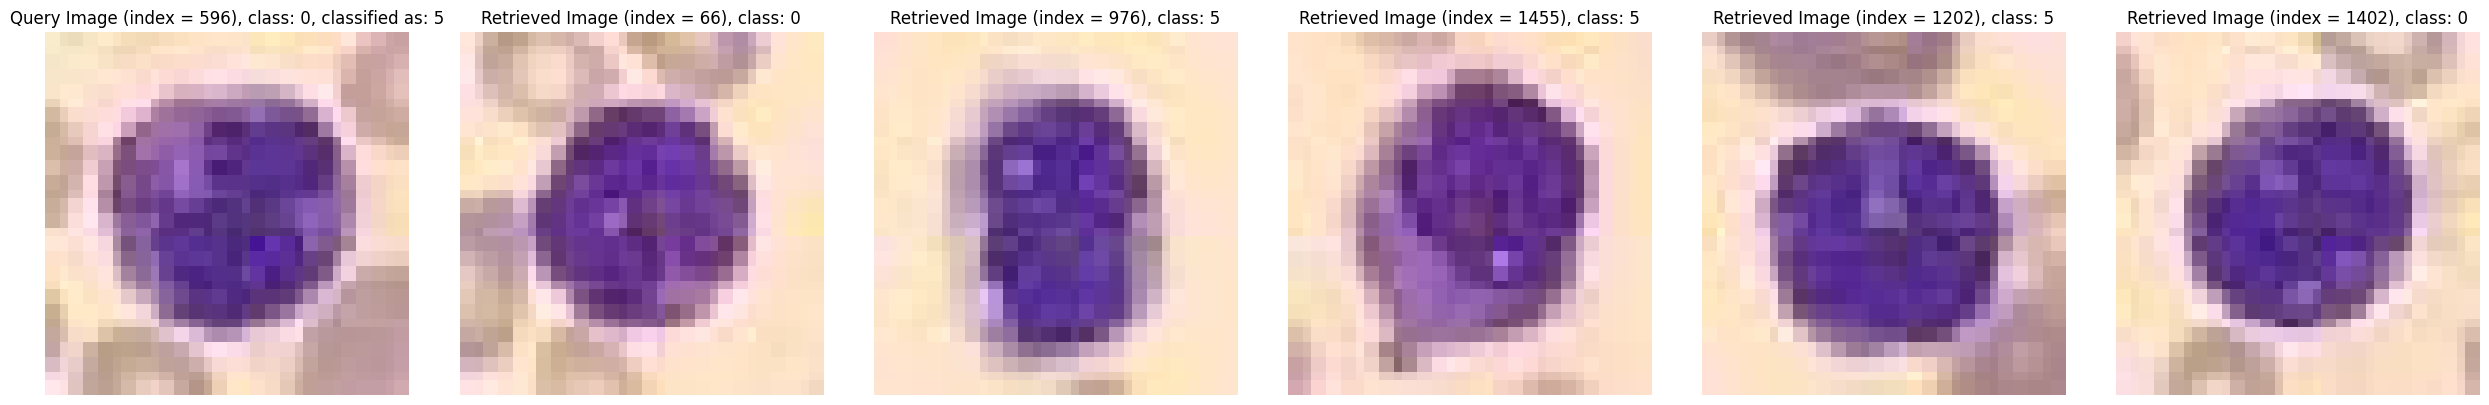

47/47 [==============================] - 1s 25ms/step


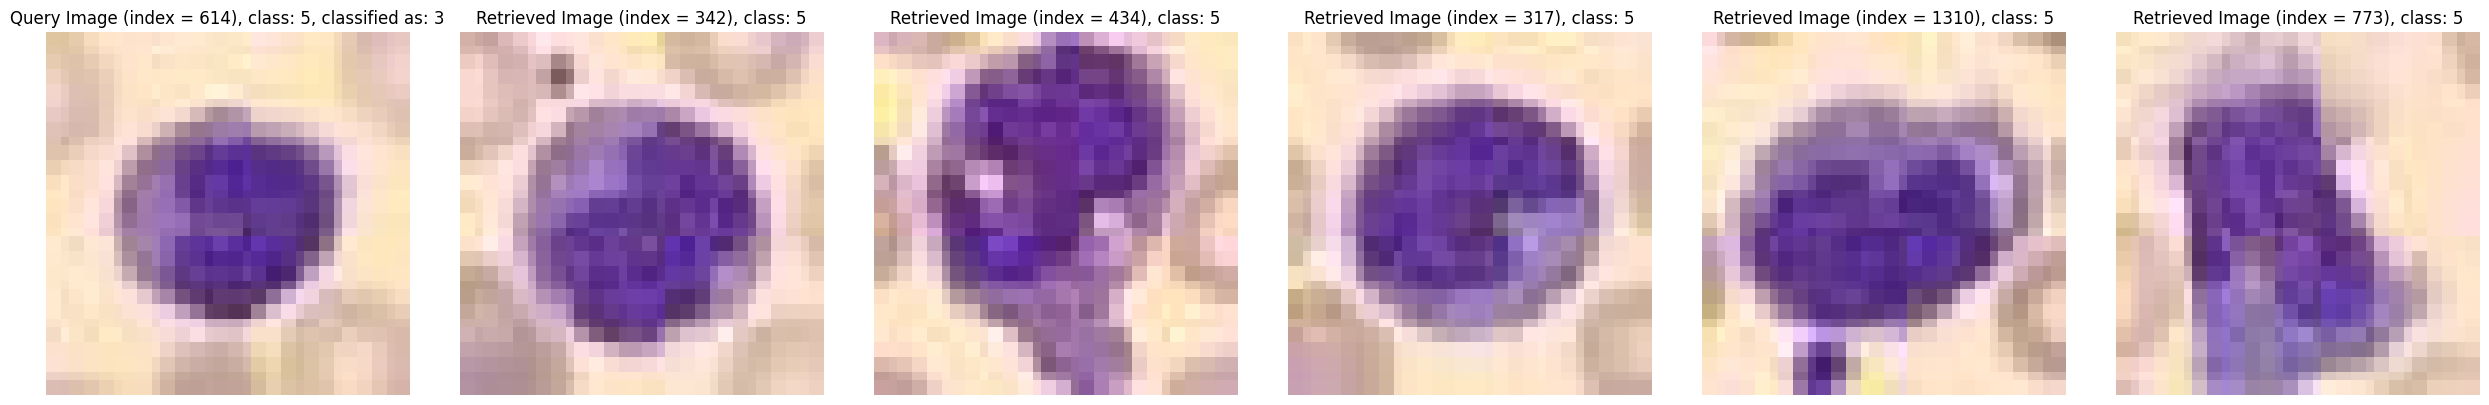

47/47 [==============================] - 1s 27ms/step


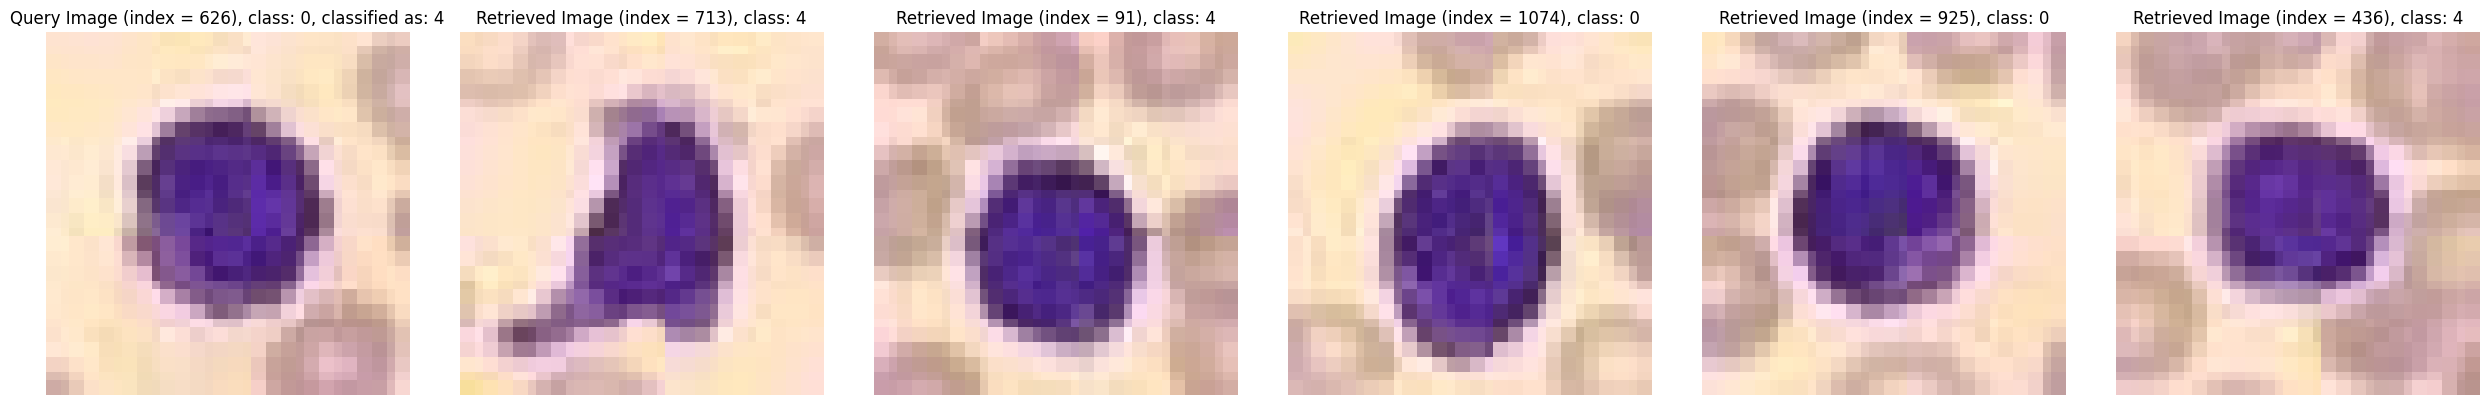

47/47 [==============================] - 1s 27ms/step


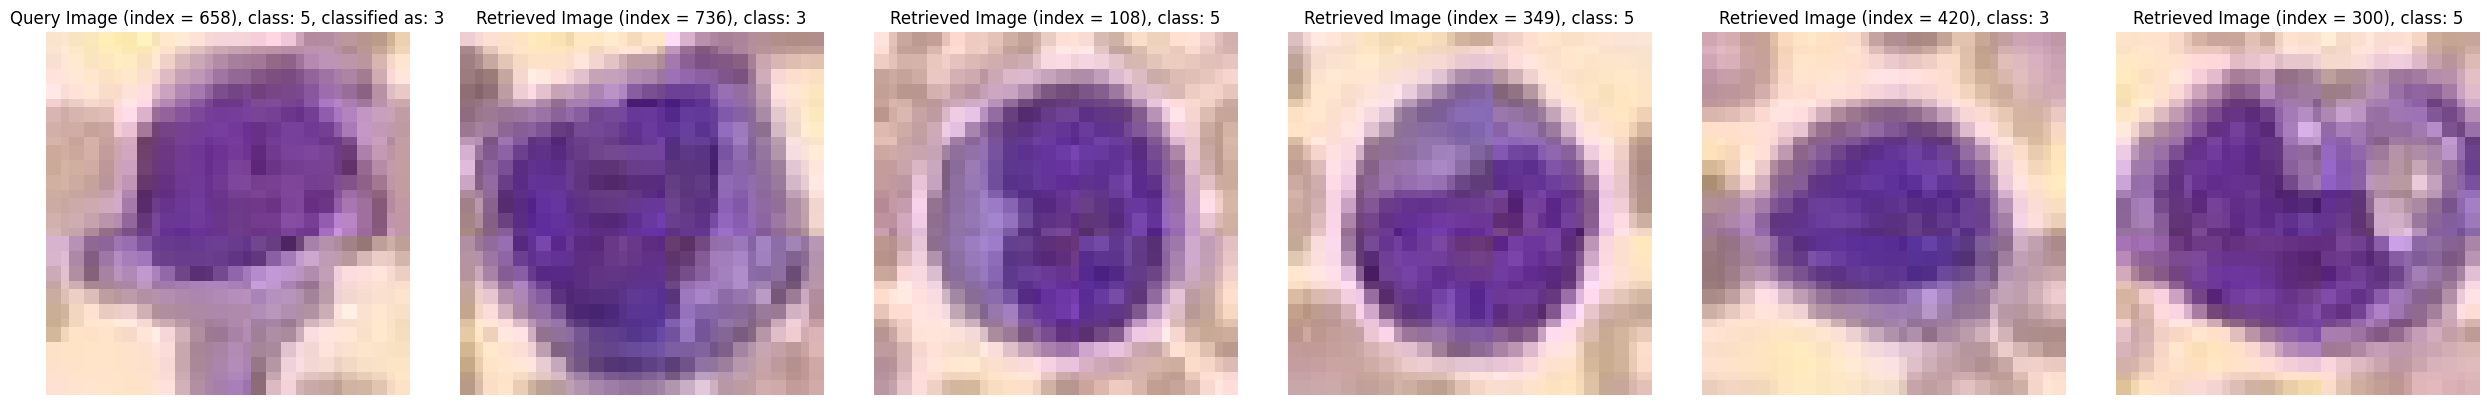

47/47 [==============================] - 1s 26ms/step


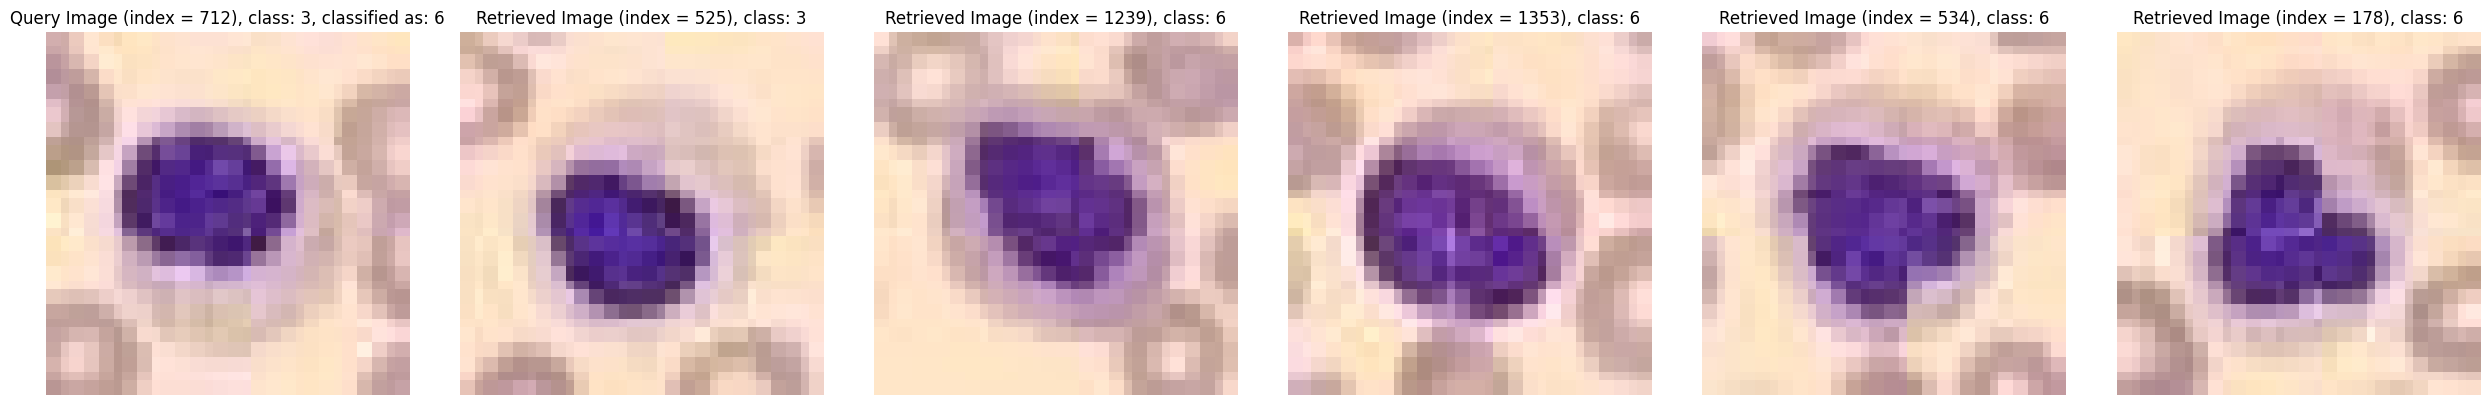

47/47 [==============================] - 1s 26ms/step


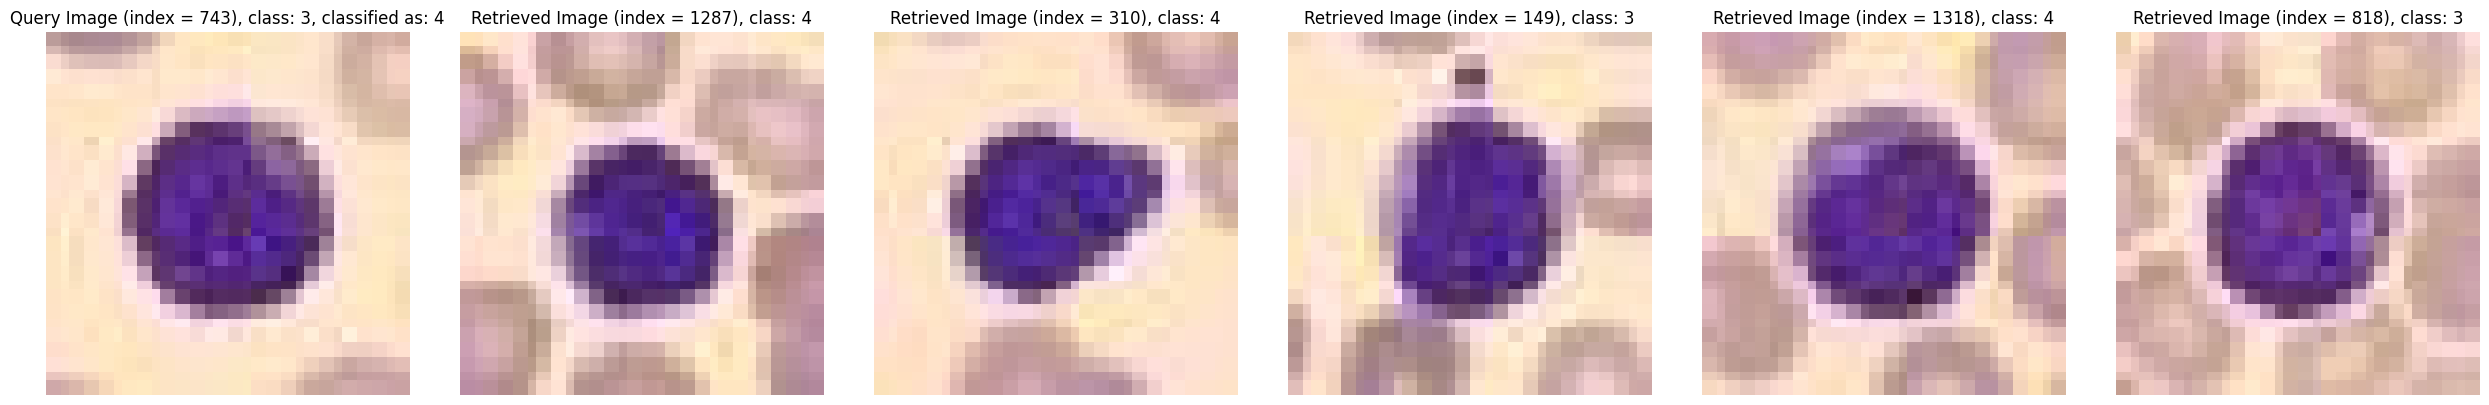

47/47 [==============================] - 1s 27ms/step


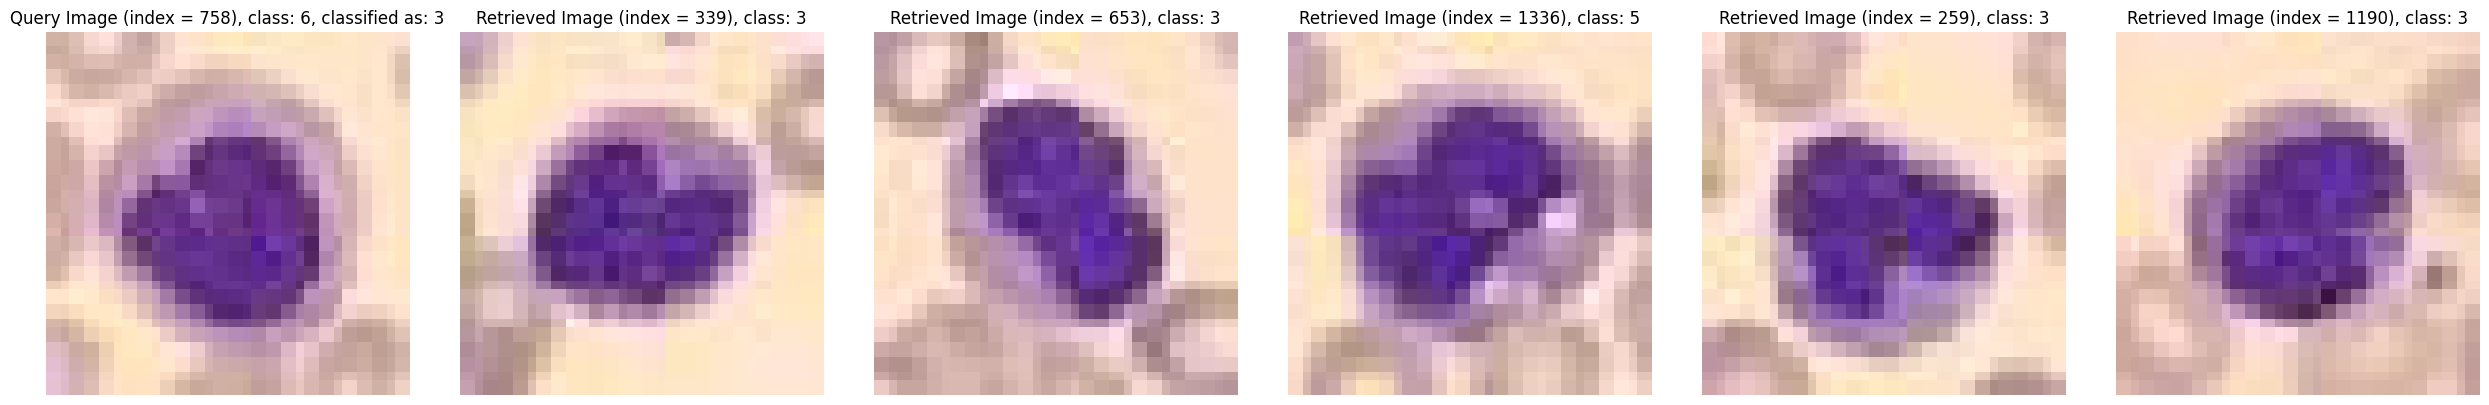

47/47 [==============================] - 1s 25ms/step


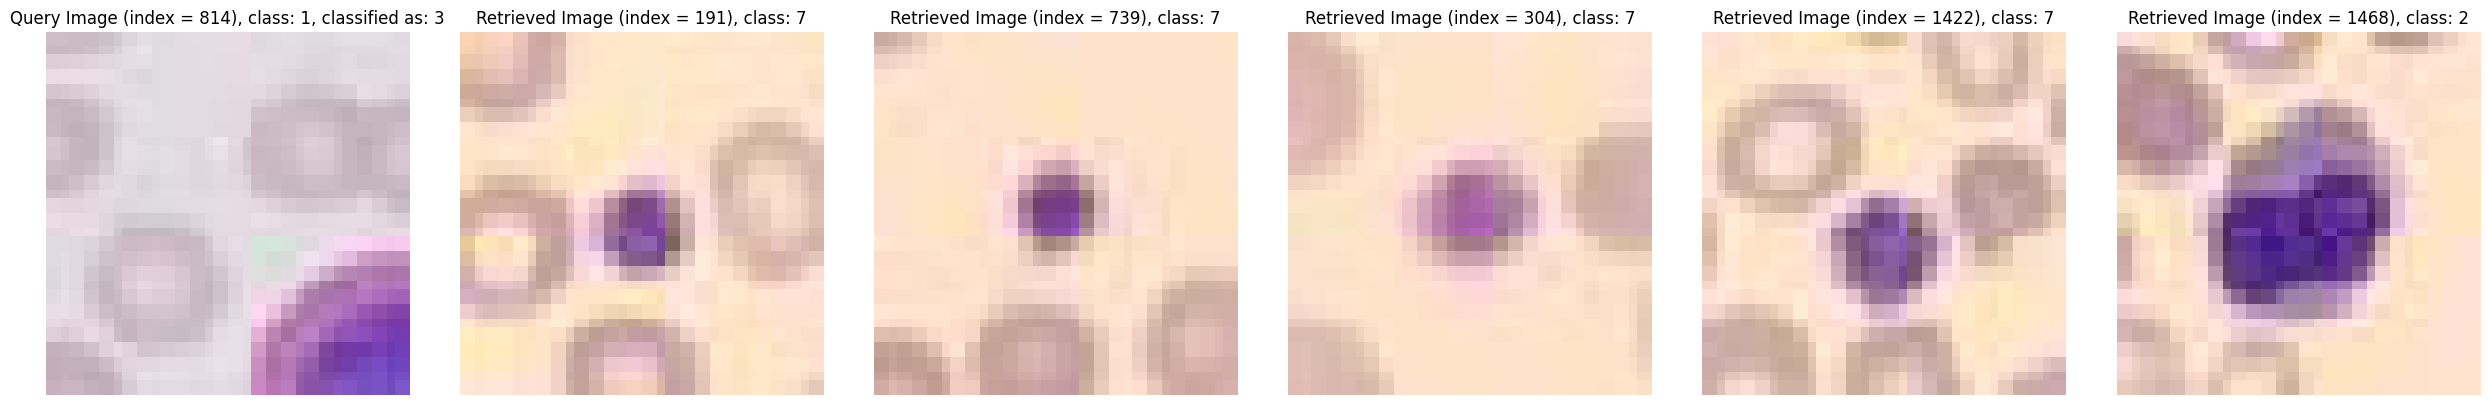

47/47 [==============================] - 1s 25ms/step


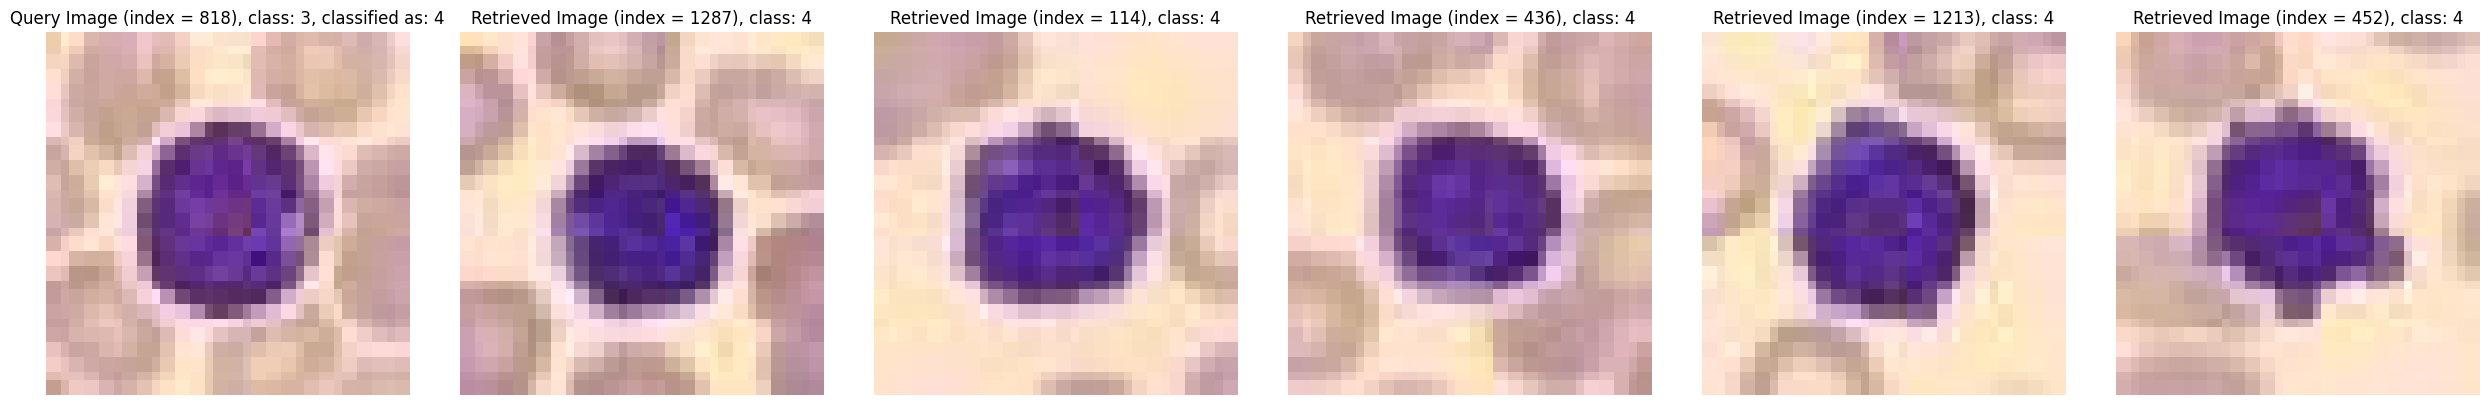

47/47 [==============================] - 1s 25ms/step


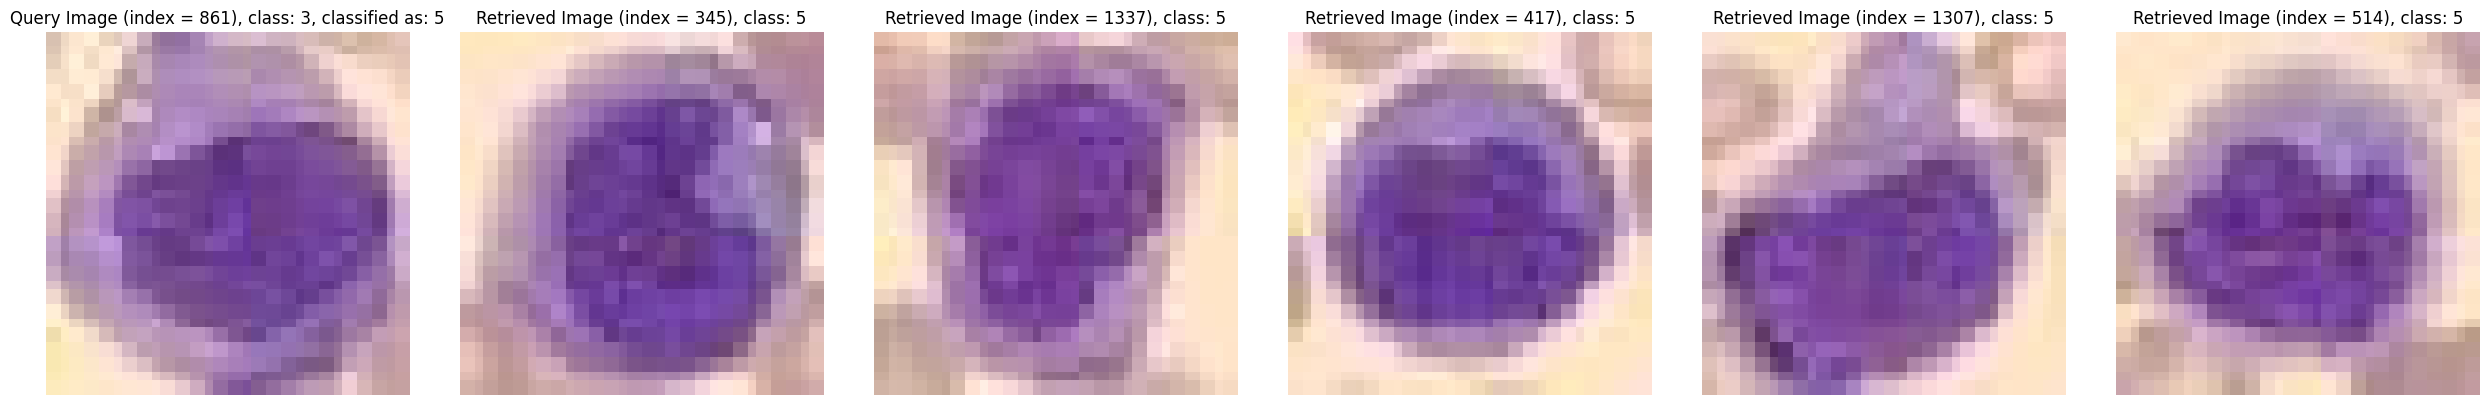

47/47 [==============================] - 1s 25ms/step


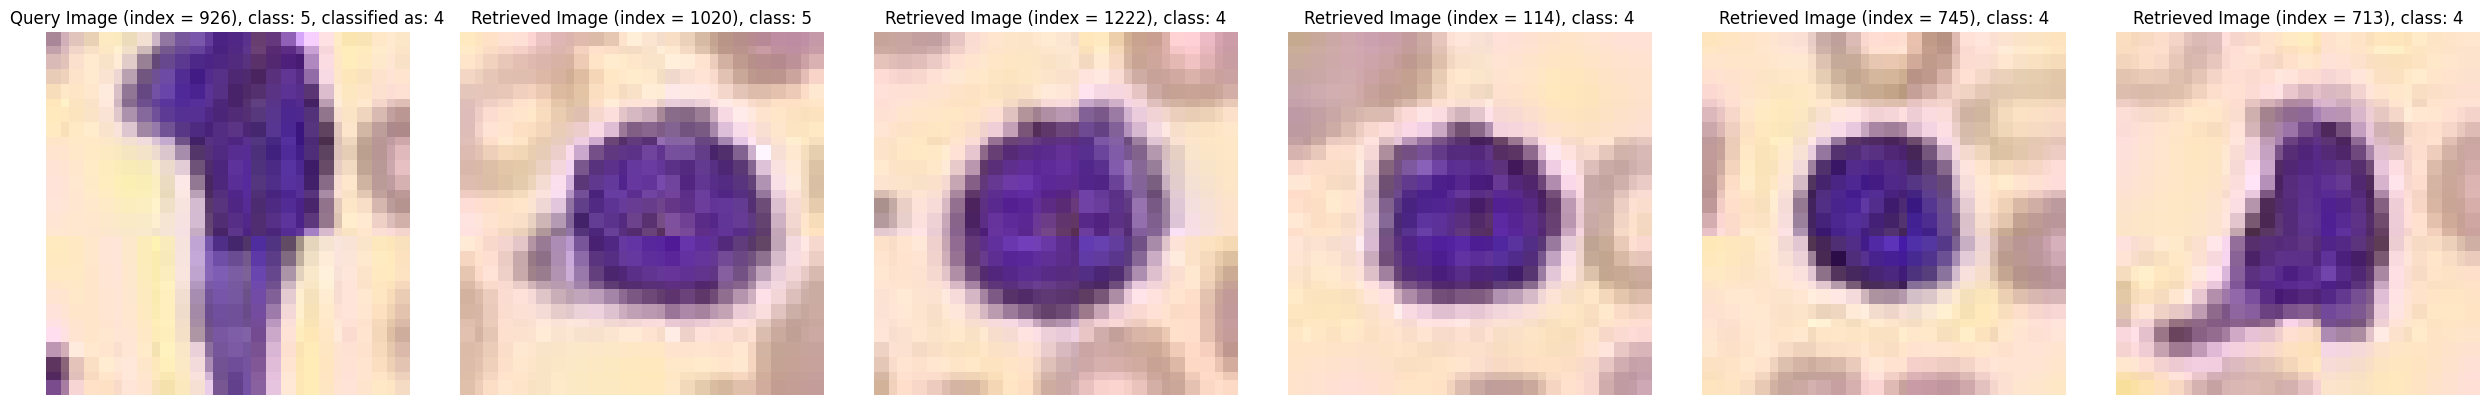

47/47 [==============================] - 1s 27ms/step


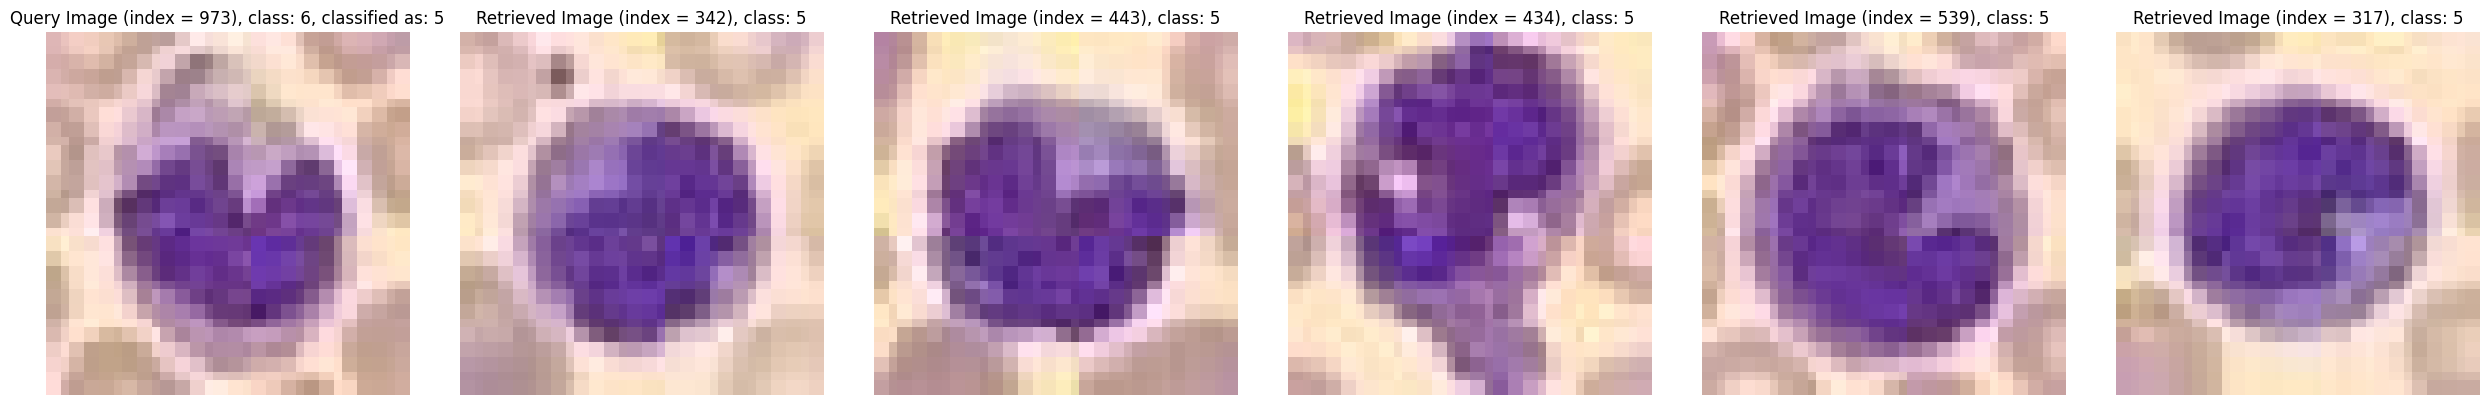

47/47 [==============================] - 1s 25ms/step


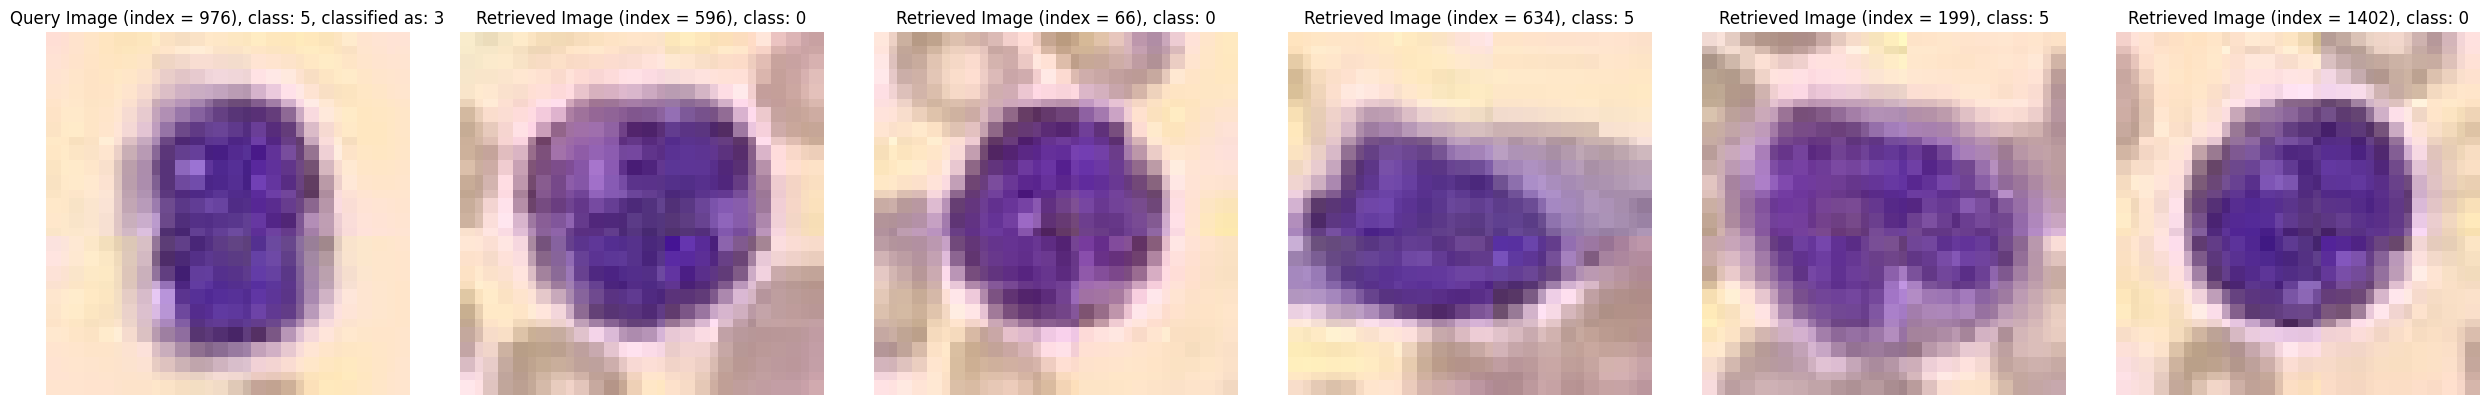

47/47 [==============================] - 1s 25ms/step


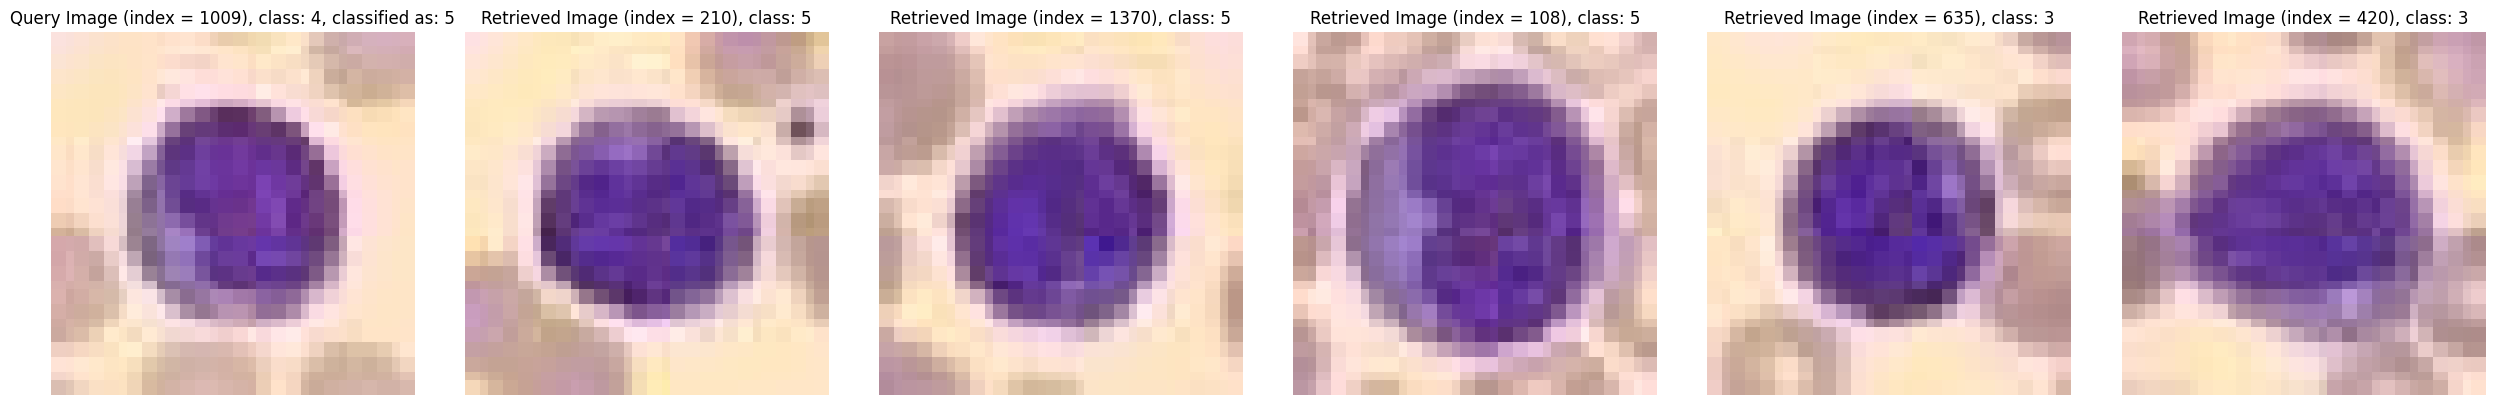

47/47 [==============================] - 1s 25ms/step


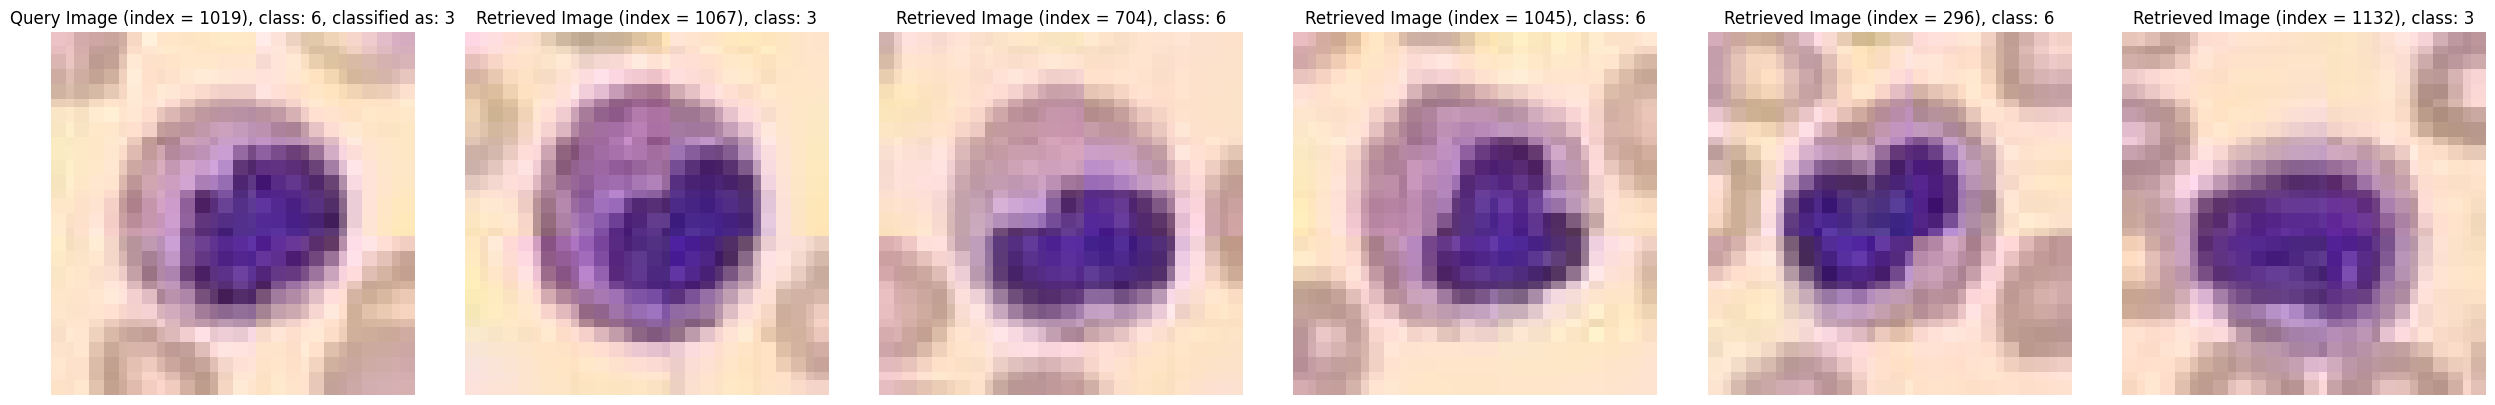

47/47 [==============================] - 1s 25ms/step


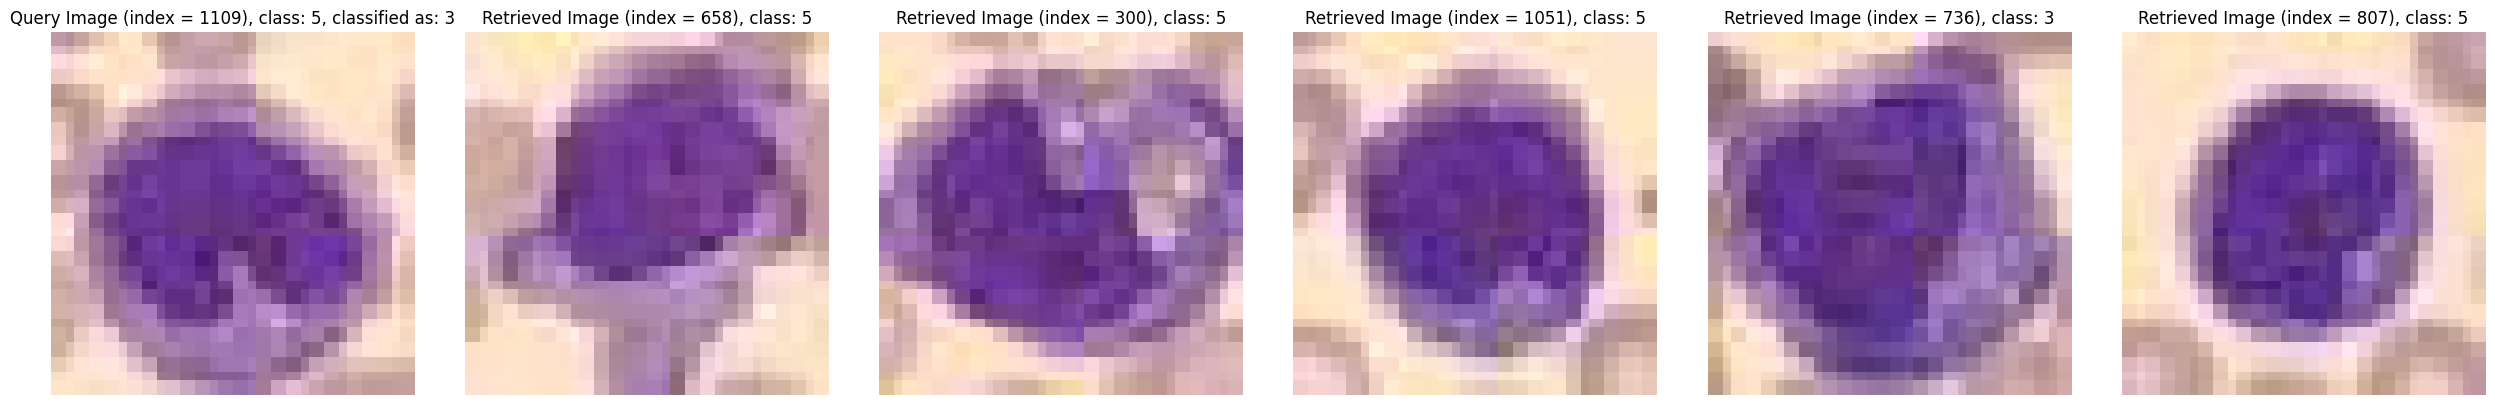

47/47 [==============================] - 1s 27ms/step


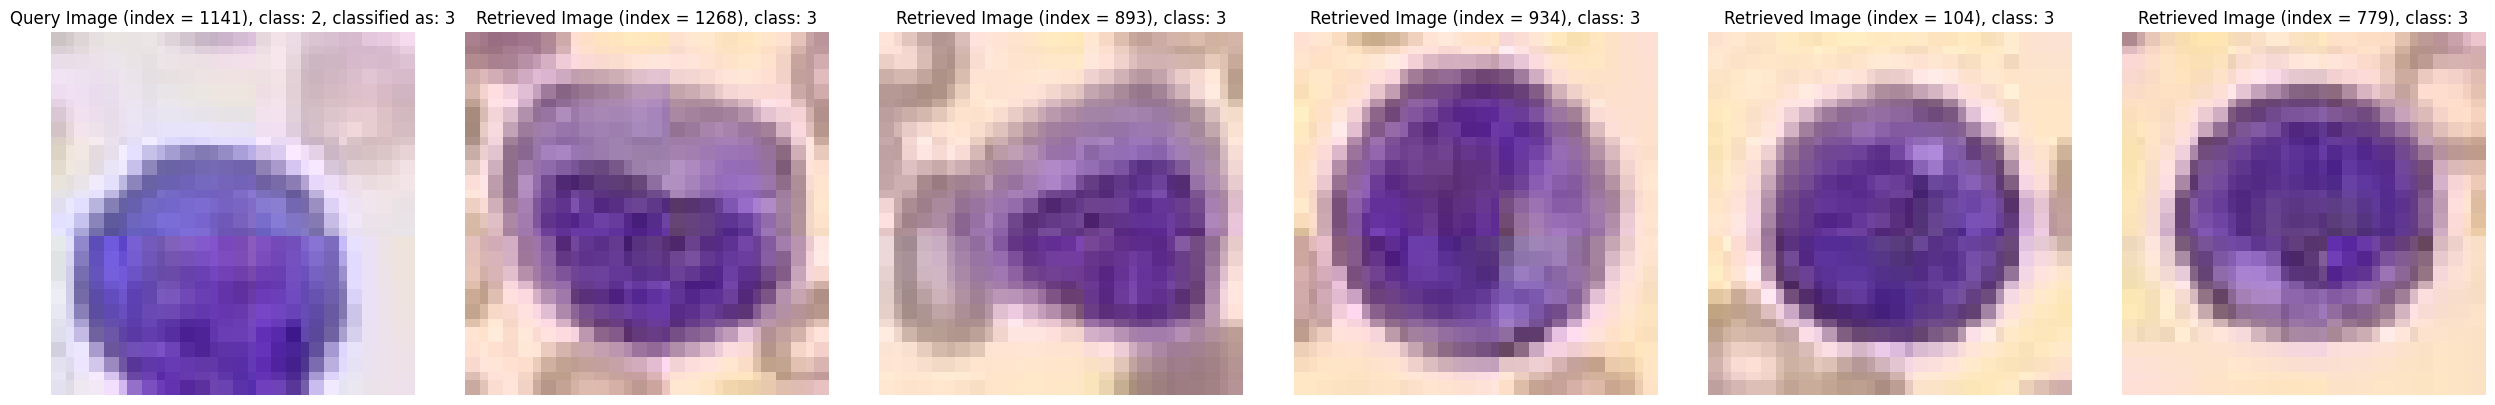

47/47 [==============================] - 1s 25ms/step


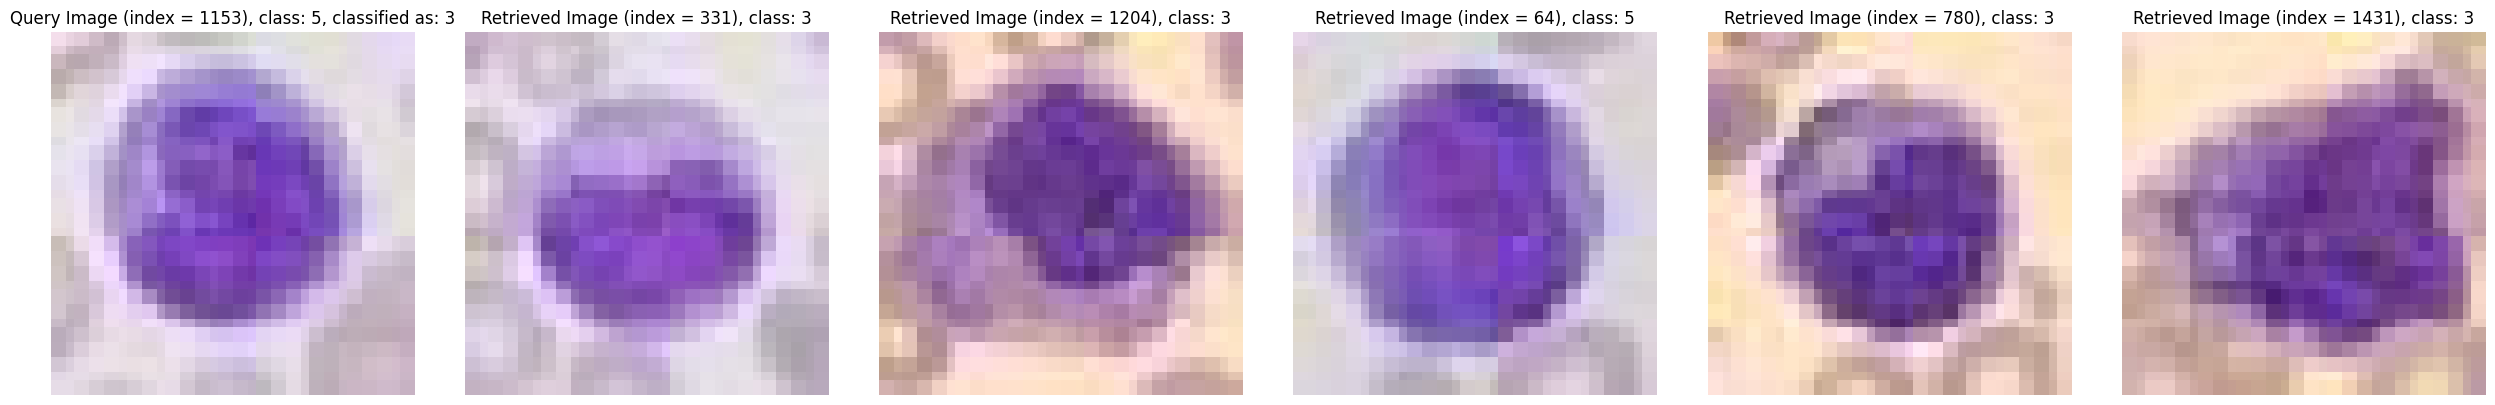

47/47 [==============================] - 1s 25ms/step


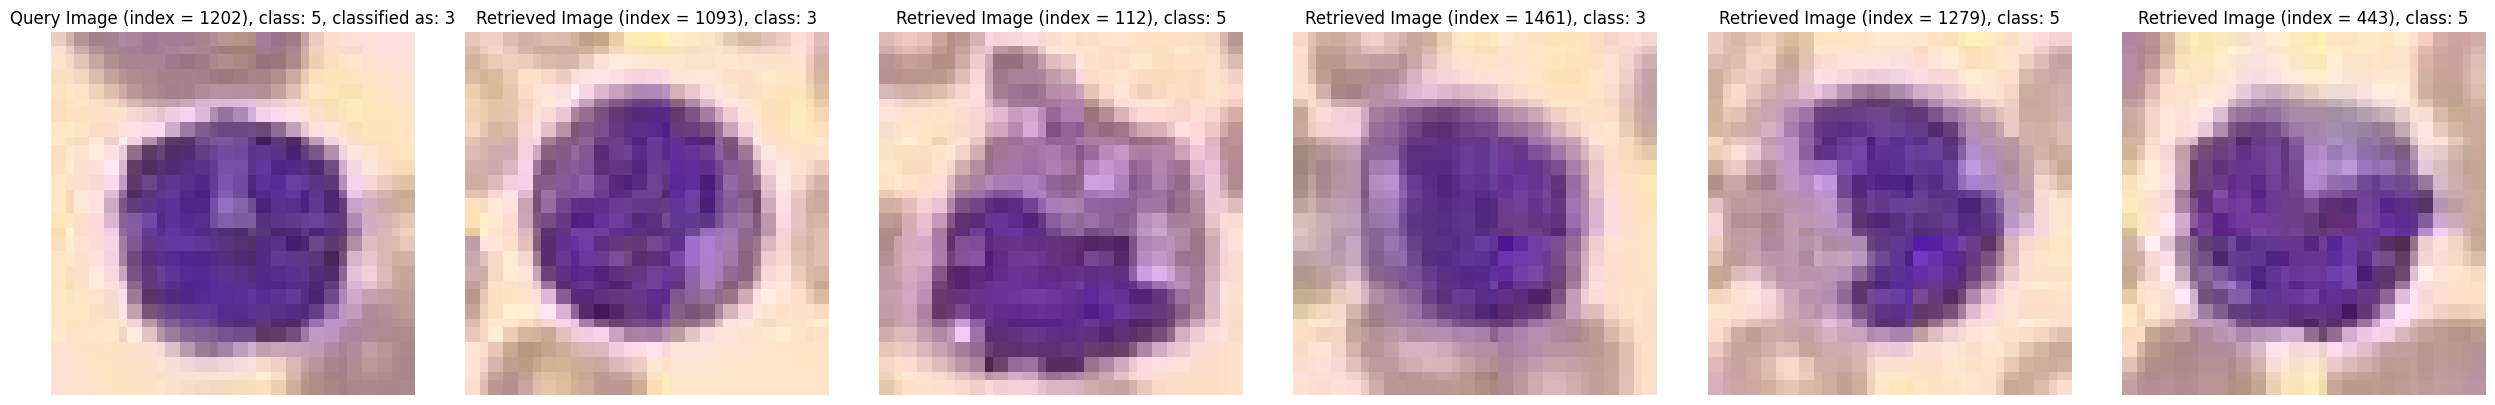

47/47 [==============================] - 1s 25ms/step


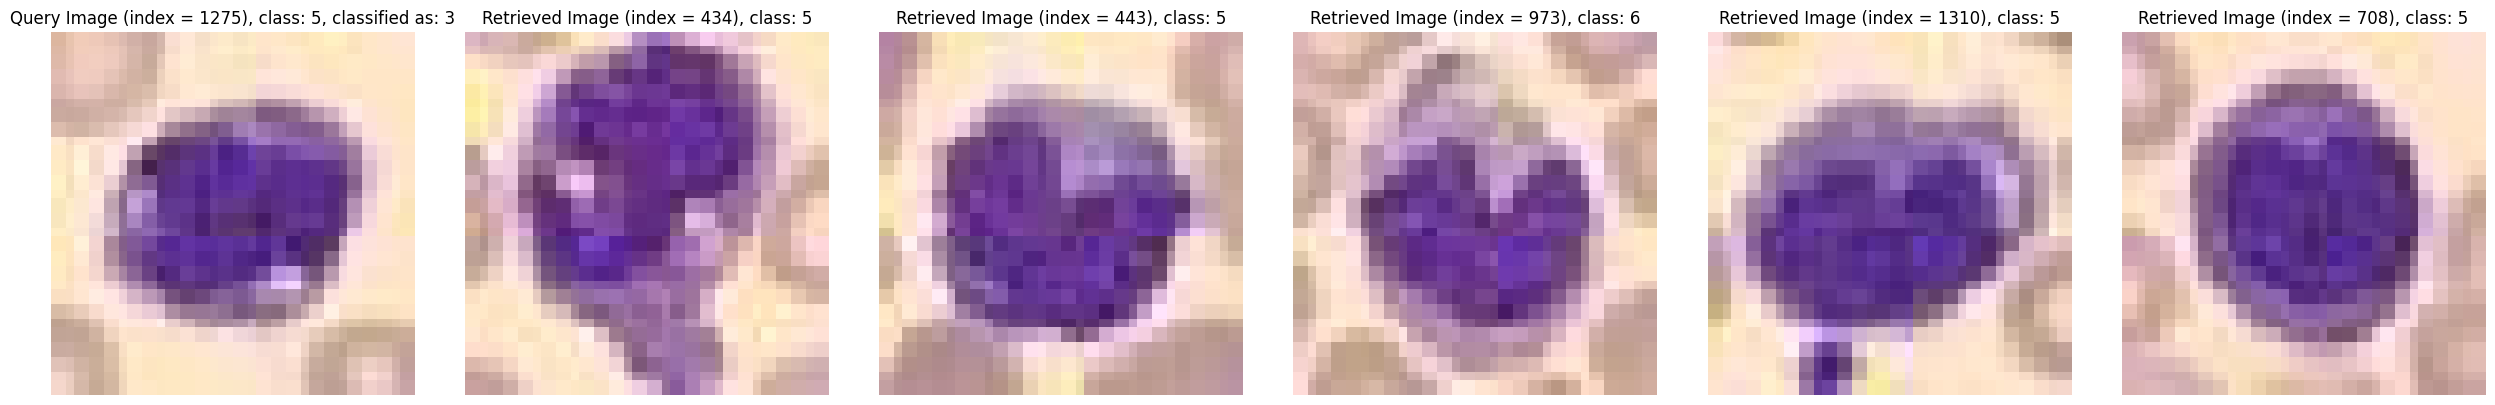

47/47 [==============================] - 1s 26ms/step


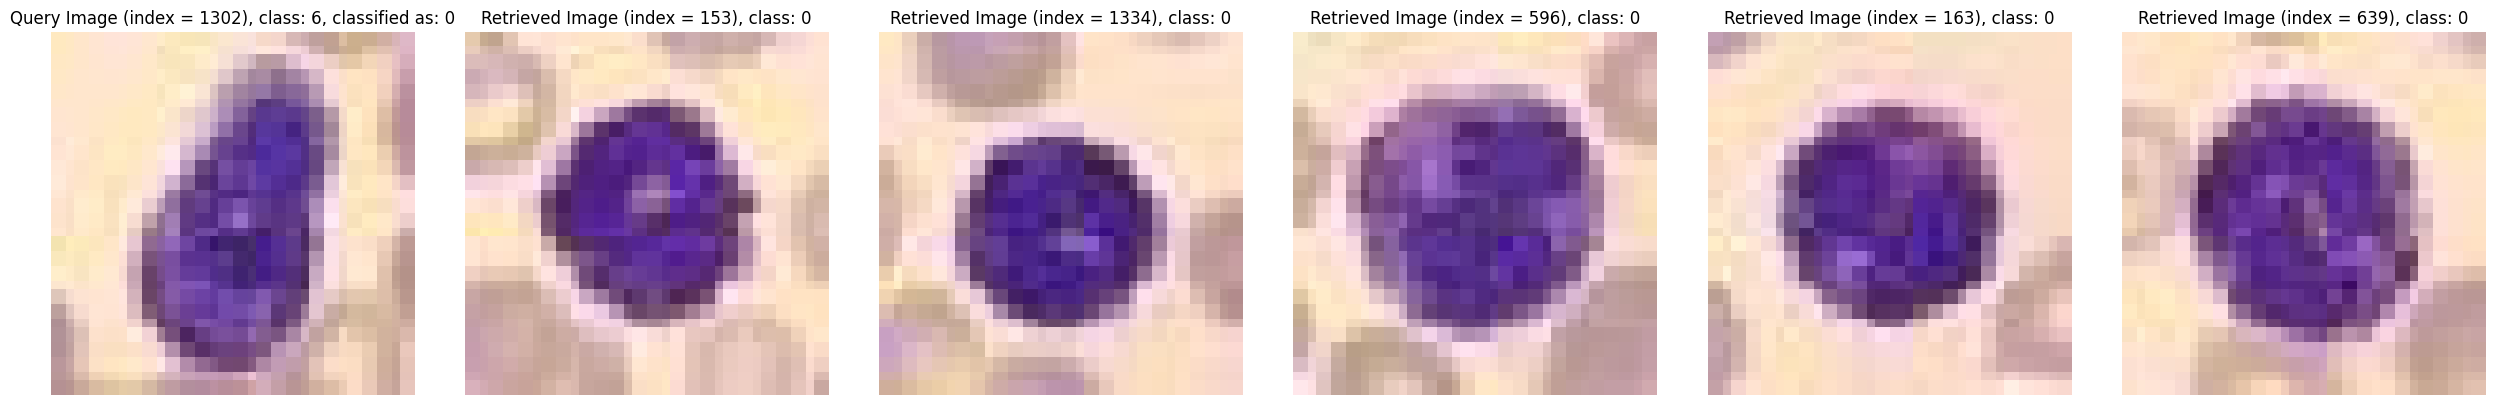

47/47 [==============================] - 1s 26ms/step


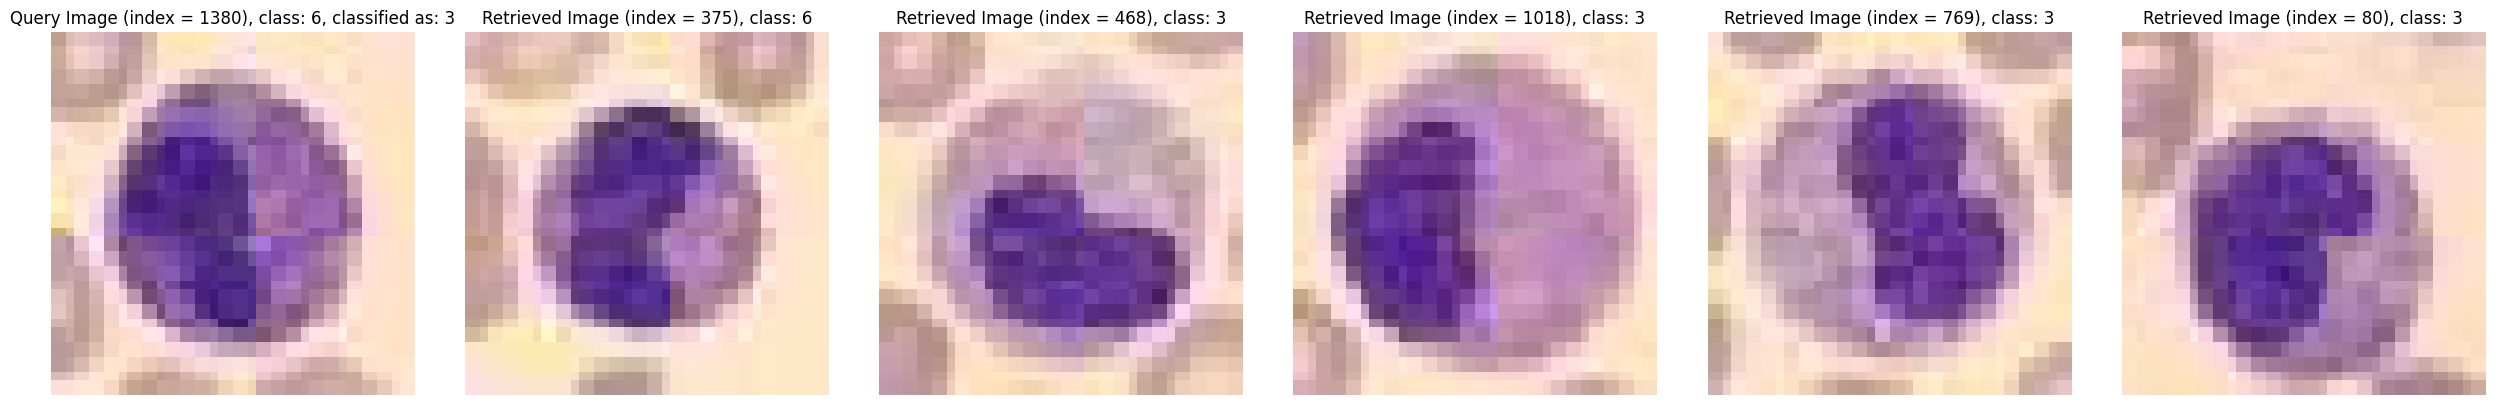

47/47 [==============================] - 1s 25ms/step


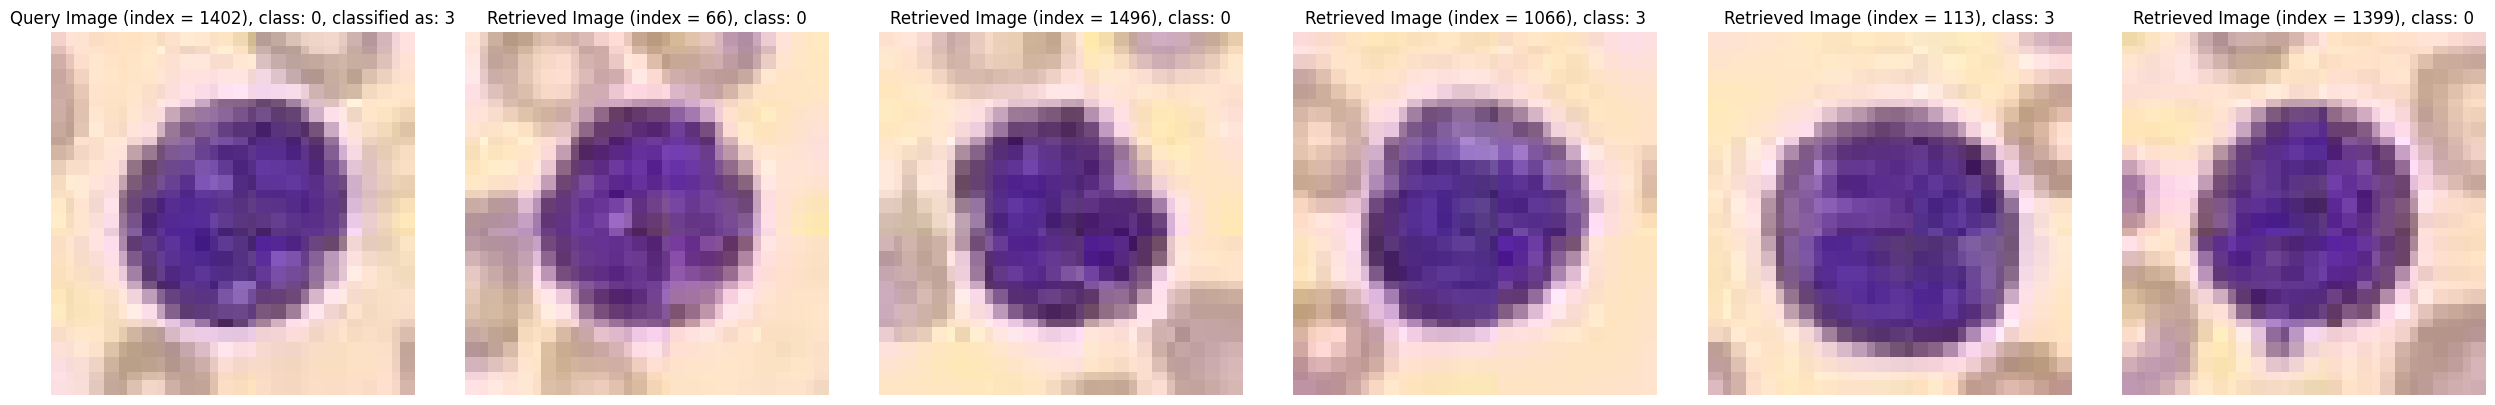

47/47 [==============================] - 1s 25ms/step


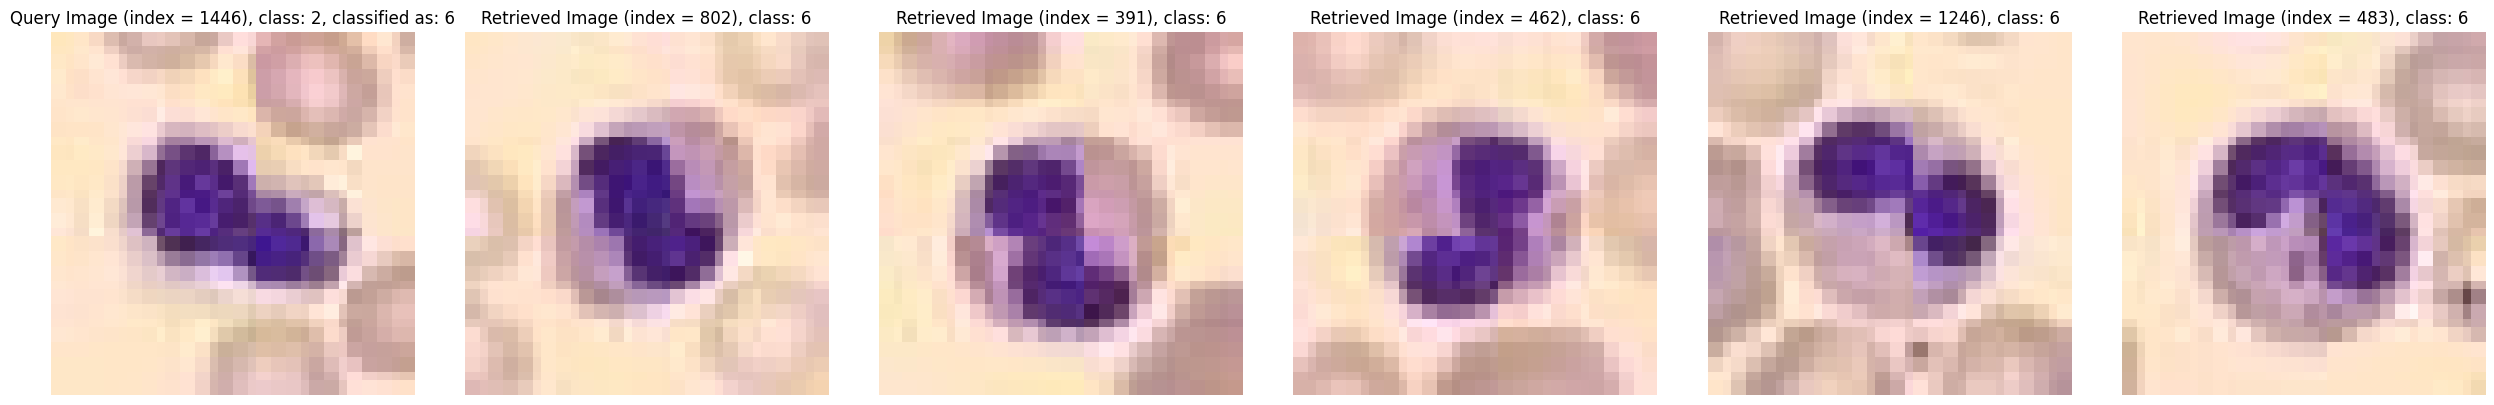

47/47 [==============================] - 1s 25ms/step


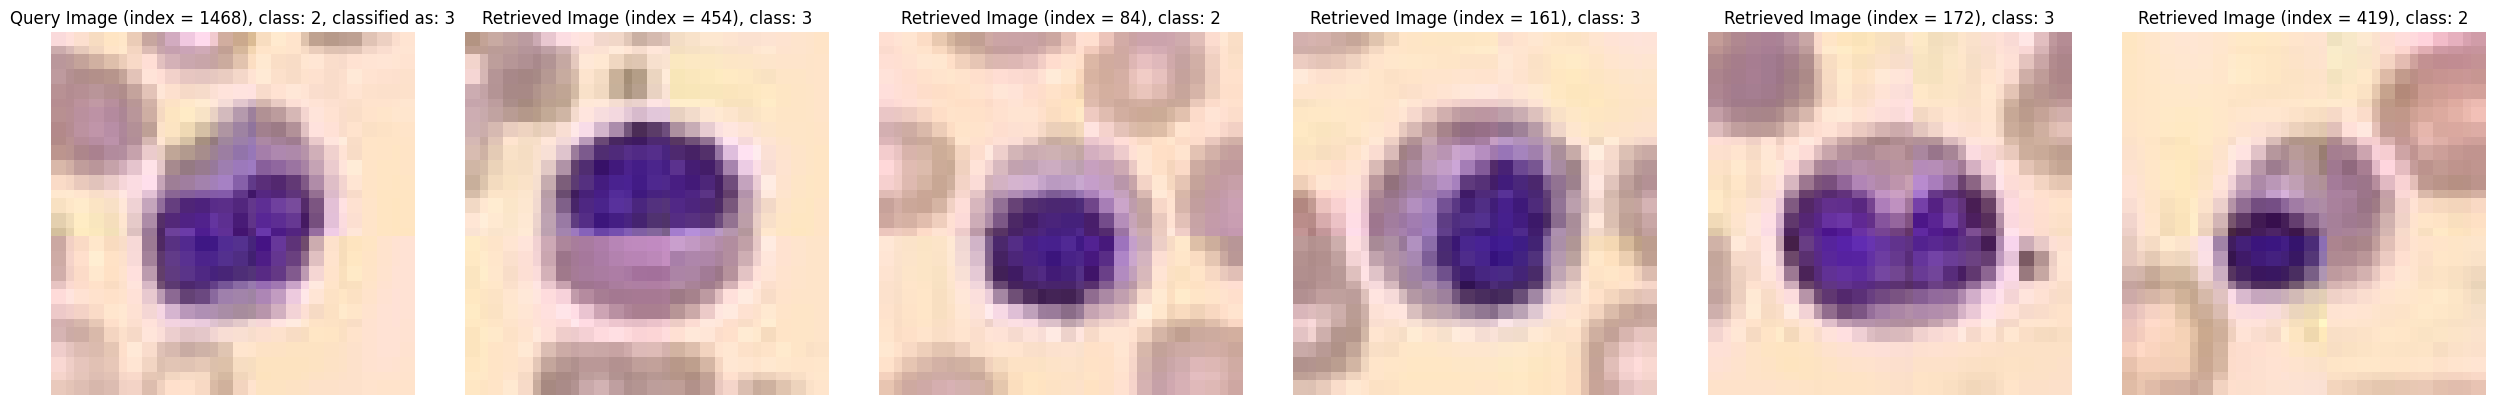

In [ ]:
for index in missclassified_indices:
    query_index = index
    query_image = X_test[query_index]
    num_im = 5
    top_k_indices = image_retrieval(model, X_test, query_image, top_k=num_im)

    # Set the number of subplots based on the top_k + 1 for the query image
    fig, axes = plt.subplots(1, num_im+1, figsize=(25, 4))  # Adjust the figure size as needed

    # Plot the query image
    axes[0].imshow(query_image)
    axes[0].set_title(f'Query Image (index = {query_index}), class: {np.argmax(y_test[query_index])}, classified as: {predictions[query_index]}')
    axes[0].axis('off')

    # Plot the retrieved images
    for i, index in enumerate(top_k_indices):
        axes[i+1].imshow(X_test[index])
        axes[i+1].set_title(f'Retrieved Image ({index = }), class: {np.argmax(y_test[index])}')
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

As we can see the retrieved images look indeed similar to the missclassified images we queried, thus giving a positive signal to the goodness of our model

### Final model training with full data

We have crowned a champion! Now we will train it again on full data, leaving the validation data aside to measure the performance.

In [ ]:
# Concatenate train and test sets
X_train_aug = np.concatenate([X_train, X_test])
y_train_aug = np.concatenate([y_train, y_test])
print(X_train_aug.shape, y_train_aug.shape)

(14092, 48, 48, 3) (14092, 8)


In [ ]:
# Create the model
inception_resnet_aug2 = build_inception_resnetv2_aug()

In [ ]:
# Train the model
history_inceptionresnet_aug2 = inception_resnet_aug2.fit(
    x = X_train_aug,
    y = y_train_aug,
    batch_size = 64,
    epochs = 300,
    validation_data = (X_val, y_val),
    callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=26, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=19, min_lr=1e-5, mode='max')
]
).history

Epoch 1/300
221/221 [==============================] - 82s 223ms/step - loss: 0.6234 - accuracy: 0.8183 - val_loss: 3.1118 - val_accuracy: 0.1660 - lr: 3.0000e-04
Epoch 2/300
221/221 [==============================] - 46s 206ms/step - loss: 0.3719 - accuracy: 0.8916 - val_loss: 2.6738 - val_accuracy: 0.2230 - lr: 3.0000e-04
Epoch 3/300
221/221 [==============================] - 44s 201ms/step - loss: 0.2971 - accuracy: 0.9092 - val_loss: 0.4379 - val_accuracy: 0.8530 - lr: 3.0000e-04
Epoch 4/300
221/221 [==============================] - 45s 204ms/step - loss: 0.2587 - accuracy: 0.9197 - val_loss: 0.4768 - val_accuracy: 0.8180 - lr: 3.0000e-04
Epoch 5/300
221/221 [==============================] - 45s 203ms/step - loss: 0.2382 - accuracy: 0.9256 - val_loss: 0.4099 - val_accuracy: 0.8670 - lr: 3.0000e-04
Epoch 6/300
221/221 [==============================] - 45s 203ms/step - loss: 0.2079 - accuracy: 0.9357 - val_loss: 0.5662 - val_accuracy: 0.7940 - lr: 3.0000e-04
Epoch 7/300
221/221 [=

Let's save our final model under the requested name.

In [ ]:
final_model = tfk.models.load_model('InceptionResNetAugmented3')

In [ ]:
final_model.save('FinalModel')

# Make test inference

In [ ]:
def test_model(test_data_path, model_path):

    # Load the test data
    data = np.load(test_data_path)
    X_test = data['data']
    y_test = data['labels'].astype('int32')

    # The data that will be used to test your model will be in range [0,255] and with type int32
    # If you need, modify the normalization step
    X_test = (X_test/255.).astype('float32')

    # Load the final model
    final_model = tfk.models.load_model(model_path)

    # Make the test predictions
    predictions = final_model.predict(X_test, verbose=0)
    predictions = np.argmax(predictions, axis=-1).astype('int32')

    # Compute classification metrics
    accuracy = accuracy_score(y_test, predictions)

    # Display the computed metrics
    print('Accuracy:', accuracy.round(4))

In [ ]:
test_data_path = "data.npz"
model_path = "FinalModel"
test_model(test_data_path, model_path)

Accuracy: 0.9972
